In [2]:
# === P1: imports, settings, constants, helpers ==============================

import os, re, warnings, logging, math, gc
from pathlib import Path

import numpy as np
import pandas as pd
import scipy.sparse as sp

import scanpy as sc
import anndata as ad
import scvelo as scv
import loompy

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

try:
    import IPython
    if not hasattr(IPython.display, "set_matplotlib_formats"):
        from matplotlib_inline.backend_inline import set_matplotlib_formats as _set_mpl_formats
        IPython.display.set_matplotlib_formats = _set_mpl_formats
except Exception:
    pass

sc.settings.verbosity = 2
sc.settings.set_figure_params(dpi=300, facecolor="white", ipython_format=["png"])
sc.settings.file_format_figs = "pdf"
scv.settings.set_figure_params(dpi_save=300, format="pdf")

RND = 1337
np.random.seed(RND)

# Folders
CACHE = Path("cache"); CACHE.mkdir(exist_ok=True)
PLOTS = Path("plots"); PLOTS.mkdir(exist_ok=True)

# Inputs
META_CSV = "/mnt/d/scRNA-seq/AZ_final_obj/metadata_for_scvelo_final_final.csv"
LOOMS = {
    "wt0_":   "/mnt/d/scRNA-seq/loom_new_anno/W0_possorted_genome_bam_Q0IEG.loom",
    "wt16_":  "/mnt/d/scRNA-seq/loom_new_anno/W16_possorted_genome_bam_HEHGJ.loom",
    "wt24_":  "/mnt/d/scRNA-seq/loom_new_anno/W24_possorted_genome_bam_MUMHX.loom",
    "wt72_":  "/mnt/d/scRNA-seq/loom_new_anno/W72_possorted_genome_bam_3VCHX.loom",
    "gfp0_":  "/mnt/d/scRNA-seq/loom_new_anno/G0_possorted_genome_bam_SPQ1C.loom",
    "gfp16_": "/mnt/d/scRNA-seq/loom_new_anno/G16_possorted_genome_bam_6NW0I.loom",
    "gfp24_": "/mnt/d/scRNA-seq/loom_new_anno/G24_possorted_genome_bam_8AAIZ.loom",
    "gfp72_": "/mnt/d/scRNA-seq/loom_new_anno/G72_possorted_genome_bam_KS8Y2.loom",
    "elac0_": "/mnt/d/scRNA-seq/loom_new_anno/E0_possorted_genome_bam_J4ERS.loom",
    "elac16_":"/mnt/d/scRNA-seq/loom_new_anno/E16_possorted_genome_bam_3AJSP.loom",
    "elac24_":"/mnt/d/scRNA-seq/loom_new_anno/E24_possorted_genome_bam_KL9NW.loom",
    "elac72_":"/mnt/d/scRNA-seq/loom_new_anno/E72_possorted_genome_bam_NT2B6.loom",
}

TP_ORDER   = ["0hpa","16hpa","24hpa","72hpa"]
COND_ORDER = ["WT","GFP","ELAC2 KD"]

# Preprocessing constants
N_TOP_GENES       = 3000
MIN_SHARED_COUNTS = 10

# >>> keep your FAMILY_COLORS and DETAILED_COLS dictionaries here unchanged <<<

# --- helpers ---------------------------------------------------------------

def fix_barcodes(adata: ad.AnnData, prefix: str) -> ad.AnnData:
    def _fix_one(bc: str) -> str:
        bc = re.sub(".*:", "", bc); bc = re.sub("x$", "", bc)
        bc = f"{prefix}{bc}-1"; bc = re.sub(r'-\d+$', '-1', bc)
        return bc
    adata.obs_names = [_fix_one(b) for b in adata.obs_names]
    return adata

def ensure_float32_layers(adx: ad.AnnData, layers=("spliced","unspliced")):
    for L in layers:
        if L in adx.layers and hasattr(adx.layers[L], "dtype") and adx.layers[L].dtype != np.float32:
            adx.layers[L] = adx.layers[L].astype(np.float32)

def _norm_label(x: str) -> str:
    if x is None or (isinstance(x, float) and math.isnan(x)): return x
    x = str(x); x = re.sub(r"[‐‒–—]", "–", x)
    x = re.sub(r"[\r \t]+", " ", x); x = re.sub(r"\s{2,}", " ", x).strip()
    return x

def derive_cond_time_from_barcode(adata: ad.AnnData):
    pref = adata.obs_names.to_series().str.extract(r'^(wt|gfp|elac)(0|16|24|72)_', expand=True)
    adata.obs["cond"] = pref[0].map({'wt':'WT','gfp':'GFP','elac':'ELAC2 KD'}).astype('category')
    adata.obs["timepoint"] = pref[1].map({'0':'0hpa','16':'16hpa','24':'24hpa','72':'72hpa'}).astype('category')
    adata.obs["cond"]      = adata.obs["cond"].cat.set_categories(COND_ORDER, ordered=True)
    adata.obs["timepoint"] = adata.obs["timepoint"].cat.set_categories(TP_ORDER, ordered=True)
    return adata

import re
import unicodedata
import anndata as ad


def add_families_inplace(
    adx: ad.AnnData,
    source_key: str = "celltype",
    target_key: str = "celltype_family",
):
    def _canon(x: str) -> str:
        x = "" if x is None else str(x)
        x = x.replace("⁺", "+").replace("–", "-").replace("’", "'")
        # strip Latin diacritics (keeps Greek letters like σ, ν, ζ, γ intact)
        x = unicodedata.normalize("NFKD", x)
        x = "".join(ch for ch in x if not unicodedata.combining(ch))
        x = x.lower()
        x = re.sub(r"[\s_\-()/]+", "", x)
        return x

    def family_label(lbl: str) -> str:
        c = _canon(lbl)

        # --- Neoblast subtypes (keep specific first) ---
        if ("σ" in c) and ("neoblast" in c):                 return "σ-neoblast"
        if ("ν" in c) and ("neoblast" in c):                 return "ν-neoblast"
        if ("ζ" in c) and ("neoblast" in c):                 return "ζ-neoblast"
        if ("γ" in c) and ("neoblast" in c):                 return "γ-neoblast"
        if ("pharyngeal" in c) and ("neoblast" in c):        return "Pharyngeal neoblast"
        if ("muscle" in c) and ("neoblast" in c):            return "Muscle neoblast"
        if ("protonephrid" in c) and ("neoblast" in c):      return "Protonephridial neoblast"
        if ("parenchymal" in c) and ("neoblast" in c):       return "Parenchymal neoblast"
        if ("eye" in c) and ("neoblast" in c):               return "Eye neoblast"

        # --- Progenitors (lineage-specific) ---
        if ("epidermal" in c) and ("progenitor" in c):       return "Epidermal progenitor"
        if ("epidermis" in c) and ("progenitor" in c):       return "Epidermal progenitor"
        if ("eye" in c) and ("progenitor" in c):             return "Eye progenitor"
        if ("pharyngeal" in c) and ("progenitor" in c):      return "Pharyngeal progenitor"
        if ("protonephrid" in c) and ("progenitor" in c):    return "Protonephridial progenitor"
        if ("parenchymal" in c) and ("progenitor" in c):     return "Parenchymal progenitor"
        if ("neural" in c) and ("progenitor" in c):          return "Neural progenitor"
        if ("pigment" in c) and ("progenitor" in c):         return "Pigment progenitor"

        # --- Pigment (separate family, as requested) ---
        if "pigment" in c:                                   return "Pigment"

        # --- Broad families (from your DETAILED_COLS blocks) ---
        if any(k in c for k in ["epidermis", "epidermal"]):   return "Epidermis"
        if any(k in c for k in ["photoreceptor", "cup"]):     return "Eye"
        if "eye" in c:                                       return "Eye"

        if any(k in c for k in ["neuron", "glia"]):           return "Nervous system"
        if "neural" in c:                                     return "Nervous system"

        if ("pharyngeal" in c) or ("parapharyngeal" in c):    return "Pharynx"
        if any(k in c for k in ["muscle", "bwm", "pole", "pcg", "ecmproducing"]): return "Muscle"
        if "protonephrid" in c:                               return "Protonephridia"

        # Intestine / immune-like (green block, includes Abraçada)
        if any(k in c for k in ["intestine", "intestinal", "goblet", "phagocyte", "basal"]):
            return "Intestine"
        if any(k in c for k in ["abracada", "abracada", "abracadacell", "abracadacel", "abracad"]):
            return "Parenchyma"
        # robust catch for "Abraçada cell" after diacritic strip -> "abracadacell"
        if "abracadacell" in c:                               return "Parenchyma"

        if "parenchymal" in c:                                return "Parenchyma"

        return "other"

    fam = adx.obs[source_key].astype(str).map(family_label)
    adx.obs[target_key] = fam.astype("category")
    return adx

GLOBAL_ADJ = None
GLOBAL_DIST = None
NEIGH_CONN_KEY = None
NEIGH_DIST_KEY = None


In [13]:
# === P2: memory-safe loom loading ==========================================

RAW = CACHE / "adata_raw_loom_merged.h5ad"

CHUNK_COLS = 25000
LAYER_SPLICED   = "spliced"
LAYER_UNSPLICED = "unspliced"

def _pick_first_key(d, candidates):
    for k in candidates:
        if k in d:
            return k
    raise KeyError(f"None of the keys {candidates} found. Available: {list(d.keys())}")

def _fix_one_bc(bc: str) -> str:
    bc = re.sub(".*:", "", bc)
    bc = re.sub("x$", "", bc)
    bc = f"{bc}-1"
    bc = re.sub(r"-\d+$", "-1", bc)
    return bc

def _loom_genes(ds) -> np.ndarray:
    key = _pick_first_key(ds.ra, ["Gene", "GeneName", "gene", "Accession"])
    g = ds.ra[key].astype(str)
    g = np.array([re.sub(r"\s+", "", x) for x in g])
    return g

def _loom_barcodes(ds) -> np.ndarray:
    key = _pick_first_key(ds.ca, ["CellID", "cellid", "Barcode", "barcode", "obs_names"])
    return ds.ca[key].astype(str)

def _prefixed_barcodes(raw_bcs: np.ndarray, prefix: str) -> np.ndarray:
    fixed = np.array([prefix + _fix_one_bc(bc) for bc in raw_bcs], dtype=object)
    return fixed

def _read_layers(ds, cols: np.ndarray):
    S = ds.layers[LAYER_SPLICED][:, cols]
    U = ds.layers[LAYER_UNSPLICED][:, cols]
    if not sp.issparse(S): S = sp.csc_matrix(S)
    if not sp.issparse(U): U = sp.csc_matrix(U)
    S = S.T.astype(np.float32, copy=False).tocsr()
    U = U.T.astype(np.float32, copy=False).tocsr()
    return S, U

if RAW.exists():
    adata = sc.read_h5ad(RAW)
else:
    meta = pd.read_csv(META_CSV, usecols=["barcode"])
    meta_bcs = (
        meta["barcode"].astype(str).str.strip()
        .str.replace("–", "-", regex=False)
        .tolist()
    )
    meta_set = set(meta_bcs)
    del meta

    tmp_files = []

    for prefix, path in LOOMS.items():
        with loompy.connect(path, mode="r") as ds:
            genes    = _loom_genes(ds)
            raw_bcs  = _loom_barcodes(ds)
            prefixed = _prefixed_barcodes(raw_bcs, prefix)

            keep_mask = np.fromiter((b in meta_set for b in prefixed),
                                    dtype=bool, count=prefixed.size)
            keep_idx = np.where(keep_mask)[0]
            if keep_idx.size == 0:
                continue

            for start in range(0, keep_idx.size, CHUNK_COLS):
                cols = keep_idx[start:start + CHUNK_COLS]
                if cols.size == 0:
                    continue

                S, U = _read_layers(ds, cols)

                obs_names = prefixed[cols]
                var = pd.DataFrame(index=genes)
                obs = pd.DataFrame(index=obs_names)
                obs.index.name = "barcode"
                obs["batch"] = prefix.rstrip("_")

                if S.shape[0] != obs.shape[0] or S.shape[1] != var.shape[0]:
                    raise ValueError(f"Shape mismatch: X={S.shape}, obs={obs.shape[0]}, var={var.shape[0]}")

                ad_chunk = ad.AnnData(
                    X=S,
                    obs=obs,
                    var=var,
                    layers={LAYER_SPLICED: S, LAYER_UNSPLICED: U},
                    dtype=np.float32,
                )
                ad_chunk.var_names_make_unique()

                tmp_path = CACHE / f"tmp_{prefix}{start:07d}.h5ad"
                ad_chunk.write(tmp_path)
                tmp_files.append(tmp_path)

                del S, U, ad_chunk, obs, var
                gc.collect()

            del genes, raw_bcs, prefixed, keep_mask, keep_idx
            gc.collect()

    if len(tmp_files) == 0:
        raise RuntimeError("No cells matched metadata barcodes; check META_CSV vs loom barcodes/prefixes.")

    ad_merged = None
    for i, f in enumerate(tmp_files):
        ad_i = sc.read_h5ad(f, backed=None)
        if ad_merged is None:
            ad_merged = ad_i
        else:
            ad_merged = sc.concat([ad_merged, ad_i],
                                  join="outer", merge="same",
                                  label=None, index_unique=None)
        del ad_i
        gc.collect()

    ad_merged.obs.index.name = "barcode"
    ad_merged.var_names_make_unique()
    assert {LAYER_SPLICED, LAYER_UNSPLICED} <= set(ad_merged.layers.keys())

    ad_merged.write(RAW)

    for f in tmp_files:
        try:
            os.remove(f)
        except Exception:
            pass

    adata = ad_merged
    del ad_merged
    gc.collect()

adata


AnnData object with n_obs × n_vars = 74403 × 25265
    obs: 'batch'
    layers: 'spliced', 'unspliced'

In [16]:
# === P4: global preprocessing (HVG, confounder mask, PCA, neighbors) ======

PP = CACHE / "adata_preprocessed.h5ad"

marker_ids = [
        "SMESG000041758.1","SMESG000006121.1","SMESG000025003.1","SMESG000025013.1","SMESG000054781.1",
        "SMESG000028264.1","SMESG000000720.1","SMESG000077404.1","SMESG000077405.1","SMESG000019274.1",
        "SMESG000005380.1","SMESG000051964.1","SMESG000075230.1","SMESG000001180.1","SMESG000040332.1",
        "SMESG000043036.1","SMESG000052888.1","SMESG000022963.1","SMESG000022668.1","SMESG000062589.1",
        "SMESG000027543.1","SMESG000066594.1","SMESG000001830.1","SMESG000001839.1","SMESG000023117.1",
        "SMESG000072183.1","SMESG000016228.1","SMESG000039906.1","SMESG000081245.1","SMESG000026446.1",
        "SMESG000050057.1","SMESG000065255.1","SMESG000020792.1","SMESG000021346.1","SMESG000062615.1",
        "SMESG000016881.1","SMESG000068903.1","SMESG000026025.1","SMESG000074489.1","SMESG000001561.1",
        "SMESG000031965.1","SMESG000005975.1","SMESG000001687.1","SMESG000045025.1","SMESG000050160.1",
        "SMESG000020910.1","SMESG000031796.1","SMESG000031800.1","SMESG000032489.1","SMESG000035182.1",
        "SMESG000013991.1","SMESG000013992.1","SMESG000049781.1","SMESG000049783.1","SMESG000044930.1",
        "SMESG000077075.1","SMESG000027359.1","SMESG000004222.1","SMESG000052644.1","SMESG000041571.1",
        "SMESG000051002.1","SMESG000000615.1","SMESG000054829.1","SMESG000034317.1","SMESG000002557.1",
        "SMESG000037029.1","SMESG000014725.1","SMESG000014728.1","SMESG000014733.1","SMESG000021248.1",
        "SMESG000037982.1","SMESG000014322.1","SMESG000074928.1","SMESG000069322.1","SMESG000072430.1",
        "SMESG000024191.1","SMESG000066476.1","SMESG000005930.1","SMESG000006550.1","SMESG000081129.1",
        "SMESG000034317.1","SMESG000003513.1","SMESG000036363.1","SMESG000036385.1","SMESG000062915.1",
        "SMESG000076173.1","SMESG000037031.1","SMESG000039559.1","SMESG000014588.1","SMESG000079512.1",
        "SMESG000068287.1","SMESG000004840.1","SMESG000051170.1","SMESG000078256.1","SMESG000065235.1",
        "SMESG000066244.1","SMESG000002774.1","SMESG000081885.1","SMESG000011244.1","SMESG000017305.1",
        "SMESG000027459.1","SMESG000081970.1","SMESG000070309.1","SMESG000002173.1","SMESG000010063.1",
        "SMESG000074761.1","SMESG000036375.1","SMESG000069984.1","SMESG000021009.1","SMESG000026774.1",
        "SMESG000068398.1","SMESG000034472.1","SMESG000051357.1","SMESG000041535.1","SMESG000069017.1",
        "SMESG000051356.1","SMESG000024277.1","SMESG000050934.1","SMESG000050924.1","SMESG000018924.1",
        "SMESG000026791.1","SMESG000030049.1","SMESG000052932.1","SMESG000032477.1","SMESG000061339.1",
        "SMESG000012683.1","SMESG000029269.1","SMESG000029304.1","SMESG000066649.1","SMESG000013430.1",
        "SMESG000008070.1","SMESG000037720.1","SMESG000014268.1","SMESG000067397.1","SMESG000067002.1",
        "SMESG000066980.1","SMESG000005014.1","SMESG000059487.1","SMESG000018492.1","SMESG000018504.1",
        "SMESG000033381.1","SMESG000014723.1","SMESG000081952.1","SMESG000022856.1","SMESG000010916.1",
        "SMESG000001774.1","SMESG000057112.1","SMESG000016568.1","SMESG000043039.1","SMESG000020988.1",
        "SMESG000053732.1","SMESG000080359.1","SMESG000021044.1","SMESG000001598.1","SMESG000001609.1",
        "SMESG000000522.1","SMESG000019737.1","SMESG000067985.1","SMESG000023346.1","SMESG000023352.1",
        "SMESG000028474.1","SMESG000005963.1","SMESG000023353.1","SMESG000027826.1","SMESG000002628.1",
        "SMESG000019973.1","SMESG000019976.1","SMESG000019984.1","SMESG000044960.1","SMESG000019457.1",
        "SMESG000025547.1","SMESG000041532.1","SMESG000042714.1","SMESG000042718.1","SMESG000048406.1",
        "SMESG000029000.1","SMESG000065670.1","SMESG000023052.1","SMESG000004239.1","SMESG000006530.1",
        "SMESG000018258.1","SMESG000069088.1","SMESG000031846.1","SMESG000022958.1","SMESG000022356.1",
        "SMESG000033462.1","SMESG000074524.1","SMESG000044603.1","SMESG000069765.1","SMESG000003437.1",
        "SMESG000061191.1","SMESG000071069.1","SMESG000001687.1","SMESG000005975.1","SMESG000022725.1",
        "SMESG000017121.1","SMESG000062486.1","SMESG000072084.1"
    ]

if PP.exists():
    adata = sc.read_h5ad(PP)
else:
    # Geometry based on spliced counts
    if "spliced" in adata.layers:
        adata.X = adata.layers["spliced"]

    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    # HVGs
    try:
        import skmisc  # noqa: F401
        HVG_FLAVOR = "seurat_v3"
    except Exception:
        HVG_FLAVOR = "seurat"

    sc.pp.highly_variable_genes(
        adata,
        n_top_genes=N_TOP_GENES,
        flavor=HVG_FLAVOR,
        subset=False
    )

    # Confounder genes (DNA replication, ribosome, etc.) – keep as you defined
    pattern = r"(SMESG000046293.1|SMESG000005389.1|SMESG000038798.1|SMESG000060238.1|SMESG000057772.1|SMESG000070153.1|SMESG000036830.1|SMESG000014909.1|SMESG000000804.1|SMESG000006063.1|SMESG000006068.1|SMESG000006083.1|SMESG000018037.1|SMESG000023149.1|SMESG000035458.1|SMESG000077264.1|SMESG000074436.1|SMESG000057110.1|SMESG000028669.1|SMESG000054290.1|SMESG000060055.1|SMESG000059543.1|SMESG000036986.|SMESG000022017.1|SMESG000017173.1|SMESG000017172.1)"
    conf = pd.Series(
        pd.Index(adata.var_names).str.contains(pattern, case=False, regex=True),
        index=adata.var_names
    ).to_numpy()

    # Force-keep marker genes in geometry
    try:
        def _canon_id(x: str):
            x = re.sub(r"\s+", "", str(x))
            return re.sub(r"\.\d+$", "", x).lower()
        canon_map = {_canon_id(v): v for v in adata.var_names}
        must_keep = [canon_map[_canon_id(m)] for m in marker_ids if _canon_id(m) in canon_map]
        must_keep_mask = adata.var_names.isin(must_keep).to_numpy()
    except Exception:
        must_keep_mask = np.zeros(adata.n_vars, dtype=bool)

    hvg_mask  = adata.var["highly_variable"].to_numpy()
    geom_mask = (hvg_mask & ~conf) | must_keep_mask
    adata     = adata[:, geom_mask].copy()

    # PCA / neighbors only – UMAP stays Seurat-based
    sc.tl.pca(
        adata,
        n_comps=50,
        svd_solver="arpack",
        random_state=RND,
        zero_center=False
    )
    sc.pp.neighbors(adata, use_rep="X_pca", n_neighbors=20, n_pcs=30, random_state=RND)

    # Do not overwrite X_umap; keep Seurat embedding
    # Keep joint alias pointing to Seurat UMAP
    if "X_umap_seurat" in adata.obsm:
        adata.obsm["X_umap_joint"] = adata.obsm["X_umap_seurat"].copy()

    apply_palette(adata, "celltype",        DETAILED_COLS, strict=False)
    apply_palette(adata, "celltype_family", FAMILY_COLORS, strict=False)

    adata.write(PP)

# Global adjacency
nbrs = adata.uns.get("neighbors", {})
NEIGH_CONN_KEY = nbrs.get("connectivities_key", "connectivities")
NEIGH_DIST_KEY = nbrs.get("distances_key", "distances")

if NEIGH_CONN_KEY not in adata.obsp or NEIGH_DIST_KEY not in adata.obsp:
    raise KeyError("Neighbor graphs not found in .obsp")

GLOBAL_ADJ  = adata.obsp[NEIGH_CONN_KEY].tocsr()
GLOBAL_DIST = adata.obsp[NEIGH_DIST_KEY].tocsr()



In [17]:
# === P3: annotate from Seurat metadata, freeze Seurat UMAP ==================

ANNO = CACHE / "adata_annotated.h5ad"
# --- robust palette handling (drop-in replacement for apply_palette) -------
# Colors (families)
FAMILY_COLORS = {
    # Neoblast subtypes 
    "σ-neoblast":               "#E3E3E3",
    "ν-neoblast":               "#707070",
    "ζ-neoblast":               "#8D8D8D",
    "γ-neoblast":               "#AAAAAA",
    "Muscle neoblast":          "#D5D5D5",
    "Protonephridial neoblast": "#B8B8B8",
    "Parenchymal neoblast":     "#B3B3B3",
    "Pharyngeal neoblast":      "#7F7F7F",
    "Eye neoblast":             "#00D3D3",   

    # Progenitors 
    "Epidermal progenitor":     "#ABCEDF",   # Early epidermal progenitor
    "Eye progenitor":           "#00D3D3",   # Eye progenitor
    "Pharyngeal progenitor":    "#D9D900",   # Pharyngeal progenitor
    "Parenchymal progenitor":   "#E39F55",   # NKX2⁺ parenchymal progenitor
    "Protonephridial progenitor":"#874A68",  # align to protonephridia wine block
    "Neural progenitor":        "#DED5F6",   # Glutamatergic neural progenitor
    "Pigment progenitor":       "#C08A5A",

    # Mature 
    "Epidermis":                "#5685BD",   # Epidermis (broad)
    "Eye":                      "#00D3D3",   # Eye progenitor (cyan block)
    "Intestine":                "#497F46",   # Phagocyte (broad)
    "Pigment":                  "#8E5A3C",   # Body pigment cell
    "Muscle":                   "#CC5C5D",   # ECM-producing muscle
    "Nervous system":           "#9171BF",   # Mechanosensory neuron (representative violet)
    "Parenchyma":               "#F3D38E",   # LDLRR-1⁺ parenchymal cell
    "Pharynx":                  "#FFFF00",   # Pharyngeal epithelium
    "Protonephridia":           "#874A68",   # Protonephridial flame cell

    "other":                    "#BDBDBD",
}
# Colors (detailed cell types)
DETAILED_COLS = {
  # --- Epidermis (blue) ---
  "Early epidermal progenitor"             : "#ABCEDF",
  "Late epidermal progenitor"              : "#6693C4",
  "Epidermis (broad)"                      : "#5685BD",
  "Epidermis (multiciliated)"              : "#3468B0",
  "Epidermal progenitor (multiciliated)"   : "#4576B6",
  "Epidermal secretory gland progenitor"   : "#99BFD8",
  
  # --- Eye (cyan) ---
  "Eye progenitor"                         : "#00D3D3",
  
  # --- Intestine / immune-like (green) ---
  "Basal cell"                             : "#D3E4BA",
  "Goblet cell"                            : "#8DB180",
  "Phagocyte (broad)"                     : "#497F46",
  
  # --- Pigment (brown) ---
  "Body pigment progenitor"                : "#C08A5A",
  "Body pigment cell"                      : "#8E5A3C",
  
  # --- Muscle (red) ---
  "Muscle progenitor"                      : "#F2C7CA",
  "BWM (dorsal midline)"                   : "#E6A3A6",
  "ECM-producing muscle"                   : "#CC5C5D",
  "Posterior pole/PCG muscle"              : "#C1393A",
  
  # --- Neoblasts (grey) ---
  "σ-neoblast (broad-lineage)"             : "#E3E3E3",
  "Muscle neoblast"                        : "#D5D5D5",
  "Protonephridial neoblast"               : "#B8B8B8",
  "Pharyngeal neoblast"                    : "#7F7F7F",
  "γ-neoblast (intestinal-fated)"          : "#AAAAAA",
  "ζ-neoblast (epidermal-fated)"           : "#8D8D8D",
  "ν-neoblast (neural-fated)"              : "#707070",
  "GLIRP-1⁺ parenchymal neoblast"          : "#B3B3B3",
  "PGRN⁺ parenchymal neoblast"             : "#BEBEBE",
  "FER3L-2⁺ parenchymal neoblast"          : "#C7C7C7",
  
  # --- Neural lineage (violet) ---
  "Neural progenitor (broad)"              : "#E9E4FA",
  "Glutamatergic neural progenitor"        : "#DED5F6",
  "Neuropeptidergic neural progenitor"     : "#D3C7F2",
  "Mechanosensory neural progenitor"       : "#C9BAEE",
  "PKD⁺ sensory neural progenitor"         : "#BFADE8",
  "Glia"                                   : "#AF98D5",
  "Brain branch neuron"                    : "#D8CCF3",
  "Catecholaminergic neuron"               : "#CDBFEB",
  "Cholinergic neuron"                     : "#C3B2E4",
  "Glutamatergic neuron"                   : "#A58ACE",
  "Mechanosensory neuron"                  : "#9171BF",
  "Neuropeptidergic neuron"                : "#8764B8",
  "PKD⁺ sensory neuron"                    : "#7349A9",
  "Serotonergic neuron"                    : "#693CA2",
  
  # --- Parenchyma (sand) ---
  "AQP⁺ parenchymal cell"                  : "#F9E29D",
  "LDLRR-1⁺ parenchymal cell"              : "#F3D38E",
  "GLIRP-1⁺ parenchymal progenitor"        : "#EDC281",
  "PSAP⁺ parenchymal progenitor"           : "#F1D6A0",
  "PSAP⁺ parenchymal cell"                 : "#EBB670",
  "PGRN⁺ parenchymal cell"                 : "#EFC57F",
  "FER3L-2⁺ parenchymal progenitor"        : "#E8B567",
  "NKX2⁺ parenchymal progenitor"           : "#E39F55",
  "PTF⁺ head parenchymal progenitor"       : "#E6A860",
  "SSPO⁺ parenchymal progenitor"           : "#E19A51",
  "SSPO⁺ parenchymal cell"                 : "#DD8B42",
  "Abraçada cell"                          : "#FAE8B4",
  
  # --- Pharynx (yellow) ---
  "Pharyngeal epithelium"                  : "#FFFF00",
  "Pharyngeal progenitor"                  : "#D9D900",
  "Pharyngeal phagocytic-type cell"        : "#C9C900",
  
  # --- Protonephridia (wine) ---
  "Protonephridial flame cell"             : "#874A68",
  "Protonephridial tubule cell"            : "#87345F"
}

def _canon_label_for_palette(x: str) -> str:
    """
    Canonicalize labels to match palette keys irrespective of case, plus signs,
    spaces, unicode variants.
    """
    x = str(x)
    x = x.replace("⁺", "+").replace("–", "-").replace("—", "-").replace("’", "'")
    x = re.sub(r"\s+", " ", x).strip()
    return x.lower()

def _canon_palette(pal: dict) -> dict:
    """Return dict keyed by canonical labels, preserving original color values."""
    return {_canon_label_for_palette(k): v for k, v in pal.items()}

def apply_palette(adx: ad.AnnData, key: str, palette: dict,
                  fallback: str = "#808080", strict: bool = True):
    """
    Attach a color list to adx.uns[f"{key}_colors"] matching the categories
    of adx.obs[key].

    - Canonicalizes both palette keys and category labels to avoid mismatches.
    - If strict=True, raises with a list of missing labels so you catch typos early.
    """
    if key not in adx.obs:
        raise KeyError(f"obs[{key}] not found")

    cats   = list(adx.obs[key].astype("category").cat.categories)
    pal_map = _canon_palette(palette)

    colors  = []
    missing = []
    for c in cats:
        cc = _canon_label_for_palette(c)
        col = pal_map.get(cc, None)
        if col is None:
            missing.append(c)
            col = fallback
        colors.append(col)

    if strict and missing:
        raise ValueError(f"Palette missing colors for categories in '{key}': {missing}")

    adx.uns[f"{key}_colors"] = colors
    return missing  # so you can log or inspect if strict=False

def audit_palette_coverage(adx: ad.AnnData, key: str, palette: dict):
    """
    Print a concise audit of palette coverage for debugging.
    """
    if key not in adx.obs:
        raise KeyError(f"obs[{key}] not found")

    cats    = list(adx.obs[key].astype("category").cat.categories)
    pal_map = _canon_palette(palette)
    miss    = [c for c in cats if _canon_label_for_palette(c) not in pal_map]

    if miss:
        print(f"[audit] {key}: {len(miss)}/{len(cats)} categories missing in palette:")
        for c in miss:
            print("   -", c)
    else:
        print(f"[audit] {key}: full coverage for {len(cats)} categories")

if ANNO.exists():
    adata = sc.read_h5ad(ANNO)
else:
    meta = pd.read_csv(META_CSV)
    need = {"barcode","celltype","UMAP1","UMAP2"}
    missing = need - set(meta.columns)
    if missing:
        raise ValueError(f"Metadata missing columns: {missing}")

    meta["barcode"]  = meta["barcode"].astype(str).str.strip().str.replace("–", "-", regex=False)
    meta["celltype"] = meta["celltype"].astype(str).map(_norm_label)
    meta = meta.set_index("barcode")

    overlap = adata.obs.index.intersection(meta.index)
    if len(overlap) == 0:
        raise ValueError("No overlap in barcodes between AnnData and metadata")

    adata = adata[overlap, :].copy()
    adata.obs["celltype"] = meta.loc[overlap, "celltype"].astype("category")

    # >>> Seurat UMAP, used everywhere <<<
    seurat_umap = meta.loc[overlap, ["UMAP1","UMAP2"]].to_numpy()
    adata.obsm["X_umap_seurat"] = seurat_umap
    adata.obsm["X_umap"]        = seurat_umap.copy()
    adata.obsm["X_umap_joint"]  = seurat_umap.copy()  # for your template code later

    derive_cond_time_from_barcode(adata)
    add_families_inplace(adata, "celltype", "celltype_family")

    adata.obs["celltype"]        = adata.obs["celltype"].cat.remove_unused_categories()
    adata.obs["celltype_family"] = adata.obs["celltype_family"].cat.remove_unused_categories()

    # palettes (soft, non-strict)
    apply_palette(adata, "celltype",        DETAILED_COLS, strict=False)
    apply_palette(adata, "celltype_family", FAMILY_COLORS, strict=False)
    audit_palette_coverage(adata, "celltype",        DETAILED_COLS)
    audit_palette_coverage(adata, "celltype_family", FAMILY_COLORS)

    adata.write(ANNO)

adata


AnnData object with n_obs × n_vars = 74403 × 25265
    obs: 'batch', 'celltype', 'cond', 'timepoint', 'celltype_family'
    uns: 'celltype_colors', 'celltype_family_colors'
    obsm: 'X_umap', 'X_umap_joint', 'X_umap_seurat'
    layers: 'spliced', 'unspliced'

In [18]:
# === P5: balanced subset for fair plotting =================================

BAL = CACHE / "adata_balanced.h5ad"
def balance_per_group(adx, by=("cond","timepoint","celltype"), max_n=None, seed=RND):
    df = adx.obs[list(by)].copy()
    grp = df.groupby(list(by)).size().rename("n").reset_index()
    if max_n is None:
        max_n = int(grp["n"].median()); max_n = max(100, min(max_n, grp["n"].min()))
    keep_idx = []
    rng = np.random.default_rng(seed)
    for _, row in grp.iterrows():
        mask = np.logical_and.reduce([adx.obs[k].values == row[k] for k in by])
        idx = np.where(mask)[0]
        keep_idx.extend(idx.tolist() if idx.size <= max_n else rng.choice(idx, size=max_n, replace=False).tolist())
    keep_idx = np.array(sorted(keep_idx))
    return adx[keep_idx, :].copy()
if BAL.exists():
    adata_bal = sc.read_h5ad(BAL)
else:
    adata_bal = balance_per_group(adata, by=("cond","timepoint","celltype"), max_n=None, seed=RND)
    adata_bal.obsm["X_umap_joint"] = adata.obsm["X_umap_joint"][adata.obs_names.get_indexer(adata_bal.obs_names), :]
    apply_palette(adata_bal, "celltype",        DETAILED_COLS, strict=False)
    apply_palette(adata_bal, "celltype_family", FAMILY_COLORS, strict=False)
    adata_bal.write(BAL)

adata_bal


AnnData object with n_obs × n_vars = 37124 × 3000
    obs: 'batch', 'celltype', 'cond', 'timepoint', 'celltype_family'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype_colors', 'celltype_family_colors', 'hvg', 'log1p', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap', 'X_umap_joint', 'X_umap_seurat'
    varm: 'PCs'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [19]:
# === P6: PAGA edge tables using global neighbors ==========================
def bootstrap_edge_deltas(boot_tbl: pd.DataFrame):
    """
    From bootstrap edge weights, compute ELAC2-specific delta per replicate,
    then summarize per (src, dst, timepoint):

    returns:
      wide:    per-bootstrap table with columns
               src, dst, timepoint, boot,
               WT, GFP, ELAC2 KD, delta_KD, delta_GFP, delta_ELAC2_specific
      summary: per-edge summary with mean/std/2.5%/97.5% of delta_ELAC2_specific
    """
    if boot_tbl.empty:
        return (pd.DataFrame(), pd.DataFrame())

    wide = boot_tbl.pivot_table(
        index=["src", "dst", "timepoint", "boot"],
        columns="cond",
        values="weight",
        aggfunc="mean",
    ).reset_index()

    # ensure columns present
    for c in COND_ORDER:
        if c not in wide.columns:
            wide[c] = 0.0

    wide["delta_KD"]  = wide["ELAC2 KD"] - wide["WT"]
    wide["delta_GFP"] = wide["GFP"]      - wide["WT"]
    wide["delta_ELAC2_specific"] = wide["delta_KD"] - wide["delta_GFP"]

    def q025(x): return np.quantile(x, 0.025)
    def q975(x): return np.quantile(x, 0.975)

    summary = (
        wide
        .groupby(["src", "dst", "timepoint"])["delta_ELAC2_specific"]
        .agg(mean="mean", std="std", q025=q025, q975=q975)
        .reset_index()
    )
    return wide, summary

def _subset(adx, cond=None, tp=None, keep_ct=None, min_cells_per_cat=10):
    q = np.ones(adx.n_obs, dtype=bool)
    if cond is not None: q &= (adx.obs["cond"].values == cond)
    if tp   is not None: q &= (adx.obs["timepoint"].values == tp)
    sub = adx[q, :].copy()
    if keep_ct is not None: sub = sub[sub.obs["celltype"].isin(keep_ct)].copy()
    sub.obs["celltype"] = sub.obs["celltype"].astype("category").cat.remove_unused_categories()
    cats = sub.obs["celltype"].cat.categories
    keep = [c for c in cats if (sub.obs["celltype"] == c).sum() >= min_cells_per_cat]
    sub = sub[sub.obs["celltype"].isin(keep)].copy()
    sub.obs["celltype"] = sub.obs["celltype"].cat.remove_unused_categories()
    sub.obs["celltype_family"] = sub.obs["celltype_family"].astype("category").cat.remove_unused_categories()
    return sub
    
def set_subset_neighbors_from_global(sub: ad.AnnData):
    idx = adata.obs_names.get_indexer(sub.obs_names)
    sub.obsp[NEIGH_CONN_KEY] = GLOBAL_ADJ[idx[:, None], idx].tocsr()
    sub.obsp[NEIGH_DIST_KEY] = GLOBAL_DIST[idx[:, None], idx].tocsr()
    sub.uns["neighbors"] = dict(adata.uns["neighbors"])
    sub.uns["neighbors"]["connectivities_key"] = NEIGH_CONN_KEY
    sub.uns["neighbors"]["distances_key"]      = NEIGH_DIST_KEY

def paga_connectivities_from_global(adx: ad.AnnData, group="celltype"):
    idx     = adata.obs_names.get_indexer(adx.obs_names)
    sub_adj = GLOBAL_ADJ[idx[:, None], idx].tocsr()
    cats    = list(adx.obs[group].cat.categories)
    cl      = adx.obs[group].to_numpy()
    label_to_idx = {c: np.where(cl == c)[0] for c in cats if (cl == c).sum() > 0}

    coo  = sub_adj.tocoo()
    used = set()
    for i, j, _ in zip(coo.row, coo.col, coo.data):
        if i == j:
            continue
        a, b = (i, j) if i < j else (j, i)
        used.add((a, b))
    total_mass = float(sum(sub_adj[a, b] for (a, b) in used))
    if total_mass <= 0:
        total_mass = 1.0

    rows = []
    for i, ci in enumerate(cats):
        if ci not in label_to_idx:
            continue
        Ii = label_to_idx[ci]
        for j, cj in enumerate(cats[i:], start=i):
            if cj not in label_to_idx:
                continue
            Ij = label_to_idx[cj]
            block = sub_adj[Ii[:, None], Ij]
            w = float(block.sum())
            if i == j:
                diag_w = float(sub_adj.diagonal()[Ii].sum())
                w = max(0.0, w - diag_w)
            rows.append((ci, cj, w))

    df = pd.DataFrame(rows, columns=["src","dst","w_raw"])
    df["weight"] = df["w_raw"] / total_mass
    df = df[df["src"] != df["dst"]].copy()
    return df[["src","dst","weight"]]

def paga_tables_by_subset_global(adx: ad.AnnData, group="celltype"):
    rows = []
    for tp in TP_ORDER:
        for cond in COND_ORDER:
            sub = _subset(adx, cond=cond, tp=tp)
            if sub.n_obs == 0 or sub.obs[group].nunique() < 2:
                continue
            df = paga_connectivities_from_global(sub, group=group)
            for _, r in df.iterrows():
                rows.append((r["src"], r["dst"], cond, tp, float(r["weight"])))
    return pd.DataFrame(rows, columns=["src","dst","cond","timepoint","weight"])

# Edge tables
EDGES_CELLTYPE_CSV = CACHE / "paga_edges_long_celltype.csv"
if EDGES_CELLTYPE_CSV.exists():
    edge_tbl_cell = pd.read_csv(EDGES_CELLTYPE_CSV)
else:
    edge_tbl_cell = paga_tables_by_subset_global(adata, group="celltype")
    edge_tbl_cell.to_csv(EDGES_CELLTYPE_CSV, index=False)

EDGES_FAMILY_CSV = CACHE / "paga_edges_long_family.csv"
if EDGES_FAMILY_CSV.exists():
    edge_tbl_fam = pd.read_csv(EDGES_FAMILY_CSV)
else:
    edge_tbl_fam = paga_tables_by_subset_global(adata, group="celltype_family")
    edge_tbl_fam.to_csv(EDGES_FAMILY_CSV, index=False)


In [20]:
# === B1: bootstrap PAGA connectivities =====================================
import numpy as np
import pandas as pd

def subset_by_cond_tp(
    adx,
    group: str,
    cond=None,
    tp=None,
    keep_labels=None,
    min_cells_per_cat: int = 10,
):
    """
    Subset AnnData by cond/timepoint, keep only categories with >= min_cells_per_cat,
    and ensure adx.obs[group] is categorical with unused categories removed.
    """
    q = np.ones(adx.n_obs, dtype=bool)

    if cond is not None:
        q &= (adx.obs["cond"].to_numpy() == cond)
    if tp is not None:
        q &= (adx.obs["timepoint"].to_numpy() == tp)

    sub = adx[q, :].copy()

    if keep_labels is not None:
        sub = sub[sub.obs[group].isin(keep_labels)].copy()

    # force categorical and drop unused
    sub.obs[group] = sub.obs[group].astype("category")
    sub.obs[group] = sub.obs[group].cat.remove_unused_categories()

    # enforce min cells per category
    vc = sub.obs[group].value_counts()
    keep = vc[vc >= min_cells_per_cat].index
    sub = sub[sub.obs[group].isin(keep)].copy()

    sub.obs[group] = sub.obs[group].astype("category")
    sub.obs[group] = sub.obs[group].cat.remove_unused_categories()

    return sub

def _bootstrap_sample_cells(sub: ad.AnnData, group: str, frac: float, rng: np.random.Generator):
    labels = sub.obs[group].astype("category")
    cats   = list(labels.cat.categories)
    arr    = labels.to_numpy()

    idx_all = []
    for c in cats:
        mask = (arr == c)
        base_idx = np.where(mask)[0]
        if base_idx.size == 0:
            continue
        n = max(1, int(round(frac * base_idx.size)))
        resampled = rng.choice(base_idx, size=n, replace=True)
        idx_all.append(resampled)

    if len(idx_all) == 0:
        return sub[:0, :].copy()

    idx_all = np.concatenate(idx_all)
    return sub[idx_all, :].copy()

def paga_bootstrap_edges(
    adx,
    group: str = "celltype",
    n_boot: int = 100,
    frac: float = 0.8,
    seed: int = RND,
    min_cells_per_cat: int = 10,
) -> pd.DataFrame:
    rng = np.random.default_rng(seed)
    all_rows = []

    for tp in TP_ORDER:
        for cond in COND_ORDER:
            base = subset_by_cond_tp(
                adx, group=group, cond=cond, tp=tp,
                min_cells_per_cat=min_cells_per_cat
            )
            if base.n_obs == 0 or base.obs[group].nunique() < 2:
                continue

            for b in range(n_boot):
                boot_sub = _bootstrap_sample_cells(base, group=group, frac=frac, rng=rng)
                if boot_sub.n_obs == 0 or boot_sub.obs[group].nunique() < 2:
                    continue

                # ensure categorical after resampling
                boot_sub.obs[group] = boot_sub.obs[group].astype("category")
                boot_sub.obs[group] = boot_sub.obs[group].cat.remove_unused_categories()

                df = paga_connectivities_from_global(boot_sub, group=group)
                df["cond"]      = cond
                df["timepoint"] = tp
                df["boot"]      = b
                all_rows.append(df)

    if not all_rows:
        return pd.DataFrame(columns=["src","dst","cond","timepoint","boot","weight"])

    boot_tbl = pd.concat(all_rows, ignore_index=True)
    return boot_tbl[["src","dst","cond","timepoint","boot","weight"]]


def summarize_bootstrap_edges(boot_tbl: pd.DataFrame) -> pd.DataFrame:
    """
    Summaries per edge × condition × timepoint:
      mean, std, q025, q975
    """
    if boot_tbl.empty:
        return pd.DataFrame()

    def q025(x): return np.quantile(x, 0.025)
    def q975(x): return np.quantile(x, 0.975)

    agg = (
        boot_tbl
        .groupby(["src","dst","cond","timepoint"])["weight"]
        .agg(mean="mean", std="std", q025=q025, q975=q975)
        .reset_index()
    )
    return agg

# Run bootstrap for cell types and families (you can reduce n_boot initially)
BOOT_CELL_CSV = CACHE / "paga_bootstrap_edges_celltype.csv"
if BOOT_CELL_CSV.exists():
    boot_cell = pd.read_csv(BOOT_CELL_CSV)
else:
    boot_cell = paga_bootstrap_edges(adata, group="celltype", n_boot=100, frac=0.8, seed=RND)
    boot_cell.to_csv(BOOT_CELL_CSV, index=False)

BOOT_FAM_CSV = CACHE / "paga_bootstrap_edges_family.csv"
if BOOT_FAM_CSV.exists():
    boot_fam = pd.read_csv(BOOT_FAM_CSV)
else:
    boot_fam = paga_bootstrap_edges(adata, group="celltype_family", n_boot=100, frac=0.8, seed=RND)
    boot_fam.to_csv(BOOT_FAM_CSV, index=False)

boot_summary_cell = summarize_bootstrap_edges(boot_cell)
boot_summary_fam  = summarize_bootstrap_edges(boot_fam)


In [21]:
# === B2: summarize bootstrap and build mean-weight lookup ==================
# lookup: (src, dst, cond, timepoint) -> mean bootstrap weight
boot_mean_cell = (
    boot_summary_cell
    .set_index(["src", "dst", "cond", "timepoint"])["mean"]
)

boot_mean_fam = (
    boot_summary_fam
    .set_index(["src", "dst", "cond", "timepoint"])["mean"]
)


In [22]:
# === P7: ELAC2-specific deltas =============================================

def compute_elac2_specific_edge_deltas(df_edges: pd.DataFrame):
    pivot = df_edges.pivot_table(index=["src","dst","timepoint"],
                                 columns="cond",
                                 values="weight", aggfunc="mean").reset_index()
    for c in COND_ORDER:
        if c not in pivot.columns:
            pivot[c] = 0.0
    pivot["delta_KD"]  = pivot["ELAC2 KD"] - pivot["WT"]
    pivot["delta_GFP"] = pivot["GFP"]      - pivot["WT"]
    pivot["delta_ELAC2_specific"] = pivot["delta_KD"] - pivot["delta_GFP"]

    long = pivot.melt(
        id_vars=["src","dst","timepoint"],
        value_vars=["WT","GFP","ELAC2 KD","delta_KD","delta_GFP","delta_ELAC2_specific"],
        var_name="metric", value_name="value"
    )
    return pivot, long

# celltype
EDGE_PIVOT_CELL = CACHE / "paga_EDGE_ELAC2_specific_celltype.csv"
EDGE_LONG_CELL  = CACHE / "paga_EDGE_ELAC2_specific_long_celltype.csv"
if EDGE_PIVOT_CELL.exists() and EDGE_LONG_CELL.exists():
    pivot_cell = pd.read_csv(EDGE_PIVOT_CELL)
    long_cell  = pd.read_csv(EDGE_LONG_CELL)
else:
    pivot_cell, long_cell = compute_elac2_specific_edge_deltas(edge_tbl_cell)
    pivot_cell.to_csv(EDGE_PIVOT_CELL, index=False)
    long_cell.to_csv(EDGE_LONG_CELL,   index=False)
# From bootstrap edge tables boot_cell / boot_fam    
boot_wide_cell, boot_delta_cell = bootstrap_edge_deltas(boot_cell)
# Merge bootstrap CI onto deterministic pivot tables
if not boot_delta_cell.empty:
    pivot_cell = pivot_cell.merge(
        boot_delta_cell.rename(
            columns={
                "mean": "delta_ELAC2_boot_mean",
                "std": "delta_ELAC2_boot_std",
                "q025": "delta_ELAC2_boot_q025",
                "q975": "delta_ELAC2_boot_q975",
            }
        ),
        on=["src", "dst", "timepoint"],
        how="left",
    )
    
for tp in TP_ORDER:
    sub = pivot_cell[pivot_cell["timepoint"] == tp].copy()
    sub = sub[sub["src"] != sub["dst"]]
    sub.sort_values("delta_ELAC2_specific", ascending=False).head(30).to_csv(
        CACHE / f"paga_EDGE_ELAC2_specific_TOP_increase_celltype_{tp}.csv", index=False
    )
    sub.sort_values("delta_ELAC2_specific", ascending=True).head(30).to_csv(
        CACHE / f"paga_EDGE_ELAC2_specific_TOP_decrease_celltype_{tp}.csv", index=False
    )

# family
EDGE_PIVOT_FAM = CACHE / "paga_EDGE_ELAC2_specific_family.csv"
EDGE_LONG_FAM  = CACHE / "paga_EDGE_ELAC2_specific_long_family.csv"
if EDGE_PIVOT_FAM.exists() and EDGE_LONG_FAM.exists():
    pivot_fam = pd.read_csv(EDGE_PIVOT_FAM)
    long_fam  = pd.read_csv(EDGE_LONG_FAM)
else:
    pivot_fam, long_fam = compute_elac2_specific_edge_deltas(edge_tbl_fam)
    pivot_fam.to_csv(EDGE_PIVOT_FAM, index=False)
    long_fam.to_csv(EDGE_LONG_FAM,   index=False)


# From bootstrap edge tables boot_cell / boot_fam
boot_wide_fam,  boot_delta_fam  = bootstrap_edge_deltas(boot_fam)

if not boot_delta_fam.empty:
    pivot_fam = pivot_fam.merge(
        boot_delta_fam.rename(
            columns={
                "mean": "delta_ELAC2_boot_mean",
                "std": "delta_ELAC2_boot_std",
                "q025": "delta_ELAC2_boot_q025",
                "q975": "delta_ELAC2_boot_q975",
            }
        ),
        on=["src", "dst", "timepoint"],
        how="left",
    )
    
for tp in TP_ORDER:
    sub = pivot_fam[pivot_fam["timepoint"] == tp].copy()
    sub = sub[sub["src"] != sub["dst"]]
    sub.sort_values("delta_ELAC2_specific", ascending=False).head(30).to_csv(
        CACHE / f"paga_EDGE_ELAC2_specific_TOP_increase_family_{tp}.csv", index=False
    )
    sub.sort_values("delta_ELAC2_specific", ascending=True).head(30).to_csv(
        CACHE / f"paga_EDGE_ELAC2_specific_TOP_decrease_family_{tp}.csv", index=False
    )

pivot_cell.head(10), pivot_fam.head(10)

for tp in TP_ORDER:
    sub = pivot_cell[(pivot_cell["timepoint"] == tp) & (pivot_cell["src"] != pivot_cell["dst"])].copy()

    # robust increases: 2.5% CI > 0
    inc = sub[sub["delta_ELAC2_boot_q025"] > 0].sort_values(
        "delta_ELAC2_specific", ascending=False
    )
    inc.head(30).to_csv(
        CACHE / f"paga_BS_EDGE_ELAC2_specific_TOP_increase_celltype_{tp}.csv",
        index=False,
    )

    # robust decreases: 97.5% CI < 0
    dec = sub[sub["delta_ELAC2_boot_q975"] < 0].sort_values(
        "delta_ELAC2_specific", ascending=True
    )
    dec.head(30).to_csv(
        CACHE / f"paga_BS_EDGE_ELAC2_specific_TOP_decrease_celltype_{tp}.csv",
        index=False,
    )

for tp in TP_ORDER:
    sub = pivot_fam[(pivot_fam["timepoint"] == tp) & (pivot_fam["src"] != pivot_fam["dst"])].copy()

    # robust increases: 2.5% CI > 0
    inc = sub[sub["delta_ELAC2_boot_q025"] > 0].sort_values(
        "delta_ELAC2_specific", ascending=False
    )
    inc.head(30).to_csv(
        CACHE / f"paga_BS_EDGE_ELAC2_specific_TOP_increase_family_{tp}.csv",
        index=False,
    )

    # robust decreases: 97.5% CI < 0
    dec = sub[sub["delta_ELAC2_boot_q975"] < 0].sort_values(
        "delta_ELAC2_specific", ascending=True
    )
    dec.head(30).to_csv(
        CACHE / f"paga_BS_EDGE_ELAC2_specific_TOP_decrease_family_{tp}.csv",
        index=False,
    )


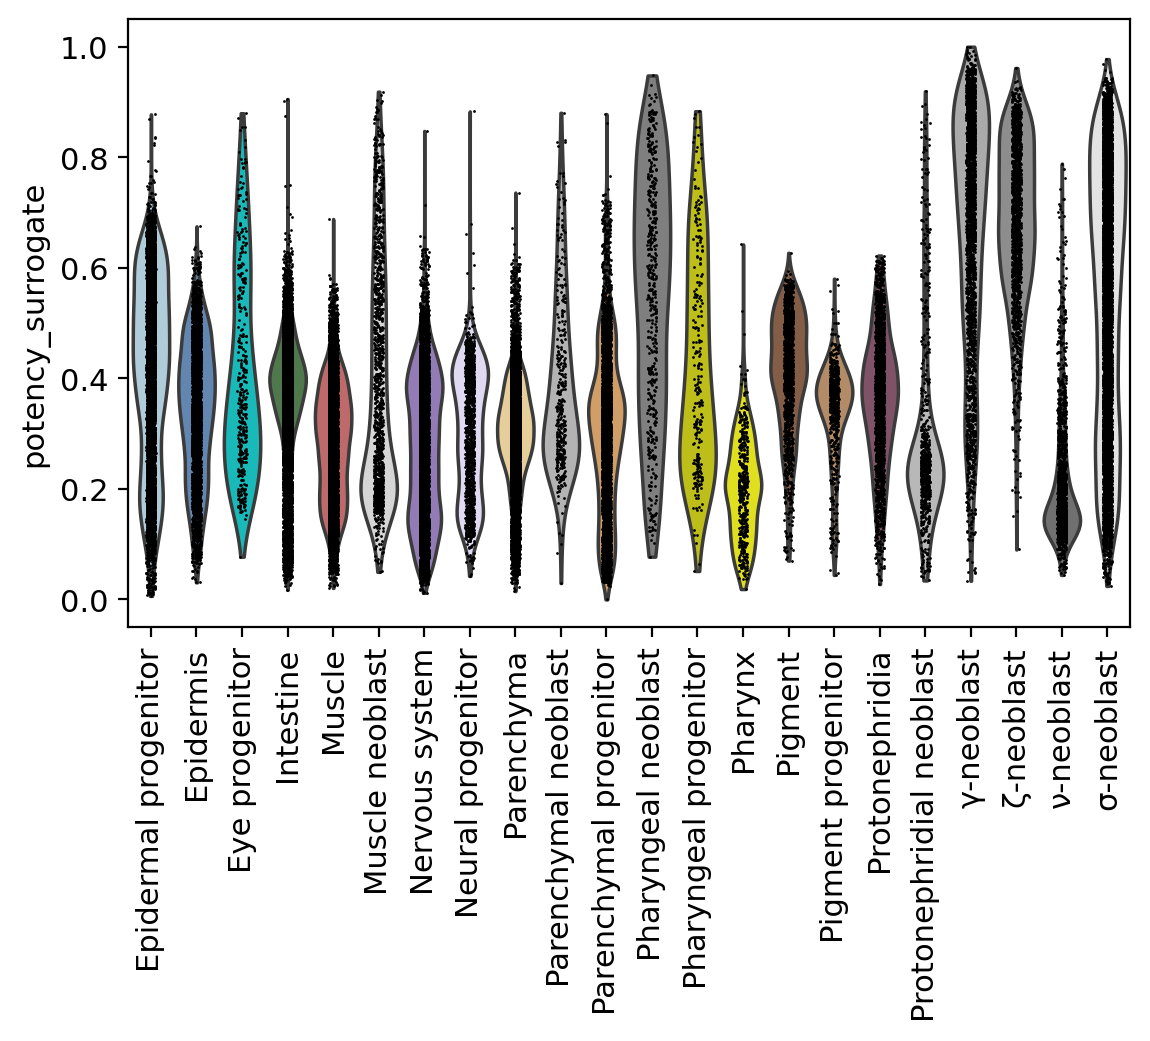

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity embed

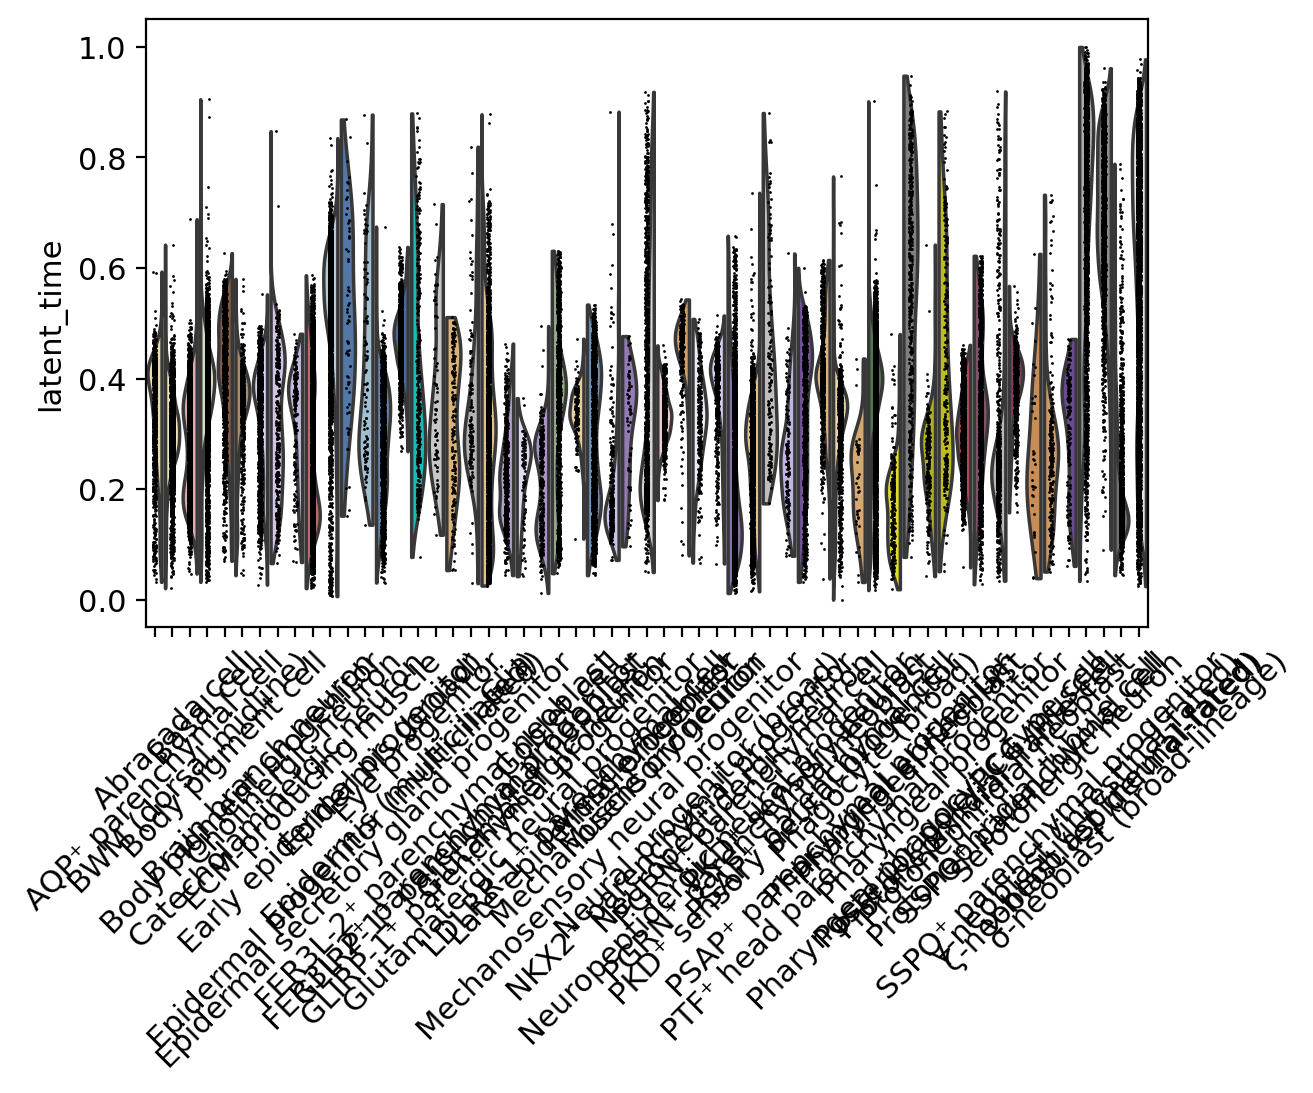

In [23]:
# === V1_correct: RNA velocity + latent time + potency surrogate ====================

VEL = CACHE / "adata_velocity.h5ad"

if VEL.exists():
    adata_vel = sc.read_h5ad(VEL)
else:
    # Start from the merged object but reset X to raw spliced counts
    adata_vel = adata.copy()
    ensure_float32_layers(adata_vel, layers=("spliced", "unspliced"))

    # Use spliced counts as X for scVelo preprocessing
    adata_vel.X = adata_vel.layers["spliced"].copy()

    # Standard scVelo preprocessing (counts -> normalized/log1p, moments)
    scv.pp.filter_and_normalize(
        adata_vel,
        min_shared_counts=MIN_SHARED_COUNTS,
        n_top_genes=N_TOP_GENES,
        # use default layer handling: operates on X and 'spliced'/'unspliced'
    )
    scv.pp.moments(adata_vel, n_pcs=30, n_neighbors=30)

    # Dynamical model so that latent_time is defined
    # (this is heavier, but what scVelo uses in the Plass 2018-type analyses)
    scv.tl.recover_dynamics(adata_vel)          # you can pass n_jobs=.. if desired
    scv.tl.velocity(adata_vel, mode="dynamical")
    scv.tl.velocity_graph(adata_vel)
    scv.tl.terminal_states(adata_vel)
    scv.tl.velocity_pseudotime(adata_vel)
    scv.tl.latent_time(adata_vel)

    # Make sure UMAP basis is the fixed Seurat UMAP
    idx = adata.obs_names.get_indexer(adata_vel.obs_names)
    adata_vel.obsm["X_umap"] = adata.obsm["X_umap_seurat"][idx, :]

    adata_vel.write(VEL)

# -------------------------------------------------------------------------
# Propagate velocity-based time metrics back to the main AnnData
# -------------------------------------------------------------------------
# join keeps cond/timepoint and celltype_family already present in adata.obs
cols = ["velocity_pseudotime", "latent_time"]

# Drop any stale versions
for c in cols:
    if c in adata.obs:
        del adata.obs[c]

# Overwrite from adata_vel, aligned by index
adata.obs[cols] = adata_vel.obs.loc[adata.obs_names, cols].to_numpy()


# Potency surrogate (Plass-style: early cells high potency, late cells low)
#lt = adata.obs["latent_time"].to_numpy()
#lt_min = np.nanmin(lt)
#lt_max = np.nanmax(lt)
#pot   = 1.0 - (lt - lt_min) / (lt_max - lt_min + 1e-9)
#adata.obs["potency_surrogate"] = pot
# -------------------------------------------------------------------------
# Re-orient potency so σ-neoblast is high-potency
# -------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Ensure numeric latent_time on adata_vel
adata_vel.obs["latent_time"] = pd.to_numeric(
    adata_vel.obs["latent_time"], errors="coerce"
)

lt = adata_vel.obs["latent_time"].to_numpy()
lt_min = np.nanmin(lt)
lt_max = np.nanmax(lt)
t_scaled = (lt - lt_min) / (lt_max - lt_min + 1e-9)   # in [0, 1]

fam = adata_vel.obs["celltype_family"].astype("category")
root_family = "σ-neoblast"

if root_family in list(fam.cat.categories):
    root_mask = (fam == root_family).to_numpy()
    root_mean = np.nanmean(t_scaled[root_mask])
else:
    root_mean = np.nan  # fallback if σ-neoblast not present

# Decide orientation:
# - if σ-neoblast already early (<= 0.5), potency = 1 - t_scaled
# - if σ-neoblast late      (>  0.5), potency = t_scaled
if np.isnan(root_mean) or root_mean <= 0.5:
    cell_pot = 1.0 - t_scaled
else:
    cell_pot = t_scaled

# Store per-cell potency in both velocity and main objects
adata_vel.obs["potency_surrogate"] = cell_pot
adata.obs["potency_surrogate"] = adata_vel.obs.loc[
    adata.obs_names, "potency_surrogate"
].to_numpy()

sc.pl.violin(
    adata,
    keys="potency_surrogate",
    groupby="celltype_family",
    rotation=90
)


family_mean_pot = (
    adata.obs[["celltype_family", "potency_surrogate"]]
    .groupby("celltype_family")["potency_surrogate"]
    .mean()
)

fmin, fmax = family_mean_pot.min(), family_mean_pot.max()
family_pot_norm = (family_mean_pot - fmin) / (fmax - fmin + 1e-9)

adata.obs["family_potency_norm"] = (
    adata.obs["celltype_family"].map(family_pot_norm).astype(float)
)

# -------------------------------------------------------------------------
# Helper: subset velocity object by condition/timepoint and subset graph
# -------------------------------------------------------------------------
import numpy as np
import scipy.sparse as sp

def subset_velocity_by_cond_tp(adata_vel, cond=None, tp=None):
    mask = np.ones(adata_vel.n_obs, dtype=bool)
    if cond is not None:
        mask &= (adata_vel.obs["cond"].values == cond)
    if tp is not None:
        mask &= (adata_vel.obs["timepoint"].values == tp)

    sub = adata_vel[mask, :].copy()
    if sub.n_obs == 0:
        return sub

    idx = np.where(mask)[0]

    # subset velocity_graph (and the negative/transition variants if present)
    for key in ["velocity_graph", "velocity_graph_neg", "velocity_graph_diff"]:
        if key in adata_vel.uns:
            G = adata_vel.uns[key]
            if sp.issparse(G):
                sub.uns[key] = G[idx[:, None], idx].tocsr()
            else:
                sub.uns[key] = G[np.ix_(idx, idx)]

    # UMAP basis is already per-cell, slicing handled by AnnData
    return sub

# -------------------------------------------------------------------------
# Velocity plots – per condition & timepoint, using Seurat UMAP as basis
# -------------------------------------------------------------------------
import matplotlib.pyplot as plt

def plot_velocity_grid_per_cond_tp(color_key="celltype",
                                   density=0.7,
                                   arrow_size=1.0,
                                   arrow_length=1.0,
                                   linewidth=0.7):
    for tp in TP_ORDER:
        for cond in COND_ORDER:
            sub = subset_velocity_by_cond_tp(adata_vel, cond=cond, tp=tp)
            if sub.n_obs == 0:
                continue

            # Ensure color key exists
            if color_key not in sub.obs.columns:
                continue

            ax = scv.pl.velocity_embedding_grid(
                sub,
                basis="umap",
                color=color_key,
                density=density,
                arrow_size=arrow_size,
                arrow_length=arrow_length,
                linewidth=linewidth,
                min_mass=1.0,
                show=False,
                legend_loc="right margin",
            )
            fig = ax.get_figure()
            fig.savefig(
                PLOTS / f"velocity_grid_{color_key}_umap_seurat_{cond}_{tp}.pdf",
                dpi=300,
                bbox_inches="tight"
            )
            plt.close(fig)

# Per-condition & timepoint grids, by detailed celltype and by family
plot_velocity_grid_per_cond_tp(color_key="celltype")
plot_velocity_grid_per_cond_tp(color_key="celltype_family")

# -------------------------------------------------------------------------
# Latent time distributions (robustness check: pile-up or shift per cond/tp)
# -------------------------------------------------------------------------
sc.pl.violin(
    adata,
    keys="latent_time",
    groupby="celltype",
    split="timepoint",
    rotation=45
)


In [24]:
# -------------------------------------------------------------------------
# Persist velocity / potency state to disk
# -------------------------------------------------------------------------

# 1) Update the velocity object on disk (even if VEL existed before)
#    so that it always contains the latest potency_surrogate, etc.
adata_vel.write(VEL)

# 2) Save a main AnnData snapshot with velocity-derived metrics baked in
FULL = CACHE / "adata_with_velocity_potency.h5ad"
adata.write(FULL)
print(f"[info] Saved velocity object to: {VEL}")
print(f"[info] Saved full annotated object to: {FULL}")


[info] Saved velocity object to: cache/adata_velocity.h5ad
[info] Saved full annotated object to: cache/adata_with_velocity_potency.h5ad


In [27]:
# === CELL P8: template positions + FA2 layout + degree floor (using cleaned global geometry) ===
from fa2 import ForceAtlas2
import networkx as nx
import scipy.sparse as sp

# keys Scanpy expects (or set these to your chosen keys)
NEIGH_CONN_KEY = "connectivities"
NEIGH_DIST_KEY = "distances"

# sanity checks
assert GLOBAL_ADJ.shape == (adata.n_obs, adata.n_obs)
assert GLOBAL_DIST.shape == (adata.n_obs, adata.n_obs)

# store the matrices on the *global* adata (so they persist)
adata.obsp[NEIGH_CONN_KEY] = GLOBAL_ADJ.tocsr() if sp.issparse(GLOBAL_ADJ) else sp.csr_matrix(GLOBAL_ADJ)
adata.obsp[NEIGH_DIST_KEY] = GLOBAL_DIST.tocsr() if sp.issparse(GLOBAL_DIST) else sp.csr_matrix(GLOBAL_DIST)


def infer_n_neighbors_from_connectivities(C):
    # median number of nonzeros per row, minus diagonal if present
    if sp.issparse(C):
        nnz = C.getnnz(axis=1)
        diag = C.diagonal()
    else:
        nnz = np.count_nonzero(C, axis=1)
        diag = np.diag(C)

    has_diag = np.nanmedian(diag) > 0
    k = int(np.nanmedian(nnz - (1 if has_diag else 0)))
    return max(k, 1)

k_infer = infer_n_neighbors_from_connectivities(adata.obsp[NEIGH_CONN_KEY])

# Minimal neighbors metadata Scanpy needs
adata.uns.setdefault("neighbors", {})
adata.uns["neighbors"]["connectivities_key"] = NEIGH_CONN_KEY
adata.uns["neighbors"]["distances_key"] = NEIGH_DIST_KEY
adata.uns["neighbors"].setdefault("params", {})
adata.uns["neighbors"]["params"].setdefault("n_neighbors", k_infer)
# create the minimal neighbors metadata if missing
if "neighbors" not in adata.uns:
    adata.uns["neighbors"] = {}
adata.uns["neighbors"]["connectivities_key"] = NEIGH_CONN_KEY
adata.uns["neighbors"]["distances_key"] = NEIGH_DIST_KEY
adata.uns["neighbors"].setdefault("params", {})

def _subset_neighbors_from_global(sub: ad.AnnData):
    idx = adata.obs_names.get_indexer(sub.obs_names)
    if np.any(idx < 0):
        raise ValueError("Some subset obs_names are not present in the global adata.")

    sub.obsp[NEIGH_CONN_KEY] = adata.obsp[NEIGH_CONN_KEY][idx[:, None], idx].tocsr()
    sub.obsp[NEIGH_DIST_KEY] = adata.obsp[NEIGH_DIST_KEY][idx[:, None], idx].tocsr()

    # Always write a valid neighbors dict (with n_neighbors)
    sub.uns["neighbors"] = {
        "connectivities_key": NEIGH_CONN_KEY,
        "distances_key": NEIGH_DIST_KEY,
        "params": dict(adata.uns.get("neighbors", {}).get("params", {})),
    }
    sub.uns["neighbors"]["params"].setdefault("n_neighbors", adata.uns["neighbors"]["params"]["n_neighbors"])


def _paga_compute(sub: ad.AnnData, groups: str) -> sp.csr_matrix:
    _subset_neighbors_from_global(sub)
    sc.tl.paga(sub, groups=groups)
    C = sub.uns["paga"]["connectivities"].tocsr(copy=True)
    C = C.maximum(C.T)
    C.setdiag(0.0); C.eliminate_zeros()
    return C

def _ensure_min_degree(C: sp.csr_matrix, dmin: int) -> sp.csr_matrix:
    n = C.shape[0]
    C = C.tolil(copy=True)
    full = C.tocsr()
    for i in range(n):
        deg = C.getrow(i).nnz
        if deg >= dmin:
            continue
        neigh = full.getrow(i).toarray().ravel()
        cand = np.argsort(-neigh)
        for j in cand:
            if j == i or full[i, j] == 0 or C[i, j] != 0:
                continue
            C[i, j] = full[i, j]
            C[j, i] = full[i, j]
            deg += 1
            if deg >= dmin:
                break
    C = C.tocsr()
    C.setdiag(0.0); C.eliminate_zeros()
    return C

def _paga_prune(C: sp.csr_matrix, topk: int | None, q: float | None, keep_mst: bool, dmin: int | None) -> sp.csr_matrix:
    n = C.shape[0]
    keep = set()
    if topk and topk > 0:
        for i in range(n):
            row = C.getrow(i)
            if row.nnz == 0:
                continue
            idx, dat = row.indices, row.data
            k = min(topk, dat.size)
            top_idx = idx[np.argpartition(dat, -k)[-k:]]
            for j in top_idx:
                keep.add((min(i, j), max(i, j)))
    if q is not None:
        d = C.data
        d = d[d > 0]
        if d.size:
            thr = float(np.quantile(d, q))
            coo = C.tocoo()
            for i, j, w in zip(coo.row, coo.col, coo.data):
                if i != j and w >= thr:
                    keep.add((min(i, j), max(i, j)))
    if keep_mst and C.nnz > 0:
        G = nx.Graph()
        coo = C.tocoo()
        for i, j, w in zip(coo.row, coo.col, coo.data):
            if i != j:
                G.add_edge(i, j, weight=1.0 / (w + 1e-9))
        T = nx.minimum_spanning_tree(G, weight="weight")
        keep |= {(min(u, v), max(u, v)) for u, v in T.edges()}
    rows, cols, vals = [], [], []
    for (i, j) in keep:
        w = C[i, j]
        if w > 0:
            rows += [i, j]; cols += [j, i]; vals += [w, w]
    C2 = sp.csr_matrix((vals, (rows, cols)), shape=C.shape)
    C2.setdiag(0.0); C2.eliminate_zeros()
    if dmin and dmin > 0:
        C2 = _ensure_min_degree(C2, dmin=dmin)
    return C2

def _fa2_layout(C: sp.csr_matrix,
                seed_xy: np.ndarray,
                iters=1000,
                gravity=1.0,
                scaling_ratio=2.0) -> np.ndarray:
    fa = ForceAtlas2(
        outboundAttractionDistribution=False,
        linLogMode=False,
        adjustSizes=False,
        edgeWeightInfluence=1.0,
        jitterTolerance=0.2,
        barnesHutOptimize=True,
        barnesHutTheta=1.2,
        scalingRatio=scaling_ratio,
        strongGravityMode=False,
        gravity=gravity,
        verbose=False,
    )
    M = C.tolil().astype(np.float32)
    P = fa.forceatlas2(M, pos=seed_xy.astype(np.float32), iterations=iters)
    return np.asarray(P, dtype=float)

def _umap_centroids(sub: ad.AnnData, groups: str) -> tuple[np.ndarray, list[str]]:
    cats = list(sub.obs[groups].cat.categories)
    XY = pd.DataFrame(sub.obsm["X_umap"], index=sub.obs_names, columns=["x","y"])
    cent = XY.join(sub.obs[groups]).groupby(groups)[["x","y"]].mean().reindex(cats).to_numpy()
    return cent, cats

def _build_template_positions(adx: ad.AnnData, groups: str, topk: int, q: float, dmin: int, keep_mst=True) -> dict[str, np.ndarray]:
    tmp = adx.copy()
    tmp.obsm["X_umap"] = tmp.obsm["X_umap_joint"].copy()  # use the joint UMAP already stored in tmp
    C = _paga_compute(tmp, groups)
    Cp = _paga_prune(C, topk=topk, q=q, keep_mst=keep_mst, dmin=dmin)
    seed, cats = _umap_centroids(tmp, groups)
    P = _fa2_layout(Cp, seed_xy=seed, iters=1000, gravity=1.0, scaling_ratio=2.0)
    return {cats[i]: P[i, :] for i in range(len(cats))}


# Build template positions once 
DET_TEMPLATE_POS = _build_template_positions(adata, "celltype",        topk=3, q=0.60, dmin=2)
FAM_TEMPLATE_POS = _build_template_positions(adata, "celltype_family", topk=2, q=0.40, dmin=1)

def _map_template_pos(sub: ad.AnnData, groups: str, template: dict[str, np.ndarray]) -> np.ndarray:
    cats = list(sub.obs[groups].cat.categories)
    seed, _ = _umap_centroids(sub, groups)
    out = np.zeros_like(seed)
    for i, c in enumerate(cats):
        out[i, :] = template.get(c, seed[i, :])
    return out



running PAGA
    finished (0:00:04)
running PAGA
    finished (0:00:02)


In [28]:
# === P9: PAGA graphs and overlays using Seurat UMAP templates =============
metric_key = "family_potency_norm"
MIN_PAGA_WEIGHT = 0.0  # graph sparsity controlled by _paga_prune, not here

def apply_bootstrap_to_Cpr(
    Cpr: sp.csr_matrix,
    sub: ad.AnnData,
    group: str,
    boot_mean: pd.Series,
    cond: str,
    tp: str,
    min_weight: float | None = None,
) -> sp.csr_matrix:
    """
    Replace PAGA edge weights in Cpr by bootstrap mean weights when available.

    - Cpr:       pruned adjacency (csr, symmetric) in group-category order
    - sub:       subset AnnData (one cond × timepoint)
    - group:     obs column with group labels ('celltype' or 'celltype_family')
    - boot_mean: Series indexed by (src, dst, cond, timepoint) -> mean weight
    - cond, tp:  current condition and timepoint

    We do not drop edges here. Graph sparsity is controlled upstream by
    _paga_prune (topk, q, MST, dmin). Any display thresholding is handled
    only in the plotting helpers via MIN_PAGA_WEIGHT.
    """
    cats = list(sub.obs[group].astype("category").cat.categories)
    if len(cats) == 0:
        return Cpr

    C = Cpr.tolil(copy=True)
    n = len(cats)

    # For each existing edge in C, try to replace with bootstrap mean
    for i in range(n):
        src = cats[i]
        row_idx = C.rows[i]
        row_dat = C.data[i]
        for k, j in enumerate(row_idx):
            if j <= i:
                continue
            if row_dat[k] <= 0:
                continue
            dst = cats[j]

            key     = (src, dst, cond, tp)
            key_sym = (dst, src, cond, tp)

            w_boot = None
            if key in boot_mean.index:
                w_boot = float(boot_mean.loc[key])
            elif key_sym in boot_mean.index:
                w_boot = float(boot_mean.loc[key_sym])

            if w_boot is not None:
                C[i, j] = w_boot
                C[j, i] = w_boot

    C = C.tocsr()
    C.setdiag(0.0)
    C.eliminate_zeros()
    return C


def _recolor_paga_edges(ax, color="0.6", alpha=0.9):
    for coll in ax.collections:
        if isinstance(coll, LineCollection):
            coll.set_color(color)
            coll.set_alpha(alpha)

def _paga_plot_with_template(
    sub: ad.AnnData,
    groups: str,
    template_pos: dict[str, np.ndarray],
    Cpruned: sp.csr_matrix,
    figsize=(18, 14),
    node_size_scale=8,
    edge_width_scale=0.8,
    fontsize=5,
    fname=None,
):
    C_orig = sub.uns["paga"]["connectivities"]

    # Thresholded copy for plotting
    Cplot = Cpruned.copy()
    Cplot.data[Cplot.data < MIN_PAGA_WEIGHT] = 0.0
    Cplot.eliminate_zeros()

    sub.uns["paga"]["connectivities"] = Cplot

    pos = _map_template_pos(sub, groups, template_pos)

    fig, ax = plt.subplots(figsize=figsize)
    sc.pl.paga(
        sub,
        pos=pos,
        frameon=False,
        threshold=0.0,
        node_size_scale=node_size_scale,
        node_size_power=0.6,
        edge_width_scale=edge_width_scale,
        fontsize=fontsize,
        ax=ax,
        show=False,
        save=False,
        title="",
    )
    _recolor_paga_edges(ax, "0.6", 0.9)

    # Edge-confidence legend based on Cplot
    from matplotlib.lines import Line2D

    Ccoo = Cplot.tocoo()
    mask = Ccoo.row < Ccoo.col
    edge_w = Ccoo.data[mask]

    if edge_w.size > 0:
        wmin = float(edge_w.min())
        wmax = float(edge_w.max())
        min_edge_width = 0.2
        max_edge_width = 4.0

        w_low  = wmin
        w_med  = float(np.median(edge_w))
        w_high = wmax
        if np.isclose(w_med, w_high) or np.isclose(w_med, w_low):
            w_med = w_low + 0.5 * (w_high - w_low)

        w_samples = [w_low, w_med, w_high]
        labels = [f"{w_low:.2f} (low)",
                  f"{w_med:.2f} (mid)",
                  f"{w_high:.2f} (high)"]

        def _map_width(w):
            if wmax > wmin:
                base = min_edge_width + (w - wmin) / (wmax - wmin) * (max_edge_width - min_edge_width)
            else:
                base = (min_edge_width + max_edge_width) * 0.5
            return edge_width_scale * base

        legend_elements = [
            Line2D([0], [0], color="0.6", linewidth=_map_width(w), label=lab)
            for w, lab in zip(w_samples, labels)
        ]

        ax.legend(
            handles=legend_elements,
            title="PAGA weight\n(edge confidence)",
            loc="upper right",
            frameon=True,
            fontsize=fontsize,
        )

    if fname:
        fig.savefig(PLOTS / fname, dpi=450, bbox_inches="tight")
        plt.close(fig)

    sub.uns["paga"]["connectivities"] = C_orig

def _paga_plot_metric_with_template(
    sub: ad.AnnData,
    groups: str,
    metric_key: str,
    template_pos: dict[str, np.ndarray],
    Cpruned: sp.csr_matrix,
    figsize=(16, 12),
    node_size_scale=8.0,
    edge_width_scale=0.8,
    fontsize=6,
    fname=None,
    cmap_name="viridis",
    min_edge_width=0.2,
    max_edge_width=4.0,
):
    """
    Custom PAGA plot where nodes are colored by the average of `metric_key`
    per group. Uses precomputed template positions and a pruned adjacency.

    - `groups`      : obs column with cluster labels (e.g. 'celltype')
    - `metric_key`  : obs column with continuous metric (e.g. 'latent_time')
    - `template_pos`: dict {group_label -> (x, y)} from DET/FAM_TEMPLATE_POS
    - `Cpruned`     : csr_matrix of shape (n_groups, n_groups) in category order
    """
    if metric_key not in sub.obs.columns:
        raise KeyError(f"{metric_key} not found in sub.obs")

    # Categories (node order) and template positions
    cats = list(sub.obs[groups].astype("category").cat.categories)
    if len(cats) == 0:
        return

    pos = _map_template_pos(sub, groups, template_pos)  # shape (n_nodes, 2)

    # Mean metric per group (node color)
    metric_mean = (
        sub.obs[[groups, metric_key]]
        .groupby(groups)[metric_key]
        .mean()
        .reindex(cats)
    )
    metric_vals = metric_mean.to_numpy()

    # Node sizes proportional to cell counts in each group
    counts = (
        sub.obs[groups]
        .value_counts()
        .reindex(cats)
        .fillna(0)
        .to_numpy()
    )
    # Avoid zeros to keep nodes visible
    counts = np.maximum(counts, 1.0)
    node_sizes = node_size_scale * np.sqrt(counts)

    # Edge list from pruned adjacency
    Ccoo = Cpruned.tocoo()
    edge_i = []
    edge_j = []
    edge_w = []
    for i, j, w in zip(Ccoo.row, Ccoo.col, Ccoo.data):
        if i >= j:
            continue  # plot each undirected edge once
        edge_i.append(i)
        edge_j.append(j)
        edge_w.append(w)
    edge_w = np.array(edge_w, dtype=float)
    if edge_w.size > 0:
        # Rescale edge weights to a sensible linewidth range
        wmin = edge_w.min()
        wmax = edge_w.max()
        if wmax > wmin:
            edge_widths = min_edge_width + (edge_w - wmin) / (wmax - wmin) * (max_edge_width - min_edge_width)
        else:
            edge_widths = np.full_like(edge_w, (min_edge_width + max_edge_width) * 0.5)
    else:
        edge_widths = np.array([])

    # Plot
    fig, ax = plt.subplots(figsize=figsize)

    # Edges
    for (i, j, lw) in zip(edge_i, edge_j, edge_widths):
        x0, y0 = pos[i, 0], pos[i, 1]
        x1, y1 = pos[j, 0], pos[j, 1]
        ax.plot(
            [x0, x1],
            [y0, y1],
            color="0.6",
            alpha=0.9,
            linewidth=edge_width_scale * lw,
            zorder=1,
        )

    # Nodes (colored by metric)
    cmap = plt.get_cmap(cmap_name)
    sc_nodes = ax.scatter(
        pos[:, 0],
        pos[:, 1],
        c=metric_vals,
        cmap=cmap,
        s=node_sizes,
        edgecolor="black",
        linewidths=0.3,
        zorder=2,
    )

    # Labels
    for k, lbl in enumerate(cats):
        ax.text(
            pos[k, 0],
            pos[k, 1],
            str(lbl),
            fontsize=fontsize,
            ha="center",
            va="center",
            zorder=3,
        )

    # Colorbar
    cbar = plt.colorbar(sc_nodes, ax=ax)
    cbar.set_label(metric_key)

    ax.set_aspect("equal")
    ax.set_axis_off()
    ax.set_title(f"{groups} – {metric_key}", fontsize=fontsize + 1)

    if fname is not None:
        fig.savefig(PLOTS / fname, dpi=450, bbox_inches="tight")
        plt.close(fig)
    else:
        plt.show()

def _paga_overlay_with_template(
    sub: ad.AnnData,
    groups: str,
    template_pos: dict[str, np.ndarray],
    Cpruned: sp.csr_matrix,
    point_size=3,
    point_alpha=0.12,
    figsize=(18, 14),
    node_size_scale=8,
    edge_width_scale=0.8,
    fontsize=5,
    fname=None,
):
    C_orig = sub.uns["paga"]["connectivities"]

    # Use thresholded copy of Cpruned for plotting
    Cplot = Cpruned.copy()
    Cplot.data[Cplot.data < MIN_PAGA_WEIGHT] = 0.0
    Cplot.eliminate_zeros()

    sub.uns["paga"]["connectivities"] = Cplot

    pos = _map_template_pos(sub, groups, template_pos)

    fig, ax = plt.subplots(figsize=figsize)
    sc.pl.umap(
        sub,
        color=groups,
        alpha=point_alpha,
        size=point_size,
        frameon=False,
        show=False,
        title="",
        ax=ax,
    )
    sc.pl.paga(
        sub,
        pos=pos,
        frameon=False,
        threshold=0.0,   # already thresholded via Cplot
        node_size_scale=node_size_scale,
        node_size_power=0.6,
        edge_width_scale=edge_width_scale,
        fontsize=fontsize,
        ax=ax,
        show=False,
        save=False,
        title="",
    )
    _recolor_paga_edges(ax, "0.6", 0.9)

    # Edge-confidence legend based on Cplot
    from matplotlib.lines import Line2D

    Ccoo = Cplot.tocoo()
    mask = Ccoo.row < Ccoo.col
    edge_w = Ccoo.data[mask]

    if edge_w.size > 0:
        wmin = float(edge_w.min())
        wmax = float(edge_w.max())
        min_edge_width = 0.2
        max_edge_width = 4.0

        w_low  = wmin
        w_med  = float(np.median(edge_w))
        w_high = wmax
        if np.isclose(w_med, w_high) or np.isclose(w_med, w_low):
            w_med = w_low + 0.5 * (w_high - w_low)

        w_samples = [w_low, w_med, w_high]
        labels = [f"{w_low:.2f} (low)",
                  f"{w_med:.2f} (mid)",
                  f"{w_high:.2f} (high)"]

        def _map_width(w):
            if wmax > wmin:
                base = min_edge_width + (w - wmin) / (wmax - wmin) * (max_edge_width - min_edge_width)
            else:
                base = (min_edge_width + max_edge_width) * 0.5
            return edge_width_scale * base

        legend_elements = [
            Line2D([0], [0], color="0.6", linewidth=_map_width(w), label=lab)
            for w, lab in zip(w_samples, labels)
        ]

        ax.legend(
            handles=legend_elements,
            title="PAGA weight\n(edge confidence)",
            loc="upper right",
            frameon=True,
            fontsize=fontsize,
        )

    if fname:
        fig.savefig(PLOTS / fname, dpi=450, bbox_inches="tight")
        plt.close(fig)

    sub.uns["paga"]["connectivities"] = C_orig

# -------------------------------------------------------------------------
# Detailed cell types
# -------------------------------------------------------------------------
for tp in TP_ORDER:
    for cond in COND_ORDER:
        sub = _subset(adata, cond=cond, tp=tp)
        if sub.n_obs == 0 or sub.obs["celltype"].nunique() < 2:
            continue

        apply_palette(sub, "celltype", DETAILED_COLS, strict=False)
        _subset_neighbors_from_global(sub)
        sc.tl.paga(sub, groups="celltype")  # undirected, topology only

        C = sub.uns["paga"]["connectivities"].tocsr().maximum(
            sub.uns["paga"]["connectivities"].T
        ).tocsr()
        C.setdiag(0.0)
        C.eliminate_zeros()
        Cpr = _paga_prune(C, topk=3, q=0.60, keep_mst=True, dmin=2)
        # replace PAGA weights by bootstrap mean weights and threshold
        #Cpr = apply_bootstrap_to_Cpr(
        #    Cpr,
        #    sub,
        #    group="celltype",
        #    boot_mean=boot_mean_cell,
        #    cond=cond,
        #    tp=tp,
        #    min_weight=MIN_PAGA_WEIGHT,        
        #)

        # PAGA graph and overlay (cells colored by celltype)
        _paga_plot_with_template(
            sub,
            "celltype",
            DET_TEMPLATE_POS,
            Cpr,
            figsize=(20, 16),
            node_size_scale=20,
            edge_width_scale=0.9,
            fontsize=12,
            fname=f"PAGA_GRAPH_celltype_tpl_top3_q60_{cond}_{tp}.pdf",
        )
        _paga_overlay_with_template(
            sub,
            "celltype",
            DET_TEMPLATE_POS,
            Cpr,
            figsize=(20, 16),
            node_size_scale=20,
            edge_width_scale=0.9,
            fontsize=12,
            fname=f"PAGA_OVERLAY_celltype_tpl_top3_q60_{cond}_{tp}.pdf",
        )

        # PAGA colored by latent time and potency (per node = mean over cells)
        if "latent_time" in sub.obs.columns:
            _paga_plot_metric_with_template(
                sub,
                "celltype",
                "latent_time",
                DET_TEMPLATE_POS,
                Cpr,
                figsize=(20, 16),
                node_size_scale=20,
                edge_width_scale=0.9,
                fontsize=12,
                fname=f"PAGA_LATENTTIME_celltype_tpl_{cond}_{tp}.pdf",
            )
        if "potency_surrogate" in sub.obs.columns:
            _paga_plot_metric_with_template(
                sub,
                "celltype",
                "potency_surrogate",
                DET_TEMPLATE_POS,
                Cpr,
                figsize=(20, 16),
                node_size_scale=20,
                edge_width_scale=0.9,
                fontsize=12,
                fname=f"PAGA_POTENCY_celltype_tpl_{cond}_{tp}.pdf",
            )

# -------------------------------------------------------------------------
# Families
# -------------------------------------------------------------------------
for tp in TP_ORDER:
    for cond in COND_ORDER:
        sub = _subset(adata, cond=cond, tp=tp)
        if sub.n_obs == 0 or sub.obs["celltype_family"].nunique() < 2:
            continue

        apply_palette(sub, "celltype_family", FAMILY_COLORS, strict=False)
        _subset_neighbors_from_global(sub)
        sc.tl.paga(sub, groups="celltype_family")

        C = sub.uns["paga"]["connectivities"].tocsr().maximum(
            sub.uns["paga"]["connectivities"].T
        ).tocsr()
        C.setdiag(0.0)
        C.eliminate_zeros()
        Cpr = _paga_prune(C, topk=2, q=0.40, keep_mst=True, dmin=1)
        #Cpr = apply_bootstrap_to_Cpr(
        #    Cpr,
        #    sub,
        #    group="celltype_family",
        #    boot_mean=boot_mean_fam,
        #    cond=cond,
        #    tp=tp,
        #    min_weight=MIN_PAGA_WEIGHT,
        #)
        _paga_plot_with_template(
            sub,
            "celltype_family",
            FAM_TEMPLATE_POS,
            Cpr,
            figsize=(16, 12),
            node_size_scale=20,
            edge_width_scale=0.8,
            fontsize=12,
            fname=f"PAGA_GRAPH_family_tpl_top2_q40_{cond}_{tp}.pdf",
        )
        _paga_overlay_with_template(
            sub,
            "celltype_family",
            FAM_TEMPLATE_POS,
            Cpr,
            figsize=(16, 12),
            node_size_scale=20,
            edge_width_scale=0.8,
            fontsize=12,
            fname=f"PAGA_OVERLAY_family_tpl_top2_q40_{cond}_{tp}.pdf",
        )

        if "latent_time" in sub.obs.columns:
            _paga_plot_metric_with_template(
                sub,
                "celltype_family",
                "latent_time",
                FAM_TEMPLATE_POS,
                Cpr,
                figsize=(16, 12),
                node_size_scale=20,
                edge_width_scale=0.8,
                fontsize=12,
                fname=f"PAGA_LATENTTIME_family_tpl_{cond}_{tp}.pdf",
            )
        if "potency_surrogate" in sub.obs.columns:
            _paga_plot_metric_with_template(
                sub,
                "celltype_family",
                "potency_surrogate",
                FAM_TEMPLATE_POS,
                Cpr,
                figsize=(16, 12),
                node_size_scale=20,
                edge_width_scale=0.8,
                fontsize=12,
                fname=f"PAGA_POTENCY_family_tpl_{cond}_{tp}.pdf",
            )


running PAGA
    finished (0:00:00)
running PAGA
    finished (0:00:00)
running PAGA
    finished (0:00:00)
running PAGA
    finished (0:00:00)
running PAGA
    finished (0:00:00)
running PAGA
    finished (0:00:00)
running PAGA
    finished (0:00:00)
running PAGA
    finished (0:00:00)
running PAGA
    finished (0:00:00)
running PAGA
    finished (0:00:00)
running PAGA
    finished (0:00:00)
running PAGA
    finished (0:00:00)
running PAGA
    finished (0:00:00)
running PAGA
    finished (0:00:00)
running PAGA
    finished (0:00:00)
running PAGA
    finished (0:00:00)
running PAGA
    finished (0:00:00)
running PAGA
    finished (0:00:00)
running PAGA
    finished (0:00:00)
running PAGA
    finished (0:00:00)
running PAGA
    finished (0:00:00)
running PAGA
    finished (0:00:00)
running PAGA
    finished (0:00:00)
running PAGA
    finished (0:00:00)


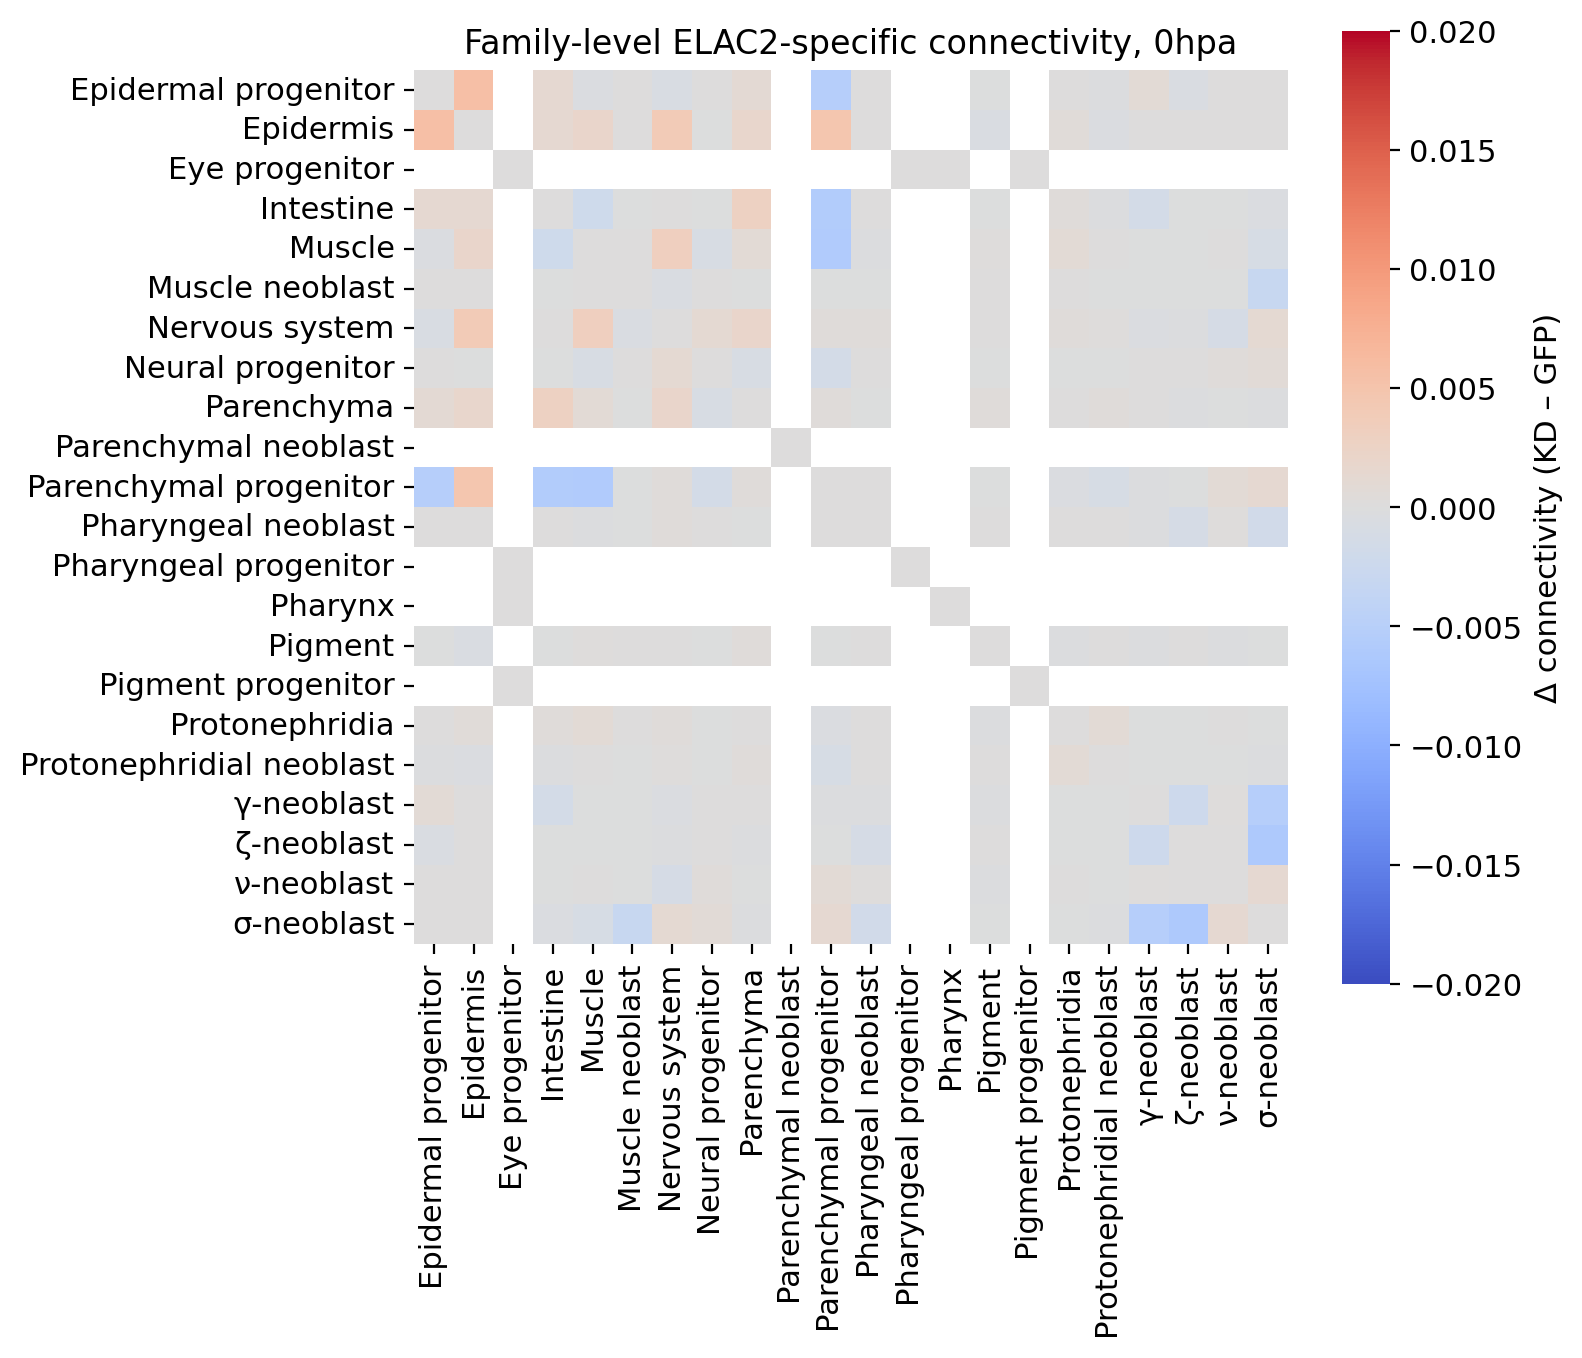

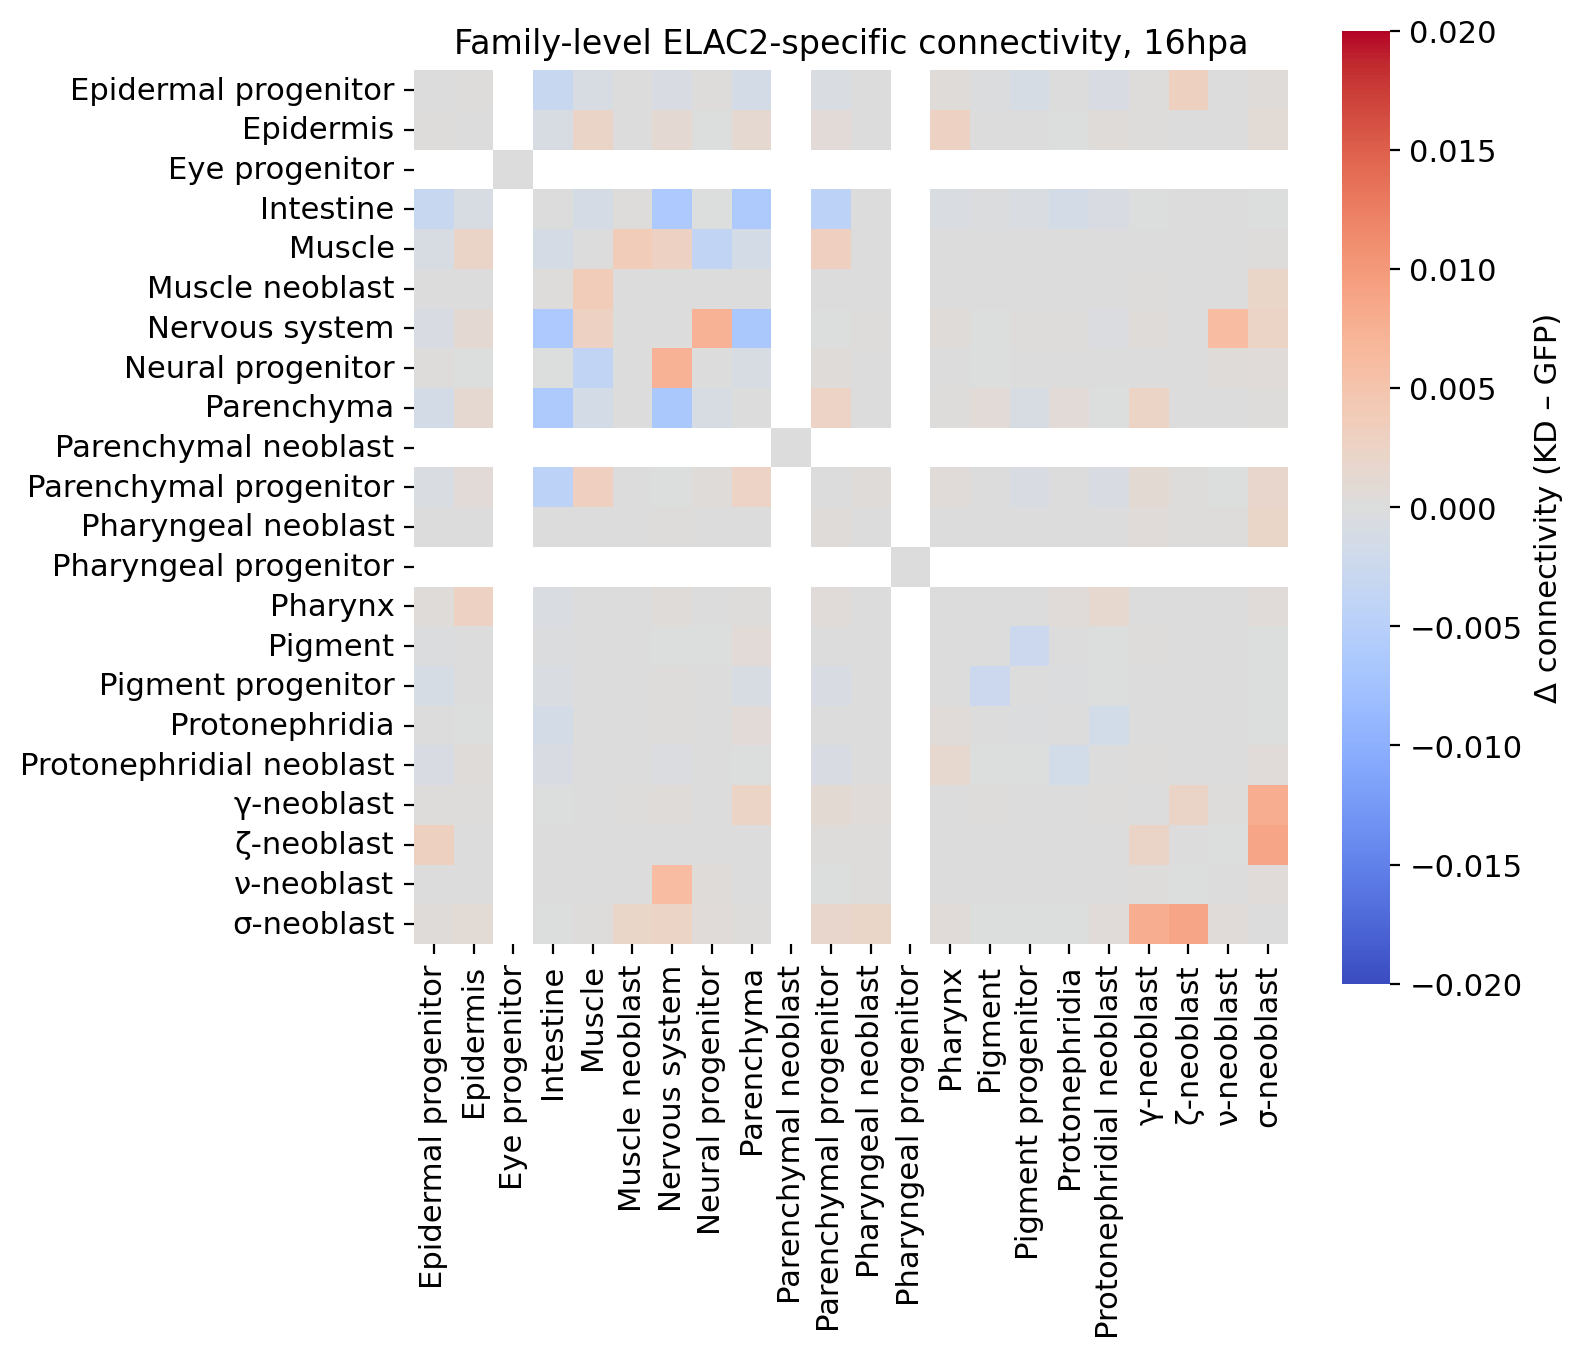

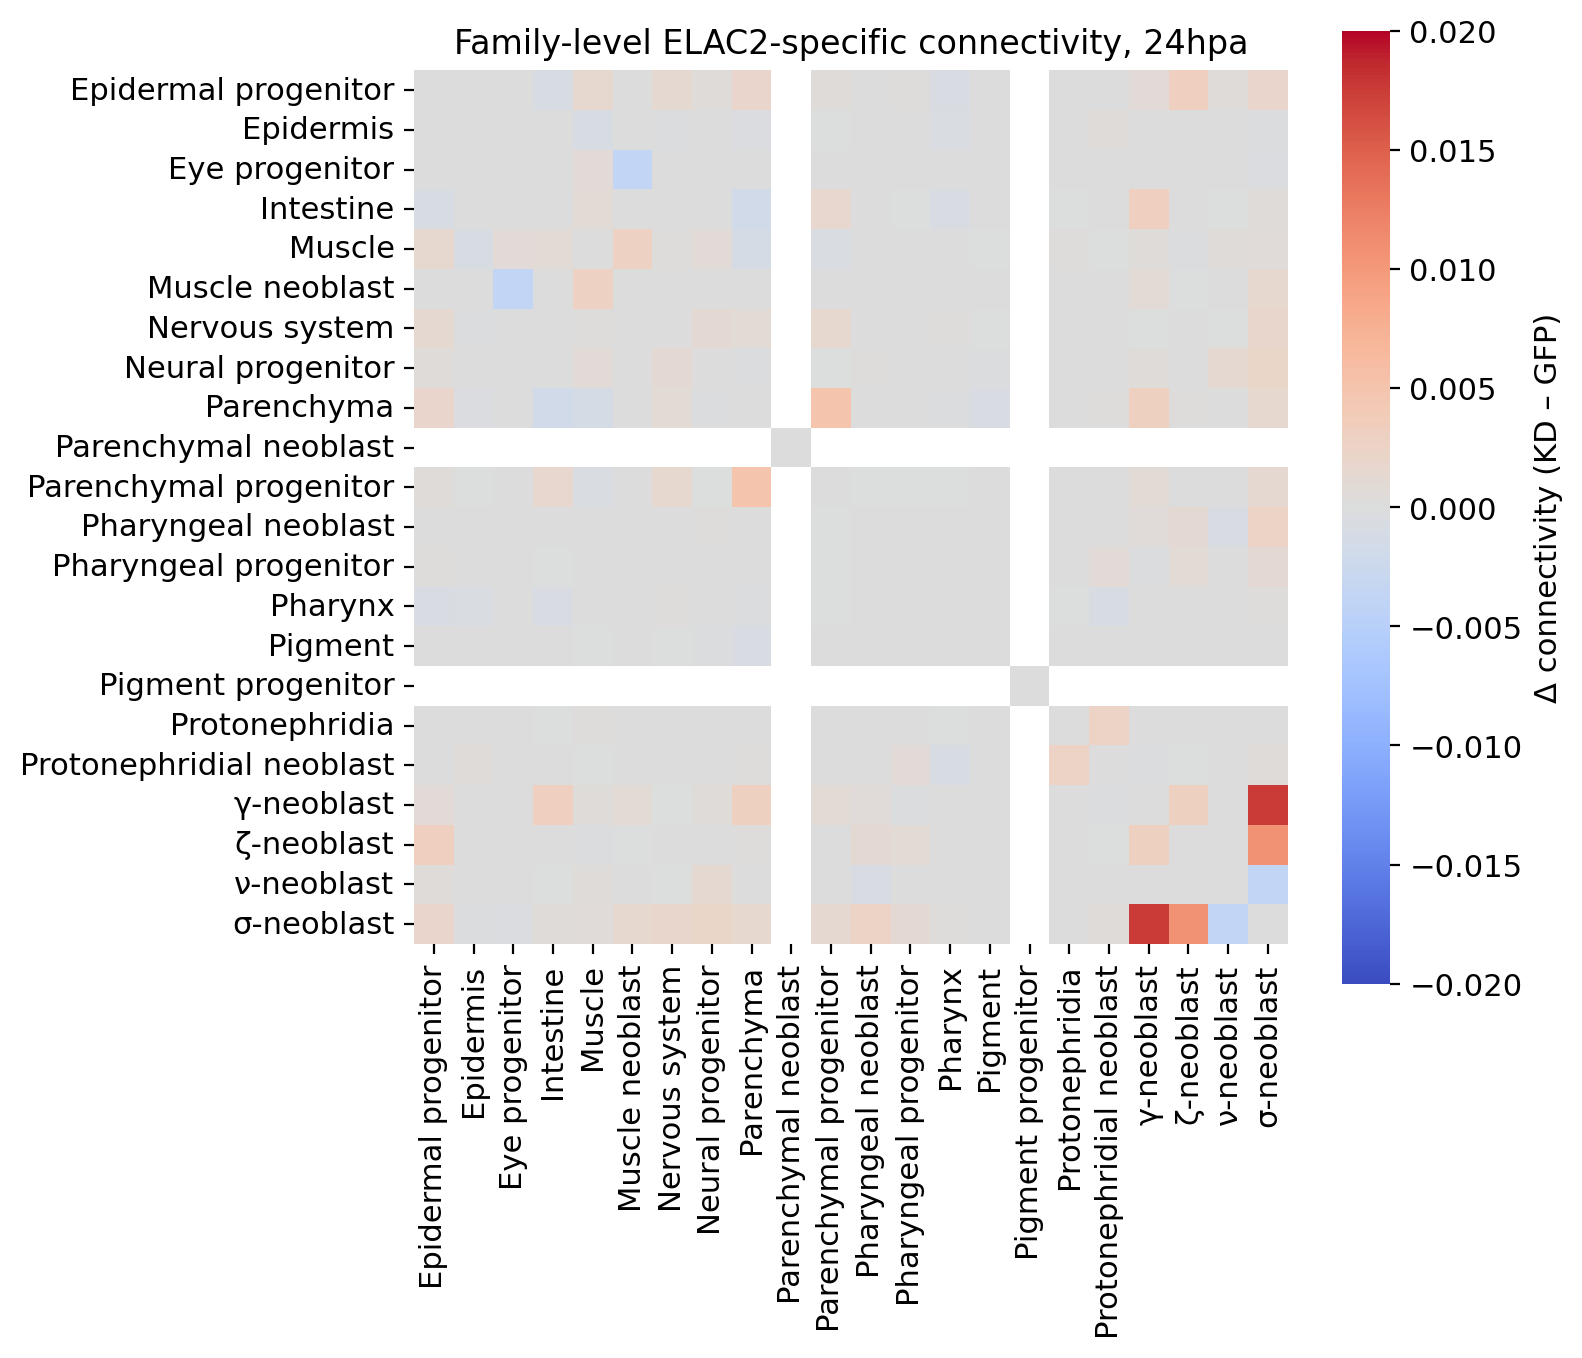

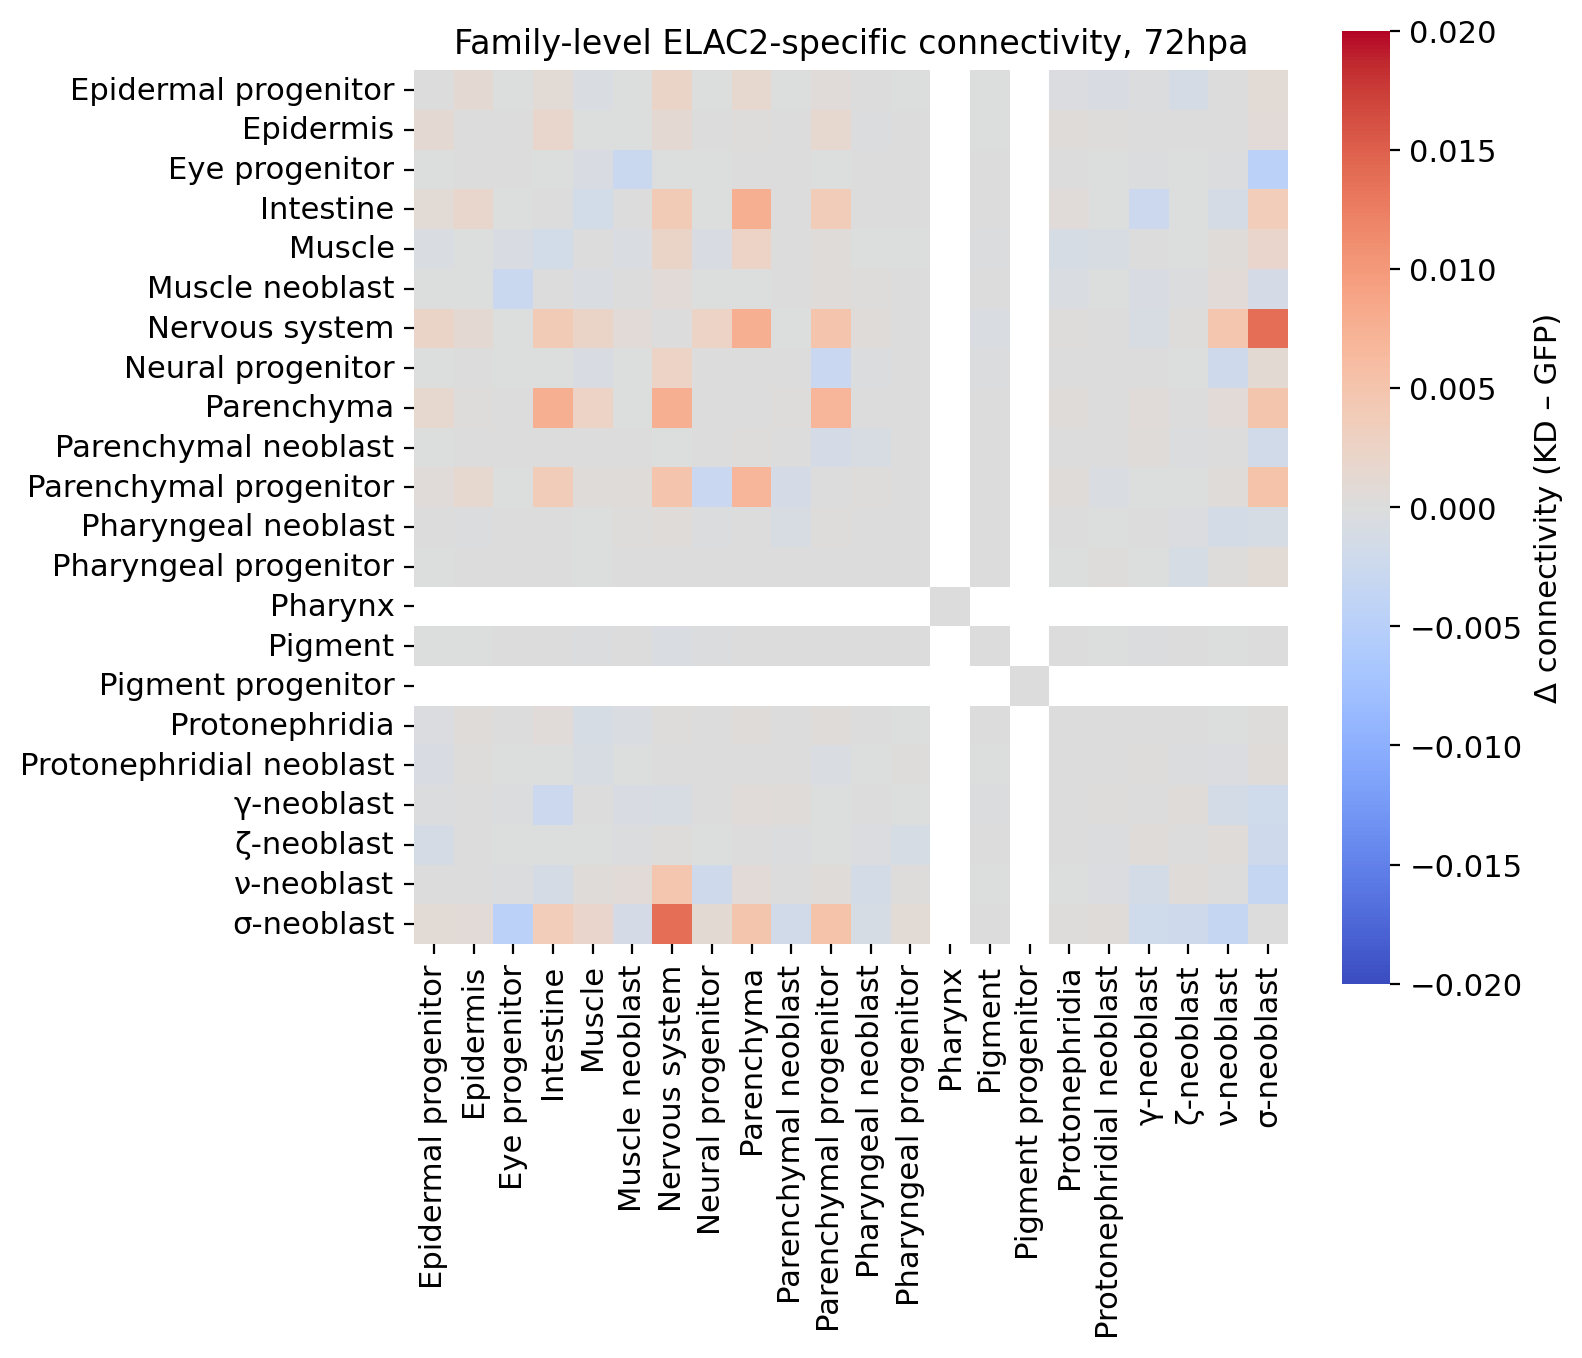

In [29]:
import pandas as pd

fam_long = pd.read_csv("cache/paga_EDGE_ELAC2_specific_long_family.csv")
cell_long = pd.read_csv("cache/paga_EDGE_ELAC2_specific_long_celltype.csv")

fam_delta = fam_long[fam_long["metric"] == "delta_ELAC2_specific"].copy()
cell_delta = cell_long[cell_long["metric"] == "delta_ELAC2_specific"].copy()

import seaborn as sns
import matplotlib.pyplot as plt

def plot_family_heatmap(fam_delta, tp, vlim=0.02):
    sub = fam_delta[fam_delta["timepoint"] == tp].copy()
    # build symmetric label set
    labels = sorted(set(sub["src"]) | set(sub["dst"]))
    mat = pd.DataFrame(0.0, index=labels, columns=labels)
    for _, row in sub.iterrows():
        mat.loc[row["src"], row["dst"]] = row["value"]
        mat.loc[row["dst"], row["src"]] = row["value"]  # symmetric

    plt.figure(figsize=(8, 7))
    sns.heatmap(
        mat, cmap="coolwarm", center=0,
        vmin=-vlim, vmax=vlim,
        square=True, cbar_kws={"label": "Δ connectivity (KD – GFP)"}
    )
    plt.title(f"Family-level ELAC2-specific connectivity, {tp}")
    plt.tight_layout()
    plt.savefig(f"plots/PAGA_family_heatmap_connectivity_{tp}.pdf", dpi=450, bbox_inches="tight"); 
    #plt.close()

for tp in ["0hpa", "16hpa", "24hpa", "72hpa"]:
    plot_family_heatmap(fam_delta, tp)



In [30]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations  # <-- FIX
from pathlib import Path

Path("plots").mkdir(parents=True, exist_ok=True)

TP_ORDER = ["0hpa", "16hpa", "24hpa", "72hpa"]
TP_RANK  = {tp: i for i, tp in enumerate(TP_ORDER)}

CONDS  = ["WT", "GFP", "ELAC2 KD"]
COLORS = ["#619CFF", "#00BA38", "#F8766D"]

# reconstruct wide pivot
fam_wide = (
    fam_long.pivot_table(
        index=["src", "dst", "timepoint"],
        columns="metric",
        values="value",
        aggfunc="mean",
    )
    .reset_index()
)

# ---------- pairing ----------
def all_pairs_from_df(df_wide: pd.DataFrame, drop_self: bool = True):
    nodes = sorted(set(df_wide["src"]).union(set(df_wide["dst"])))
    pairs = list(combinations(nodes, 2))
    if not drop_self:
        pairs += [(n, n) for n in nodes]
    return pairs

ALL_PAIRS = all_pairs_from_df(fam_wide, drop_self=True)

# ---------- safe filenames ----------
_GREEK_ASCII = {"σ":"sigma","γ":"gamma","ν":"nu","ζ":"zeta","⁺":"plus","+":"plus"}

def _sanitize(s: str) -> str:
    s = str(s)
    for k, v in _GREEK_ASCII.items():
        s = s.replace(k, v)
    s = re.sub(r"[^\w]+", "_", s, flags=re.UNICODE).strip("_")
    return s or "NA"

# ---------- plotting ----------
def plot_edge_pairs_separately(
    df_wide: pd.DataFrame,
    edge_list,
    module_name: str,
    out_prefix: str,
    fill_missing: float | None = 0.0,  # set None for gaps (np.nan)
):
    available_conds = [c for c in CONDS if c in df_wide.columns]
    if not available_conds:
        raise ValueError(f"No condition columns found in df_wide. Expected one of: {CONDS}")

    for (a, b) in edge_list:
        sub = df_wide[
            ((df_wide["src"] == a) & (df_wide["dst"] == b)) |
            ((df_wide["src"] == b) & (df_wide["dst"] == a))
        ].copy()

        # IMPORTANT: for ALL combinations, most pairs will be absent -> you can either:
        #   (1) skip absent edges (current behavior), or
        #   (2) force-plot them as zeros across timepoints.
        #
        # If you truly want ALL combinations plotted even when absent, comment the next 2 lines
        # and keep the "sub_mean empty" handling below.
        if sub.empty:
            continue

        keep_cols = ["src", "dst", "timepoint"] + available_conds
        sub = sub[keep_cols]
        sub["tp_rank"] = sub["timepoint"].map(TP_RANK)
        sub = sub.sort_values("tp_rank")

        # mean per tp (in case duplicates)
        sub_mean = sub.groupby("timepoint", as_index=False)[available_conds].mean(numeric_only=True)

        fig, ax = plt.subplots(figsize=(6, 4))
        xs = np.arange(len(TP_ORDER))

        for cond, color in zip(available_conds, COLORS[:len(available_conds)]):
            ys = []
            for tp in TP_ORDER:
                row = sub_mean[sub_mean["timepoint"] == tp]
                if row.empty:
                    ys.append(np.nan if fill_missing is None else float(fill_missing))
                else:
                    val = row[cond].iloc[0]
                    ys.append(np.nan if (fill_missing is None and pd.isna(val)) else (float(fill_missing) if pd.isna(val) else float(val)))

            ys = np.asarray(ys, dtype=float)
            ax.plot(
                xs, ys,
                marker="o",
                linestyle="-",
                color=color,
                alpha=0.4 if cond != "ELAC2 KD" else 1.0,
                label=cond,
            )

        ax.set_xticks(xs)
        ax.set_xticklabels(TP_ORDER)
        ax.set_title(f"{module_name}: {a} - {b}")
        ax.set_xlabel("Timepoint")
        ax.set_ylabel("PAGA weight (connectivity)")
        ax.legend()
        fig.tight_layout()

        safe_a = _sanitize(a)
        safe_b = _sanitize(b)
        fig.savefig(f"plots/{out_prefix}_{safe_a}__{safe_b}.pdf", dpi=450, bbox_inches="tight")
        plt.close(fig)

# run: all combinations
plot_edge_pairs_separately(
    fam_wide,
    ALL_PAIRS,
    module_name="All family combinations (complete graph)",
    out_prefix="PAGA_family_edge_trajectory_ALLPAIRS",
    fill_missing=0.0,
)


In [37]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import fitz  # PyMuPDF
from matplotlib.ticker import MaxNLocator
# ----------------------------
# Settings
# ----------------------------
Path("plots").mkdir(parents=True, exist_ok=True)

TP_ORDER = ["0hpa", "16hpa", "24hpa", "72hpa"]
TP_RANK  = {tp: i for i, tp in enumerate(TP_ORDER)}

CONDS  = ["WT", "GFP", "ELAC2 KD"]
COLORS = ["#619CFF", "#00BA38", "#F8766D"]

# exact family names as they appear in fam_wide src/dst (adjust only if your labels differ)
SELECTED_PAIRS = [
    ("σ-neoblast", "Eye progenitor"),
    ("σ-neoblast", "Nervous system"),
    ("σ-neoblast", "Intestine"),
     ("σ-neoblast", "Parenchyma"),
    ("Intestine", "Nervous system"),
    ("Intestine", "Parenchyma"),
    ("Nervous system", "Parenchyma"),
    ("Parenchymal progenitor","Nervous system"),
    ("Parenchymal progenitor", "Parenchyma")
   
]

OUT_PREFIX = "PAGA_family_edge_trajectory_ALLPAIRS"
MODULE_NAME = "Selected family pairs"

# safe filenames (your previous logic)
_GREEK_ASCII = {"σ":"sigma","γ":"gamma","ν":"nu","ζ":"zeta","⁺":"plus","+":"plus"}

def _sanitize(s: str) -> str:
    s = str(s)
    for k, v in _GREEK_ASCII.items():
        s = s.replace(k, v)
    s = re.sub(r"[^\w]+", "_", s, flags=re.UNICODE).strip("_")
    return s or "NA"


def _plot_one_pair(
    df_wide: pd.DataFrame,
    a: str,
    b: str,
    out_pdf: Path,
    fill_missing: float | None = 0.0,   # set None to leave gaps
    ylim_mode: str = "tight",           # "tight" or "global"
    ymax_global: float | None = None,   # used only if ylim_mode="global"
    headroom: float = 0.05,             # 5% headroom
    nticks: int = 4,                    # fewer ticks for small panels
):
    """
    Plot one edge trajectory (a-b) across TP_ORDER for all available conditions,
    with consistent 9 pt fonts and controlled y-limits so the signal uses
    more of the panel height.

    ylim_mode:
      - "tight": per-plot y-limit based on the max across conditions/timepoints.
      - "global": fixed y-limit using ymax_global (recommended for comparability).
    """
    available_conds = [c for c in CONDS if c in df_wide.columns]
    if not available_conds:
        raise ValueError(f"No condition columns found in df_wide. Expected one of: {CONDS}")

    sub = df_wide[
        ((df_wide["src"] == a) & (df_wide["dst"] == b)) |
        ((df_wide["src"] == b) & (df_wide["dst"] == a))
    ].copy()

    if sub.empty:
        print("[skip missing edge]", a, "__", b)
        return False

    keep_cols = ["src", "dst", "timepoint"] + available_conds
    sub = sub[keep_cols]
    sub["tp_rank"] = sub["timepoint"].map(TP_RANK)
    sub = sub.sort_values("tp_rank")

    sub_mean = sub.groupby("timepoint", as_index=False)[available_conds].mean(numeric_only=True)

    with plt.rc_context({
        "font.size": 13,
        "axes.titlesize": 13,
        "axes.labelsize": 13,
        "xtick.labelsize": 13,
        "ytick.labelsize": 13,
        "legend.fontsize": 13,
    }):
        fig, ax = plt.subplots(figsize=(3.25, 3.75))

        xs = np.arange(len(TP_ORDER))

        ys_by_cond = []
        for cond, color in zip(available_conds, COLORS[:len(available_conds)]):
            ys = []
            for tp in TP_ORDER:
                row = sub_mean[sub_mean["timepoint"] == tp]
                if row.empty:
                    ys.append(np.nan if fill_missing is None else float(fill_missing))
                else:
                    val = row[cond].iloc[0]
                    if pd.isna(val):
                        ys.append(np.nan if fill_missing is None else float(fill_missing))
                    else:
                        ys.append(float(val))

            ys = np.asarray(ys, dtype=float)
            ys_by_cond.append(ys)

            ax.plot(
                xs, ys,
                marker="o",
                linestyle="-",
                linewidth=1.2,
                markersize=4.0,
                color=color,
                alpha=0.45 if cond != "ELAC2 KD" else 1.0,
                label=cond,
            )

        # X formatting
        ax.set_xticks(xs)
        ax.set_xticklabels(TP_ORDER)

        # Title/labels
        ax.set_title(f"{a} – {b}")
        ax.set_xlabel("Timepoint")
        ax.set_ylabel("PAGA weight")

        # ---- y-axis control (this is what makes the curves fill the panel) ----
        ys_all = np.concatenate([y[np.isfinite(y)] for y in ys_by_cond if np.isfinite(y).any()]) \
                 if any(np.isfinite(y).any() for y in ys_by_cond) else np.array([0.0])

        if ylim_mode == "global":
            if ymax_global is None or not np.isfinite(ymax_global) or ymax_global <= 0:
                raise ValueError("ylim_mode='global' requires a positive finite ymax_global")
            ymax = float(ymax_global)
        elif ylim_mode == "tight":
            ymax = float(np.nanmax(ys_all)) if ys_all.size else 0.0
        else:
            raise ValueError("ylim_mode must be 'tight' or 'global'")

        # Avoid degenerate axis if everything is zero
        if ymax <= 0:
            ymax = 1.0

        ax.set_ylim(0.0, ymax * (1.0 + float(headroom)))
        ax.yaxis.set_major_locator(MaxNLocator(nticks))

        # Legend
        ax.legend(loc="upper left", frameon=True, borderpad=0.3, handlelength=1.6)

        fig.tight_layout(pad=0.6)
        fig.savefig(out_pdf, dpi=450, bbox_inches="tight")
        plt.close(fig)

    return True


# ----------------------------
# 1) Regenerate the nine PDFs (9 pt)
# ----------------------------
if "fam_wide" not in globals():
    raise NameError("fam_wide not found. Rebuild fam_wide first (as in your cell 15).")

made_paths = []
for a, b in SELECTED_PAIRS:
    safe_a = _sanitize(a)
    safe_b = _sanitize(b)
    out_pdf = Path("plots") / f"{OUT_PREFIX}_{safe_a}__{safe_b}.pdf"
    ok = _plot_one_pair(fam_wide, a, b, out_pdf, fill_missing=0.0)
    if ok:
        made_paths.append(out_pdf)

if len(made_paths) != len(SELECTED_PAIRS):
    print(f"[warn] generated {len(made_paths)}/{len(SELECTED_PAIRS)} plots (some edges missing in fam_wide)")

# ----------------------------
# 2) Combine into one A4 PORTRAIT PDF (3x3)
# ----------------------------
# A4 portrait in points
page_w, page_h = 595, 840

margin = 16
gap = 5
cols, rows = 3, 3

cell_w = (page_w - 2 * margin - (cols - 1) * gap) / cols
cell_h = (page_h - 2 * margin - (rows - 1) * gap) / rows

out_panel = Path("plots") / "PAGA_family_edge_trajectory_SELECTED_3x3_A4_portrait.pdf"

doc_out = fitz.open()
page = doc_out.new_page(width=page_w, height=page_h)

# Keep the original requested order
for i, (a, b) in enumerate(SELECTED_PAIRS):
    r = i // cols
    c = i % cols
    x0 = margin + c * (cell_w + gap)
    y0 = margin + r * (cell_h + gap)
    rect = fitz.Rect(x0, y0, x0 + cell_w, y0 + cell_h)

    safe_a = _sanitize(a)
    safe_b = _sanitize(b)
    p = Path("plots") / f"{OUT_PREFIX}_{safe_a}__{safe_b}.pdf"
    if not p.exists():
        continue

    src = fitz.open(str(p))
    page.show_pdf_page(rect, src, 0, keep_proportion=True)
    src.close()

doc_out.save(str(out_panel))
doc_out.close()

print("Wrote:", out_panel)


Wrote: plots/PAGA_family_edge_trajectory_SELECTED_3x3_A4_portrait.pdf


In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator

# Inputs assumed to exist:
# fam_wide: wide table with columns ["src","dst","timepoint","WT","GFP","ELAC2 KD"]
# TP_ORDER, TP_RANK, CONDS, COLORS, SELECTED_PAIRS

def plot_selected_pairs_panel_A4(
    df_wide: pd.DataFrame,
    pairs,
    out_pdf: str = "plots/PAGA_family_edge_trajectory_SELECTED_3x3_A4_portrait_COMMONLEGEND.pdf",
    fill_missing: float | None = 0.0,
    ylim_mode: str = "tight",          # "tight" per panel, or "global" across all 9
    ymax_global: float | None = None,  # required if ylim_mode="global"
    headroom: float = 0.05,
):
    available_conds = [c for c in CONDS if c in df_wide.columns]
    if not available_conds:
        raise ValueError(f"No condition columns found. Expected one of: {CONDS}")

    # A4 portrait in inches
    fig = plt.figure(figsize=(8.27, 11.69))

    # Fixed margins and spacing so all axes have identical size
    gs = fig.add_gridspec(
        3, 3,
        left=0.08, right=0.98,
        top=0.96, bottom=0.12,   # reserve bottom space for legend
        wspace=0.35, hspace=0.45
    )

    # If you want global y-limits (comparability), compute ymax once
    if ylim_mode == "global":
        if ymax_global is None:
            vals = []
            for a, b in pairs:
                sub = df_wide[
                    ((df_wide["src"] == a) & (df_wide["dst"] == b)) |
                    ((df_wide["src"] == b) & (df_wide["dst"] == a))
                ]
                if sub.empty:
                    continue
                vals.append(sub[available_conds].to_numpy().ravel())
            if not vals:
                raise ValueError("No edges found for the selected pairs.")
            ymax_global = float(np.nanmax(np.concatenate(vals)))
        if not np.isfinite(ymax_global) or ymax_global <= 0:
            ymax_global = 1.0

    # Common font size = 9 pt everywhere
    with plt.rc_context({
        "font.size": 9,
        "axes.titlesize": 9,
        "axes.labelsize": 9,
        "xtick.labelsize": 9,
        "ytick.labelsize": 9,
        "legend.fontsize": 9,
    }):
        handles = None
        labels = None

        for i, (a, b) in enumerate(pairs):
            ax = fig.add_subplot(gs[i // 3, i % 3])

            sub = df_wide[
                ((df_wide["src"] == a) & (df_wide["dst"] == b)) |
                ((df_wide["src"] == b) & (df_wide["dst"] == a))
            ].copy()

            if sub.empty:
                ax.set_axis_off()
                continue

            keep_cols = ["timepoint"] + available_conds
            sub = sub[keep_cols].copy()
            sub["tp_rank"] = sub["timepoint"].map(TP_RANK)
            sub = sub.sort_values("tp_rank")

            sub_mean = sub.groupby("timepoint", as_index=False)[available_conds].mean(numeric_only=True)

            xs = np.arange(len(TP_ORDER))
            ys_by_cond = []

            for cond, color in zip(available_conds, COLORS[:len(available_conds)]):
                ys = []
                for tp in TP_ORDER:
                    row = sub_mean[sub_mean["timepoint"] == tp]
                    if row.empty:
                        ys.append(np.nan if fill_missing is None else float(fill_missing))
                    else:
                        val = row[cond].iloc[0]
                        if pd.isna(val):
                            ys.append(np.nan if fill_missing is None else float(fill_missing))
                        else:
                            ys.append(float(val))

                ys = np.asarray(ys, dtype=float)
                ys_by_cond.append(ys)

                ax.plot(
                    xs, ys,
                    marker="o",
                    linestyle="-",
                    linewidth=1.2,
                    markersize=4.0,
                    color=color,
                    alpha=0.45 if cond != "ELAC2 KD" else 1.0,
                    label=cond,
                )

            # axis formatting
            ax.set_xticks(xs)
            ax.set_xticklabels(TP_ORDER)
            ax.set_title(f"{a} – {b}")
            ax.set_xlabel("Timepoint")
            ax.set_ylabel("PAGA weight")

            # y-limits (makes curves fill the panel vertically)
            ys_all = np.concatenate([y[np.isfinite(y)] for y in ys_by_cond if np.isfinite(y).any()]) \
                     if any(np.isfinite(y).any() for y in ys_by_cond) else np.array([0.0])

            if ylim_mode == "global":
                ymax = float(ymax_global)
            else:
                ymax = float(np.nanmax(ys_all)) if ys_all.size else 0.0
                if not np.isfinite(ymax) or ymax <= 0:
                    ymax = 1.0

            ax.set_ylim(0.0, ymax * (1.0 + headroom))
            ax.yaxis.set_major_locator(MaxNLocator(4))

            # capture legend handles once (do NOT draw per-panel legend)
            if handles is None:
                handles, labels = ax.get_legend_handles_labels()

        # Common legend at bottom
        if handles:
            fig.legend(
                handles, labels,
                loc="lower center",
                ncol=3,
                frameon=True,
                bbox_to_anchor=(0.5, 0.04),
            )

        # IMPORTANT: do NOT use bbox_inches="tight" here, to avoid any subplot resizing/cropping differences
        fig.savefig(out_pdf, dpi=450)
        plt.close(fig)

# Run it
plot_selected_pairs_panel_A4(
    fam_wide,
    SELECTED_PAIRS,
    out_pdf="plots/PAGA_family_edge_trajectory_SELECTED_3x3_A4_portrait_COMMONLEGEND.pdf",
    fill_missing=0.0,
    ylim_mode="tight",   # or "global" for identical y-scale across panels
)


In [16]:
# import re
# import numpy as np
# import matplotlib.pyplot as plt

# # reconstruct wide pivot for families from long table
# fam_wide = (
#     fam_long.pivot_table(
#         index=["src", "dst", "timepoint"],
#         columns="metric",
#         values="value",
#         aggfunc="mean"
#     )
#     .reset_index()
# )
# # intestinal niche
# intestinal_pairs = [
#     ("Intestine", "γ-neoblast"),
#     ("Intestine", "Parenchyma"),
#     ("Intestine", "Nervous system"),
#     ("Parenchyma", "γ-neoblast"),
# ]

# # muscle / posterior pole / protonephridia
# muscle_pairs = [
#     ("Muscle", "Muscle neoblast"),
#     ("Muscle", "Parenchyma"),
#     ("Muscle", "Protonephridia"),
#     ("Muscle neoblast", "σ-neoblast"),
#     ("Protonephridia", "Protonephridial neoblast"),
# ]

# # neuro–stem / neuro–parenchymal hub
# neural_pairs = [
#     ("Nervous system", "ν-neoblast"),
#     ("Nervous system", "σ-neoblast"),
#     ("Nervous system", "Parenchyma"),
# ]

# # epidermal / wound-surface module
# epidermal_pairs = [
#     ("Epidermal progenitor", "Epidermis"),
#     ("Epidermal progenitor", "ζ-neoblast"),
#     ("Epidermis", "Parenchyma"),
#     ("Epidermis", "Pharynx"),
# ]

# # eye / head patterning
# eye_pairs = [
#     ("Eye progenitor", "Muscle neoblast"),
#     ("Eye progenitor", "σ-neoblast"),
#     ("Eye progenitor", "Eye neoblast"),
# ]

# # σ-centered hub
# sigma_hub_pairs = [
#     ("Parenchyma", "σ-neoblast"),
#     ("γ-neoblast", "σ-neoblast"),
#     ("ζ-neoblast", "σ-neoblast"),
# ]


# def plot_edge_trajectory(df_wide, edge_list, title_prefix):
#     plt.figure(figsize=(6, 4))
#     for (a, b) in edge_list:
#         sub = df_wide[((df_wide["src"] == a) & (df_wide["dst"] == b)) |
#                       ((df_wide["src"] == b) & (df_wide["dst"] == a))].copy()
#         if sub.empty:
#             continue
#         sub = sub.sort_values("timepoint", key=lambda s: s.map({"0hpa":0, "16hpa":1, "24hpa":2, "72hpa":3}))
#         for cond, color in zip(["WT","GFP","ELAC2 KD"], ["#619CFF", "#00BA38", "#F8766D"]):
#             plt.plot(sub["timepoint"], sub[cond], marker="o", color=color,
#                      alpha=0.4 if cond!="ELAC2 KD" else 1.0)
#         plt.title(f"{title_prefix}: {a} – {b}")
#         plt.xlabel("Timepoint")
#         plt.ylabel("PAGA weight (connectivity)")
#         plt.legend(["WT","GFP","ELAC2 KD"])
#         plt.tight_layout()
#         plt.show()
#         plt.savefig(f"plots/PAGA_family_edge_trajectory_{tp}_{title_prefix}.pdf",
#                 dpi=450, bbox_inches="tight")

# # # intestinal niche
# # plot_edge_trajectory(fam_wide, intestinal_pairs, "Intestinal niche")
# # # muscle / posterior module
# # plot_edge_trajectory(fam_wide, muscle_pairs, "Muscle / posterior module")
# # # neuro–stem / neuro–parenchymal hub
# # plot_edge_trajectory(fam_wide, neural_pairs, "Neuro–stem / parenchymal hub")
# # # epidermal / wound surface
# # plot_edge_trajectory(fam_wide, epidermal_pairs, "Epidermal / wound surface")
# # # eye / head patterning
# # plot_edge_trajectory(fam_wide, eye_pairs, "Eye / head niche")
# # # σ-centered hub
# # plot_edge_trajectory(fam_wide, sigma_hub_pairs, "σ-neoblast hub")

# TP_ORDER = ["0hpa", "16hpa", "24hpa", "72hpa"]
# TP_RANK  = {tp: i for i, tp in enumerate(TP_ORDER)}

# # ----------------------------
# # Pair utilities
# # ----------------------------
# _GREEK_ASCII = {
#     "σ": "sigma",
#     "γ": "gamma",
#     "ν": "nu",
#     "ζ": "zeta",
#     "⁺": "plus",
#     "+": "plus",
# }

# def _sanitize(s: str) -> str:
#     s = str(s)
#     for k, v in _GREEK_ASCII.items():
#         s = s.replace(k, v)
#     s = re.sub(r"[^\w]+", "_", s, flags=re.UNICODE)
#     s = s.strip("_")
#     return s or "NA"

# def _all_possible_pairs_from_data(df_wide: pd.DataFrame, drop_self: bool = True):
#     nodes = sorted(set(df_wide["src"]).union(set(df_wide["dst"])))
#     pairs = list(combinations(nodes, 2))
#     if not drop_self:
#         pairs += [(n, n) for n in nodes]
#     return pairs

# def _observed_pairs_from_data(df_wide: pd.DataFrame, undirected: bool = True, drop_self: bool = True):
#     pairs = []
#     for a, b in df_wide[["src", "dst"]].dropna().itertuples(index=False, name=None):
#         if drop_self and (a == b):
#             continue
#         if undirected:
#             a2, b2 = sorted([a, b])
#             pairs.append((a2, b2))
#         else:
#             pairs.append((a, b))
#     # stable unique
#     seen = set()
#     out = []
#     for p in pairs:
#         if p in seen:
#             continue
#         seen.add(p)
#         out.append(p)
#     return out

# # If you literally want ALL combinations among families present in your dataset:
# ALL_PAIRS = _all_possible_pairs_from_data(fam_wide, drop_self=True)

# # If you want only edges that ever occur in fam_wide:
# OBSERVED_PAIRS = _observed_pairs_from_data(fam_wide, undirected=True, drop_self=True)


# # ----------------------------
# # Plotting
# # ----------------------------
# def plot_edge_pairs_separately(
#     df_wide: pd.DataFrame,
#     edge_list,
#     module_name: str,
#     out_prefix: str,
#     fill_missing: float | None = 0.0,   # use None to leave gaps (np.nan)
# ):
#     """
#     For each (a, b) in edge_list:
#       - extract that edge across timepoints (either direction)
#       - enforce TP_ORDER
#       - plot WT / GFP / ELAC2 KD trajectories
#       - save to plots/{out_prefix}_{a}__{b}.pdf
#     """
#     # Validate condition columns exist (skip silently if missing)
#     available_conds = [c for c in CONDS if c in df_wide.columns]

#     for (a, b) in edge_list:
#         sub = df_wide[
#             ((df_wide["src"] == a) & (df_wide["dst"] == b)) |
#             ((df_wide["src"] == b) & (df_wide["dst"] == a))
#         ].copy()

#         if sub.empty:
#             continue

#         # keep only needed columns
#         keep_cols = ["src", "dst", "timepoint"] + available_conds
#         sub = sub[keep_cols]

#         # ensure timepoint order
#         sub["tp_rank"] = sub["timepoint"].map(TP_RANK)
#         sub = sub.sort_values("tp_rank")

#         fig, ax = plt.subplots(figsize=(6, 4))
#         xs = np.arange(len(TP_ORDER))

#         # build a mapping tp -> row (there should be max 1 per tp for a given undirected edge)
#         # if duplicates exist, keep the mean
#         sub_mean = (
#             sub.groupby("timepoint", as_index=False)[available_conds]
#             .mean(numeric_only=True)
#         )

#         for cond, color in zip(available_conds, COLORS):
#             ys = []
#             for tp in TP_ORDER:
#                 row = sub_mean[sub_mean["timepoint"] == tp]
#                 if row.empty:
#                     ys.append(np.nan if fill_missing is None else float(fill_missing))
#                 else:
#                     val = row[cond].iloc[0]
#                     if pd.isna(val):
#                         ys.append(np.nan if fill_missing is None else float(fill_missing))
#                     else:
#                         ys.append(float(val))

#             ys = np.asarray(ys, dtype=float)

#             ax.plot(
#                 xs, ys,
#                 marker="o",
#                 linestyle="-",
#                 color=color,
#                 alpha=0.4 if cond != "ELAC2 KD" else 1.0,
#                 label=cond,
#             )

#         ax.set_xticks(xs)
#         ax.set_xticklabels(TP_ORDER)
#         ax.set_title(f"{module_name}: {a} - {b}")
#         ax.set_xlabel("Timepoint")
#         ax.set_ylabel("PAGA weight (connectivity)")
#         ax.legend()
#         fig.tight_layout()

#         safe_a = _sanitize(a)
#         safe_b = _sanitize(b)
#         fig.savefig(
#             f"plots/{out_prefix}_{safe_a}__{safe_b}.pdf",
#             dpi=450,
#             bbox_inches="tight"
#         )
#         plt.close(fig)


# # (only edges observed at least once in fam_wide
# plot_edge_pairs_separately(
#      fam_wide, OBSERVED_PAIRS,
#      module_name="Observed family pairs",
#      out_prefix="PAGA_family_edge_trajectory_OBSERVED",
#      fill_missing=0.0)
# # intestinal niche
# plot_edge_pairs_separately(
#     fam_wide, intestinal_pairs,
#     module_name="Intestinal niche",
#     out_prefix="PAGA_family_edge_trajectory_intestinal"
# )

# # muscle / posterior module
# plot_edge_pairs_separately(
#     fam_wide, muscle_pairs,
#     module_name="Muscle / posterior module",
#     out_prefix="PAGA_family_edge_trajectory_muscle"
# )

# # neuro–stem / neuro–parenchymal hub
# plot_edge_pairs_separately(
#     fam_wide, neural_pairs,
#     module_name="Neuro–stem / parenchymal hub",
#     out_prefix="PAGA_family_edge_trajectory_neural"
# )

# # epidermal / wound surface
# plot_edge_pairs_separately(
#     fam_wide, epidermal_pairs,
#     module_name="Epidermal / wound surface",
#     out_prefix="PAGA_family_edge_trajectory_epidermal"
# )

# # eye / head patterning
# plot_edge_pairs_separately(
#     fam_wide, eye_pairs,
#     module_name="Eye / head niche",
#     out_prefix="PAGA_family_edge_trajectory_eye"
# )

# # σ-centered hub
# plot_edge_pairs_separately(
#     fam_wide, sigma_hub_pairs,
#     module_name="σ-neoblast hub",
#     out_prefix="PAGA_family_edge_trajectory_sigma"
# )


In [17]:
import pandas as pd

# fam_delta: long table with columns ["src","dst","timepoint","metric","value"]
# filtered to metric == "delta_ELAC2_specific"

def family_degree_delta(fam_delta):
    # Treat edges as undirected: each edge contributes its value to both endpoints

    # contributions from src endpoint
    src_part = fam_delta[["timepoint", "src", "value"]].rename(
        columns={"src": "family"}
    )
    # contributions from dst endpoint
    dst_part = fam_delta[["timepoint", "dst", "value"]].rename(
        columns={"dst": "family"}
    )

    # stack and sum
    both = pd.concat([src_part, dst_part], ignore_index=True)
    deg = (
        both
        .groupby(["timepoint", "family"], as_index=False)["value"]
        .sum()
        .rename(columns={"value": "deg_delta"})
    )
    return deg

fam_deg = family_degree_delta(fam_delta)


/root/anaconda3/envs/sc_analysis_new/lib/python3.11/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/root/anaconda3/envs/sc_analysis_new/lib/python3.11/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/root/anaconda3/envs/sc_analysis_new/lib/python3.11/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://nump

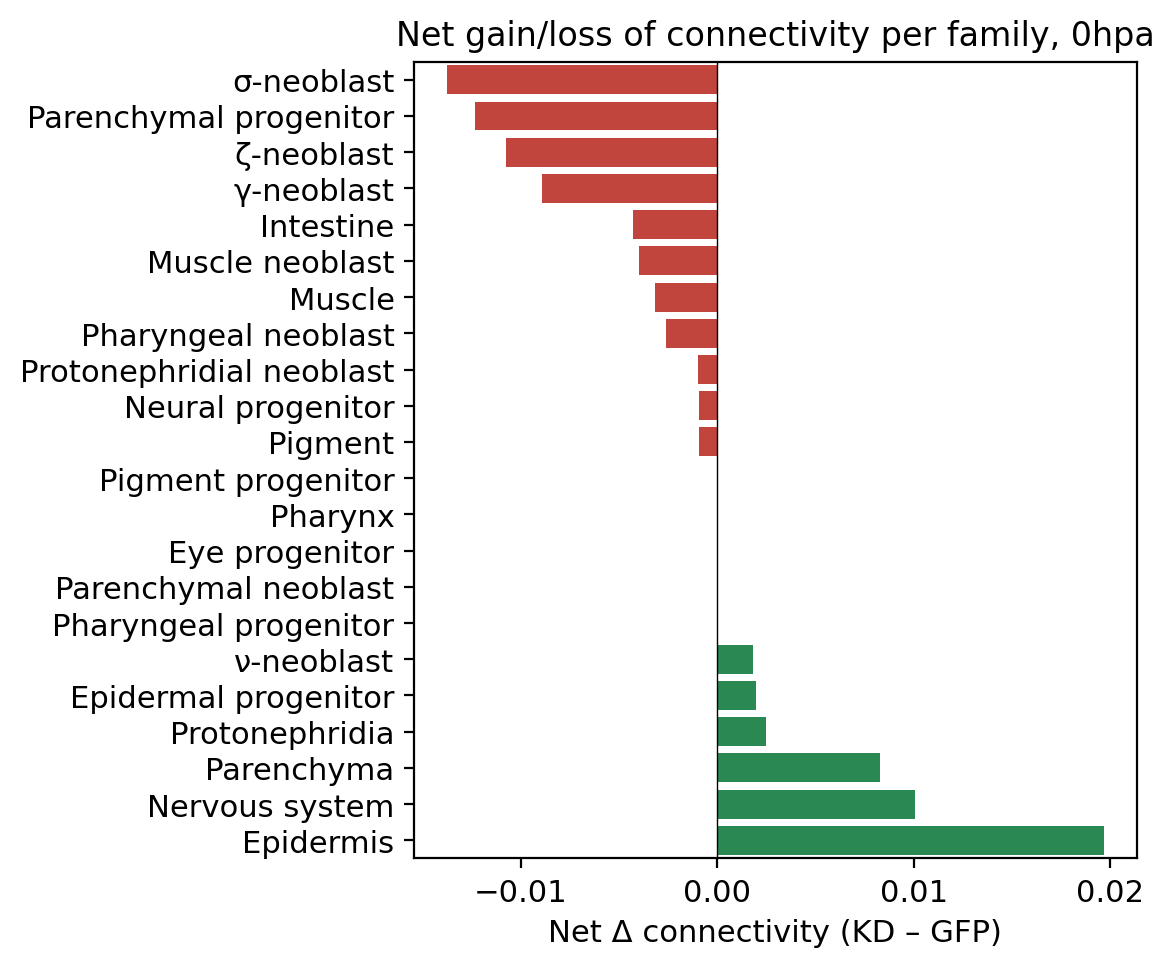

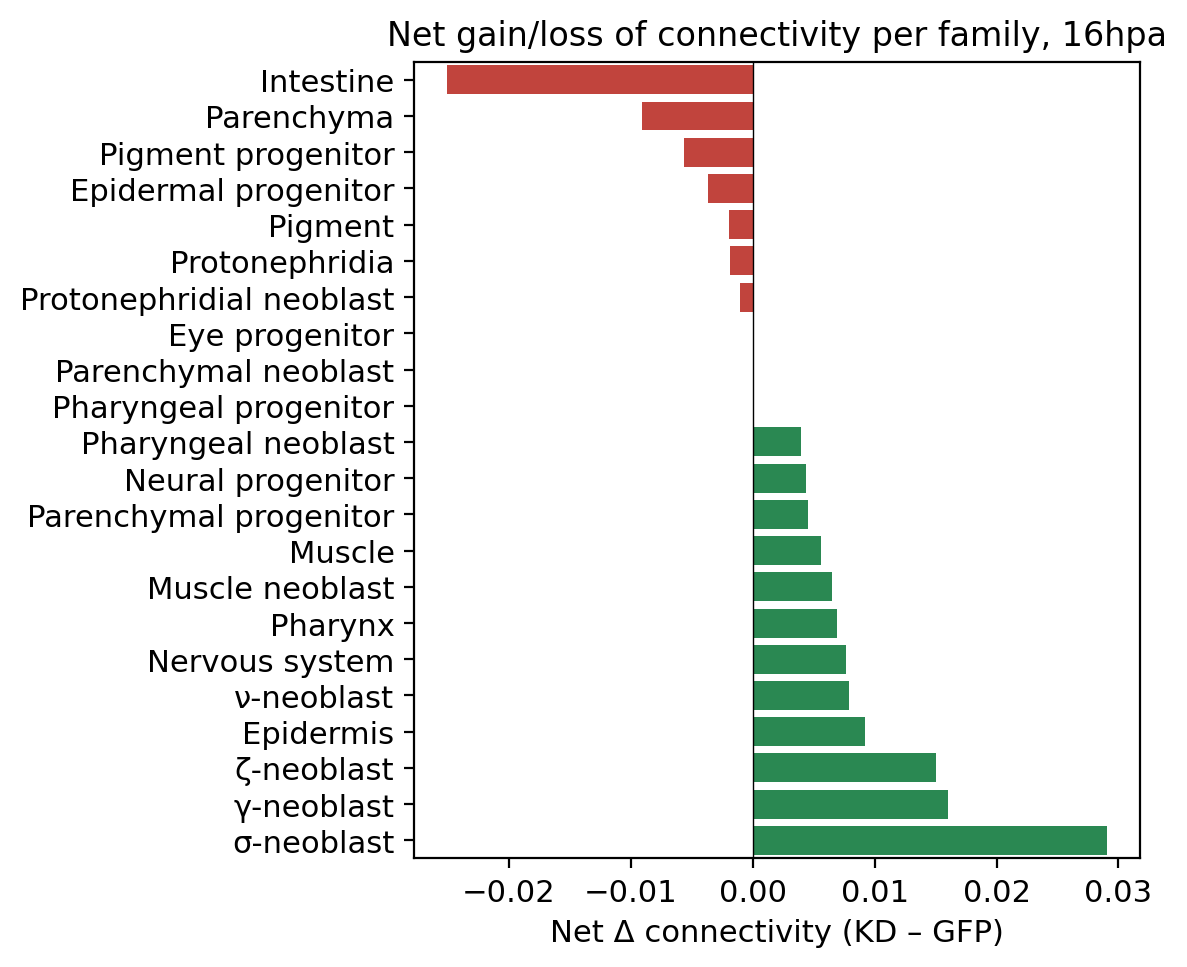

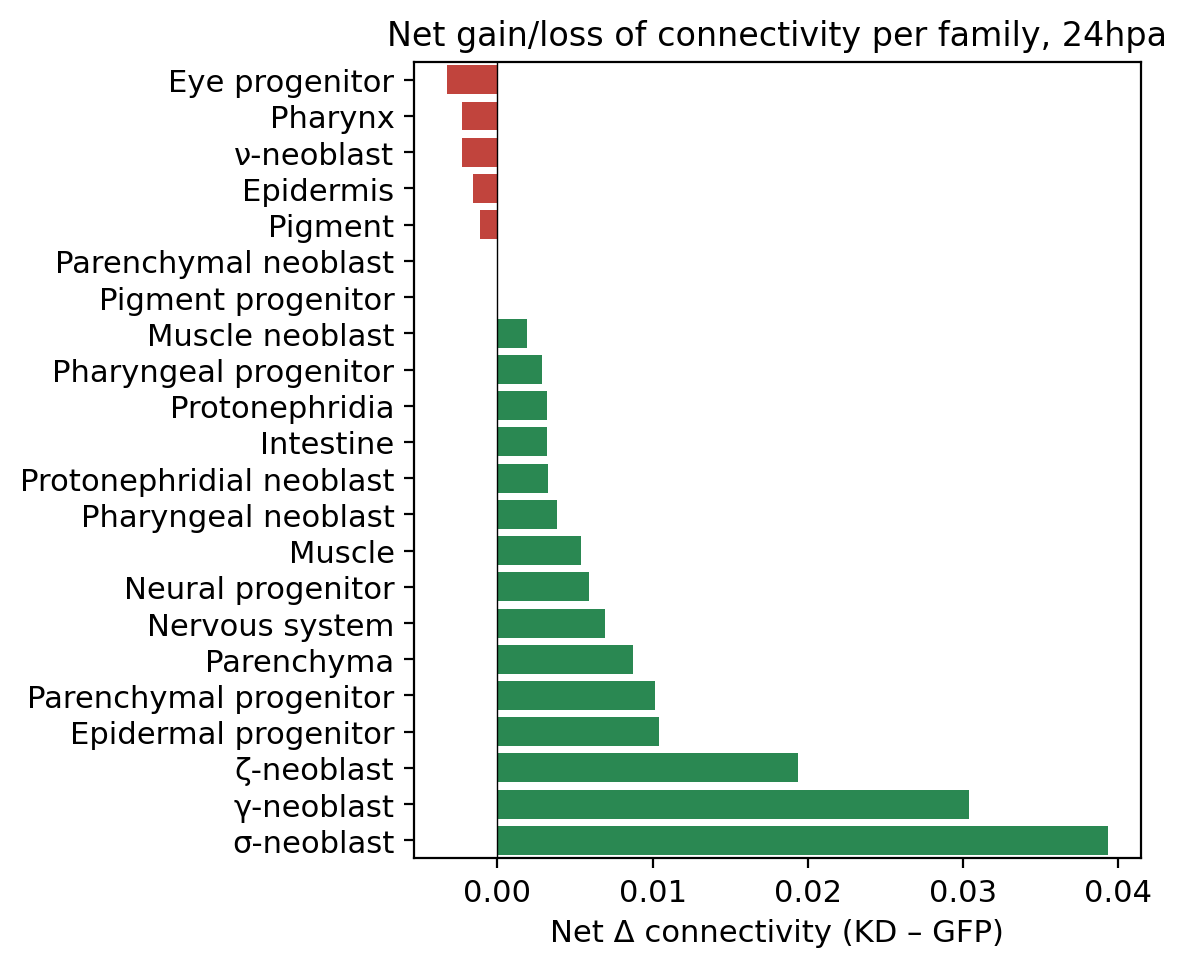

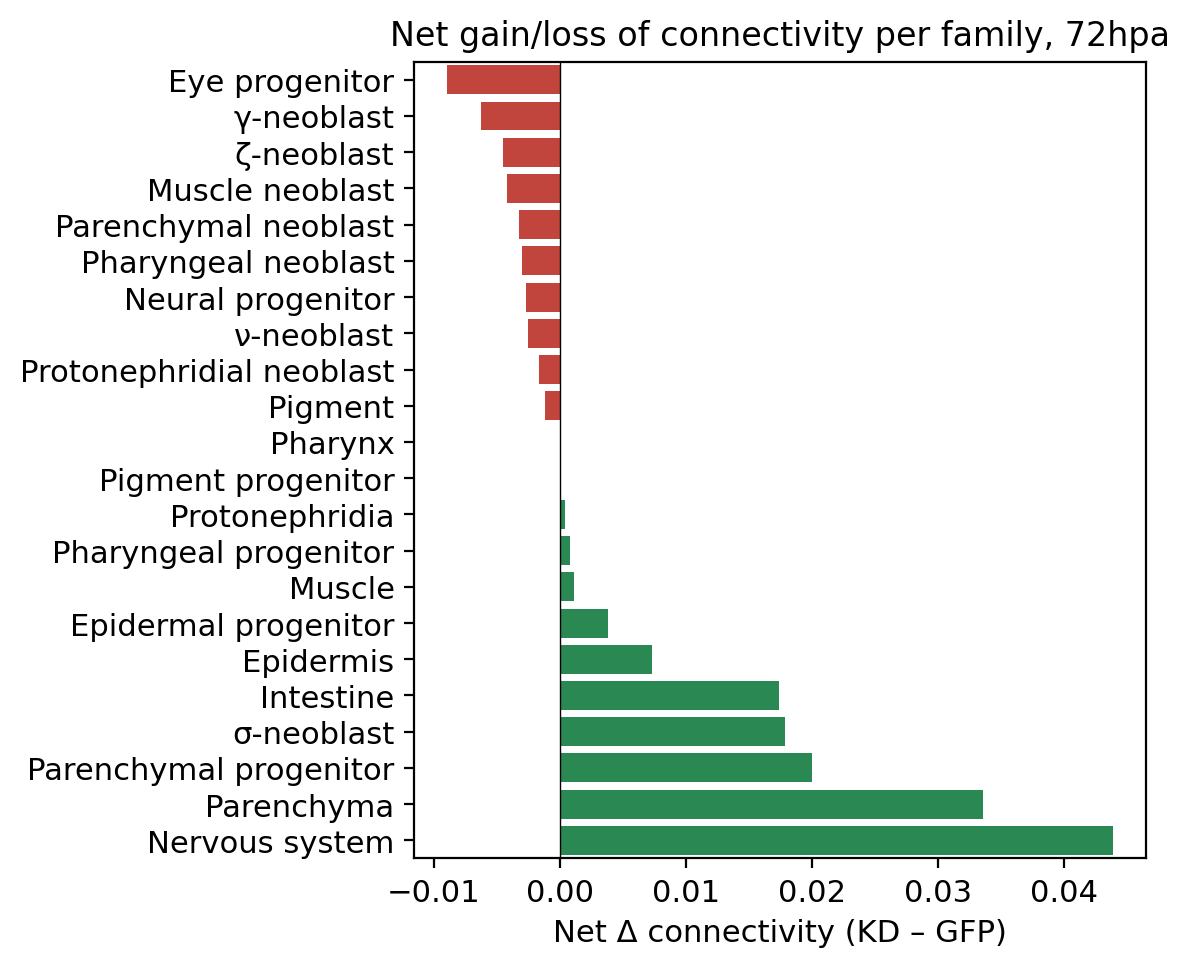

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_family_deg_delta(fam_deg, tp):
    sub = fam_deg[fam_deg["timepoint"] == tp].copy()
    sub = sub.sort_values("deg_delta")
    plt.figure(figsize=(6, 5))
    sns.barplot(
        data=sub,
        x="deg_delta", y="family",
        palette=["#d73027" if v < 0 else "#1a9850" for v in sub["deg_delta"]]
    )
    plt.axvline(0, color="k", linewidth=0.5)
    plt.xlabel("Net Δ connectivity (KD – GFP)")
    plt.ylabel("")
    plt.title(f"Net gain/loss of connectivity per family, {tp}")
    plt.tight_layout()
    plt.savefig(f"plots/PAGA_family_net_connectivity_{tp}.pdf",
                dpi=450, bbox_inches="tight")
    #plt.close()  # close current figure

for tp in ["0hpa", "16hpa", "24hpa", "72hpa"]:
    plot_family_deg_delta(fam_deg, tp)


In [19]:
import networkx as nx
import numpy as np

# assume FAM_TEMPLATE_POS is a dict: {family: np.array([x, y])}
DET_TEMPLATE_POS = _build_template_positions(adata, "celltype",
                                             topk=3, q=0.60, dmin=2)
FAM_TEMPLATE_POS = _build_template_positions(adata, "celltype_family",
                                             topk=2, q=0.40, dmin=1)
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_delta_network(
    fam_delta,
    pivot_fam,
    tp,
    template_pos,
    edge_threshold=0.003,
    base_threshold=0.01,
):
    """
    Plot family-level ELAC2-specific delta network at a given timepoint.

    Parameters
    ----------
    fam_delta : DataFrame
        Long table with columns ['src','dst','timepoint','value'],
        where 'value' is delta_ELAC2_specific for that edge.
    pivot_fam : DataFrame
        Wide table with columns ['src','dst','timepoint','WT','GFP','ELAC2 KD',...].
        Used to define baseline connectivity.
    tp : str
        Timepoint label (e.g. '72hpa').
    template_pos : dict
        {family_name: np.array([x, y])} giving fixed node positions.
    edge_threshold : float
        Minimum |Δ| to color an edge red/blue. Smaller |Δ| are treated as "no change".
    base_threshold : float
        Minimum baseline connectivity to draw an edge at all.
        Edges with baseline < base_threshold are dropped.
    """

    # Subset delta and pivot for this timepoint
    dsub = fam_delta[fam_delta["timepoint"] == tp].copy()
    if dsub.empty:
        return

    psub = pivot_fam[pivot_fam["timepoint"] == tp].copy()

    # Merge in baseline connectivity (here: mean of WT and GFP)
    # Adjust if you prefer WT only or another control definition.
    cols_needed = ["src", "dst", "timepoint", "WT", "GFP"]
    missing = [c for c in cols_needed if c not in psub.columns]
    if missing:
        raise KeyError(f"pivot_fam missing columns: {missing}")

    dsub = dsub.merge(
        psub[cols_needed],
        on=["src", "dst", "timepoint"],
        how="left",
    )

    dsub["base_conn"] = (dsub["WT"] + dsub["GFP"]) / 2.0

    # Build graph
    G = nx.Graph()
    for fam, xy in template_pos.items():
        G.add_node(fam, pos=xy)

    for _, row in dsub.iterrows():
        src = row["src"]
        dst = row["dst"]
        if (src not in template_pos) or (dst not in template_pos):
            continue

        base = row["base_conn"]
        if np.isnan(base) or base < base_threshold:
            # baseline connectivity too small -> do not draw this edge at all
            continue

        delta = row["value"]
        G.add_edge(src, dst, delta=delta, base=base)

    pos = nx.get_node_attributes(G, "pos")
    if len(G.edges) == 0:
        return

    # Classify edges
    strong_edges = []
    strong_deltas = []
    strong_colors = []
    neutral_edges = []

    for u, v, data in G.edges(data=True):
        delta = data["delta"]
        if np.abs(delta) >= edge_threshold:
            strong_edges.append((u, v))
            strong_deltas.append(delta)
            strong_colors.append("red" if delta < 0 else "blue")
        else:
            neutral_edges.append((u, v))

    plt.figure(figsize=(7, 6))

    # Nodes
    nx.draw_networkx_nodes(G, pos, node_size=400, node_color="lightgrey")
    nx.draw_networkx_labels(G, pos, font_size=8)

    # Grey edges: baseline connections with no appreciable ELAC2-specific change
    if neutral_edges:
        nx.draw_networkx_edges(
            G,
            pos,
            edgelist=neutral_edges,
            width=0.8,
            edge_color="#BBBBBB",
            alpha=0.5,
        )

    # Colored edges: ELAC2-specific changes; width encodes |Δ|
    mag_handles = []
    if strong_edges:
        w = np.asarray(strong_deltas, dtype=float)
        w_abs = np.abs(w)
        delta_max = w_abs.max()

        # avoid division by zero if all deltas equal but nonzero
        denom = delta_max if delta_max > 0 else 1.0

        widths = 3.0 * w_abs / denom
        nx.draw_networkx_edges(
            G,
            pos,
            edgelist=strong_edges,
            width=widths,
            edge_color=strong_colors,
            alpha=0.9,
        )

        # Build magnitude legend: low / mid / high |Δ|
        d_low = float(w_abs.min())
        d_med = float(np.median(w_abs))
        d_high = float(w_abs.max())

        def _width_from_delta(d):
            return 3.0 * abs(d) / denom

        mag_handles = [
            Line2D([0], [0], color="black",
                   lw=_width_from_delta(d_low),
                   label=f"|Δ| ≈ {d_low:.3f}"),
            Line2D([0], [0], color="black",
                   lw=_width_from_delta(d_med),
                   label=f"|Δ| ≈ {d_med:.3f}"),
            Line2D([0], [0], color="black",
                   lw=_width_from_delta(d_high),
                   label=f"|Δ| ≈ {d_high:.3f}"),
        ]

    # Color legend entries
    color_handles = [
        Line2D([0], [0], color="red",  lw=2,
               label=f"Weaker in Smed ELAC2 KD (Δ < 0, |Δ| ≥ {edge_threshold})"),
        Line2D([0], [0], color="blue", lw=2,
               label=f"Stronger in Smed ELAC2 KD (Δ > 0, |Δ| ≥ {edge_threshold})"),
        Line2D([0], [0], color="#BBBBBB", lw=1.5,
               label=f"No Smed ELAC2-specific change (|Δ| < {edge_threshold})"),
    ]

    handles = color_handles + mag_handles
    plt.legend(handles=handles, loc="upper left", fontsize=8, frameon=True)

    plt.title(f"Smed ELAC2-specific Δ, {tp}")
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(f"plots/PAGA_family_delta_network_{tp}.pdf",
                dpi=450, bbox_inches="tight")
    plt.close()

for tp in ["0hpa", "16hpa", "24hpa", "72hpa"]:
    plot_delta_network(fam_delta, pivot_fam, tp, FAM_TEMPLATE_POS,
                       edge_threshold=0.003, base_threshold=0.0005)


running PAGA
    finished (0:00:04)
running PAGA


/root/anaconda3/envs/sc_analysis_new/lib/python3.11/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


    finished (0:00:02)


/root/anaconda3/envs/sc_analysis_new/lib/python3.11/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/root/anaconda3/envs/sc_analysis_new/lib/python3.11/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/root/anaconda3/envs/sc_analysis_new/lib/python3.11/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.lines import Line2D

# -------------------------------------------------------------------
# Assumptions for detailed cell types
# -------------------------------------------------------------------
# det_long: long table with columns ["src","dst","timepoint","metric","value"]
#           where metric includes "WT","GFP","ELAC2 KD" and "delta_ELAC2_specific"
# det_delta: filtered to metric == "delta_ELAC2_specific", with column "value"
#
# pivot_det: wide table with columns ["src","dst","timepoint","WT","GFP","ELAC2 KD", ...]
#            (you can build it from det_long; see below)
#
# DET_TEMPLATE_POS: dict {celltype: np.array([x,y])} from:
# DET_TEMPLATE_POS = _build_template_positions(adata, "celltype", topk=3, q=0.60, dmin=2)
# -------------------------------------------------------------------


# ----------------------------
# Robust undirected keying (so merge works even if src/dst swapped)
# ----------------------------
def add_undirected_key(df: pd.DataFrame, src_col="src", dst_col="dst", key_a="a", key_b="b") -> pd.DataFrame:
    out = df.copy()
    a = out[src_col].astype(str)
    b = out[dst_col].astype(str)
    out[key_a] = np.where(a <= b, a, b)
    out[key_b] = np.where(a <= b, b, a)
    return out


# ----------------------------
# Degree-like net delta per node (undirected)
# ----------------------------
def celltype_degree_delta(det_delta: pd.DataFrame) -> pd.DataFrame:
    src_part = det_delta[["timepoint", "src", "value"]].rename(columns={"src": "celltype"})
    dst_part = det_delta[["timepoint", "dst", "value"]].rename(columns={"dst": "celltype"})
    both = pd.concat([src_part, dst_part], ignore_index=True)

    deg = (
        both.groupby(["timepoint", "celltype"], as_index=False)["value"]
        .sum()
        .rename(columns={"value": "deg_delta"})
    )
    return deg


def plot_celltype_deg_delta(
    det_deg: pd.DataFrame,
    tp: str,
    top_n: int = 25,
    out_path: str | None = None,
):
    """
    For detailed cell types the list can be long, so default is top_n most negative
    and top_n most positive (2 * top_n bars).
    """
    sub = det_deg[det_deg["timepoint"] == tp].copy()
    if sub.empty:
        return

    sub = sub.sort_values("deg_delta")
    neg = sub.head(top_n)
    pos = sub.tail(top_n)
    show = pd.concat([neg, pos], ignore_index=True).sort_values("deg_delta")

    y = np.arange(show.shape[0])
    x = show["deg_delta"].to_numpy()

    plt.figure(figsize=(7, max(5, 0.18 * show.shape[0])))
    colors = np.where(x < 0, "#d73027", "#1a9850")
    plt.barh(y, x, color=colors)
    plt.yticks(y, show["celltype"])
    plt.axvline(0, color="k", linewidth=0.6)
    plt.xlabel("Net Δ connectivity (KD – GFP)")
    plt.ylabel("")
    plt.title(f"Net gain/loss of connectivity per detailed cell type, {tp}")
    plt.tight_layout()

    if out_path is None:
        out_path = f"plots/PAGA_celltype_net_connectivity_{tp}.pdf"
    plt.savefig(out_path, dpi=450, bbox_inches="tight")
    plt.close()


# ----------------------------
# Build pivot_det (wide) from det_long if you do not already have it
# ----------------------------
def build_pivot_from_long(det_long: pd.DataFrame) -> pd.DataFrame:
    pivot = (
        det_long.pivot_table(
            index=["src", "dst", "timepoint"],
            columns="metric",
            values="value",
            aggfunc="mean",
        )
        .reset_index()
    )
    return pivot


# ----------------------------
# Delta network plot for detailed cell types
# ----------------------------
def plot_delta_network_celltype(
    det_delta: pd.DataFrame,
    pivot_det: pd.DataFrame,
    tp: str,
    template_pos: dict,
    edge_threshold: float = 0.002,
    base_threshold: float = 0.001,
    max_edges: int | None = 250,   # helpful for dense graphs; set None to keep all
    baseline_mode: str = "mean_WT_GFP",  # "WT_only" or "mean_WT_GFP"
):
    """
    Detailed cell-type ELAC2-specific delta network at a given timepoint.
    Edges are drawn only if baseline >= base_threshold.
    Colored edges require |Δ| >= edge_threshold.
    """

    dsub = det_delta[det_delta["timepoint"] == tp].copy()
    if dsub.empty:
        return

    psub = pivot_det[pivot_det["timepoint"] == tp].copy()

    need = ["src", "dst", "timepoint", "WT", "GFP"]
    missing = [c for c in need if c not in psub.columns]
    if missing:
        raise KeyError(f"pivot_det missing columns: {missing}")

    # Canonical undirected merge keys
    dsub = add_undirected_key(dsub, "src", "dst", "a", "b")
    psub = add_undirected_key(psub, "src", "dst", "a", "b")

    # Merge baseline columns by undirected key
    dsub = dsub.merge(
        psub[["timepoint", "a", "b", "WT", "GFP"]],
        on=["timepoint", "a", "b"],
        how="left",
        suffixes=("", "_base"),
    )

    if baseline_mode == "WT_only":
        dsub["base_conn"] = dsub["WT"]
    elif baseline_mode == "mean_WT_GFP":
        dsub["base_conn"] = (dsub["WT"] + dsub["GFP"]) / 2.0
    else:
        raise ValueError("baseline_mode must be 'WT_only' or 'mean_WT_GFP'")

    # Optionally keep only strongest |Δ| edges to reduce clutter
    dsub = dsub.dropna(subset=["base_conn"])
    dsub = dsub[dsub["base_conn"] >= base_threshold].copy()

    if dsub.empty:
        return

    if max_edges is not None and dsub.shape[0] > max_edges:
        dsub = dsub.reindex(dsub["value"].abs().sort_values(ascending=False).index).head(max_edges).copy()

    # Build graph
    G = nx.Graph()
    for node, xy in template_pos.items():
        G.add_node(node, pos=xy)

    # Add edges only if both endpoints exist in template_pos
    for _, row in dsub.iterrows():
        u = row["src"]
        v = row["dst"]
        if (u not in template_pos) or (v not in template_pos):
            continue
        G.add_edge(u, v, delta=float(row["value"]), base=float(row["base_conn"]))

    if G.number_of_edges() == 0:
        return

    pos = nx.get_node_attributes(G, "pos")

    # Split edges: neutral vs strong delta
    strong_edges, strong_deltas, strong_colors = [], [], []
    neutral_edges = []

    for u, v, data in G.edges(data=True):
        delta = data["delta"]
        if abs(delta) >= edge_threshold:
            strong_edges.append((u, v))
            strong_deltas.append(delta)
            strong_colors.append("red" if delta < 0 else "blue")
        else:
            neutral_edges.append((u, v))

    plt.figure(figsize=(8, 7))

    # Nodes
    nx.draw_networkx_nodes(G, pos, node_size=220, node_color="lightgrey", linewidths=0.3, edgecolors="black")
    nx.draw_networkx_labels(G, pos, font_size=6)

    # Neutral edges
    if neutral_edges:
        nx.draw_networkx_edges(
            G, pos, edgelist=neutral_edges,
            width=0.6, edge_color="#BBBBBB", alpha=0.35
        )

    # Strong edges (width encodes |Δ|)
    mag_handles = []
    if strong_edges:
        w = np.asarray(strong_deltas, dtype=float)
        w_abs = np.abs(w)
        denom = float(w_abs.max()) if float(w_abs.max()) > 0 else 1.0
        widths = 3.0 * w_abs / denom

        nx.draw_networkx_edges(
            G, pos, edgelist=strong_edges,
            width=widths, edge_color=strong_colors, alpha=0.85
        )

        d_low  = float(w_abs.min())
        d_med  = float(np.median(w_abs))
        d_high = float(w_abs.max())

        def _lw(d): return 3.0 * abs(d) / denom

        mag_handles = [
            Line2D([0], [0], color="black", lw=_lw(d_low),  label=f"|Δ| ≈ {d_low:.3f}"),
            Line2D([0], [0], color="black", lw=_lw(d_med),  label=f"|Δ| ≈ {d_med:.3f}"),
            Line2D([0], [0], color="black", lw=_lw(d_high), label=f"|Δ| ≈ {d_high:.3f}"),
        ]

    color_handles = [
        Line2D([0], [0], color="red",  lw=2, label=f"Weaker in Smed ELAC2 KD (Δ < 0, |Δ| ≥ {edge_threshold})"),
        Line2D([0], [0], color="blue", lw=2, label=f"Stronger in Smed ELAC2 KD (Δ > 0, |Δ| ≥ {edge_threshold})"),
        Line2D([0], [0], color="#BBBBBB", lw=1.5, label=f"No ELAC2-specific change (|Δ| < {edge_threshold})"),
    ]

    plt.legend(handles=color_handles + mag_handles, loc="upper left", fontsize=7, frameon=True)
    plt.title(f"Smed ELAC2-specific Δ (detailed cell types), {tp}")
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(f"plots/PAGA_celltype_delta_network_{tp}.pdf", dpi=450, bbox_inches="tight")
    plt.close()


# -------------------------------------------------------------------
# Run for detailed cell types
# -------------------------------------------------------------------
# det_delta: filter the long table
#det_delta = det_long[det_long["metric"] == "delta_ELAC2_specific"][["src","dst","timepoint","value"]].copy()

# pivot_det: wide table for baseline (WT, GFP, ELAC2 KD)
#pivot_det = build_pivot_from_long(det_long)
import pandas as pd
import numpy as np

# 1) Load / point to the detailed cell-type edge table
# If you already have edge_tbl_cell in memory, skip the if-block.
if "edge_tbl_cell" not in globals():
    edge_tbl_cell = pd.read_csv(EDGES_CELLTYPE_CSV)  # you defined EDGES_CELLTYPE_CSV earlier

# 2) Wide baseline table (per edge x timepoint) with WT/GFP/KD columns
pivot_det = (
    edge_tbl_cell.pivot_table(
        index=["src", "dst", "timepoint"],
        columns="cond",
        values="weight",
        aggfunc="mean"
    )
    .reset_index()
)

# Ensure needed columns exist
for c in ["WT", "GFP", "ELAC2 KD"]:
    if c not in pivot_det.columns:
        pivot_det[c] = 0.0

# 3) Compute ELAC2-specific delta per edge (KD-WT) - (GFP-WT) = KD - GFP
pivot_det["delta_ELAC2_specific"] = (pivot_det["ELAC2 KD"] - pivot_det["WT"]) - (pivot_det["GFP"] - pivot_det["WT"])

# 4) Long delta table used by your plotting code: ['src','dst','timepoint','value']
det_delta = pivot_det[["src", "dst", "timepoint"]].copy()
det_delta["value"] = pivot_det["delta_ELAC2_specific"].astype(float)

# Optional sanity check
print(det_delta.head())

# Degree-like net delta barplots
det_deg = celltype_degree_delta(det_delta)
for tp in ["0hpa", "16hpa", "24hpa", "72hpa"]:
    plot_celltype_deg_delta(det_deg, tp, top_n=25)

# Delta networks (requires DET_TEMPLATE_POS from _build_template_positions(..., "celltype"))
for tp in ["0hpa", "16hpa", "24hpa", "72hpa"]:
    plot_delta_network_celltype(
        det_delta, pivot_det, tp, DET_TEMPLATE_POS,
        edge_threshold=0.002,
        base_threshold=0.001,
        max_edges=250,
        baseline_mode="mean_WT_GFP",
    )

cond                    src                   dst timepoint     value
0     AQP⁺ parenchymal cell         Abraçada cell      0hpa  0.000562
1     AQP⁺ parenchymal cell         Abraçada cell     16hpa  0.000065
2     AQP⁺ parenchymal cell         Abraçada cell     24hpa  0.000113
3     AQP⁺ parenchymal cell         Abraçada cell     72hpa  0.000438
4     AQP⁺ parenchymal cell  BWM (dorsal midline)      0hpa -0.000004


/root/anaconda3/envs/sc_analysis_new/lib/python3.11/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/root/anaconda3/envs/sc_analysis_new/lib/python3.11/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/root/anaconda3/envs/sc_analysis_new/lib/python3.11/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs f

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# ----------------------------
# Helpers you already use
# ----------------------------
def add_undirected_key(df: pd.DataFrame, src_col="src", dst_col="dst", key_a="a", key_b="b") -> pd.DataFrame:
    out = df.copy()
    a = out[src_col].astype(str)
    b = out[dst_col].astype(str)
    out[key_a] = np.where(a <= b, a, b)
    out[key_b] = np.where(a <= b, b, a)
    return out

def build_pivot_from_edge_tbl(edge_tbl: pd.DataFrame) -> pd.DataFrame:
    # edge_tbl columns assumed: ["src","dst","timepoint","cond","weight"]
    pivot = (
        edge_tbl.pivot_table(
            index=["src", "dst", "timepoint"],
            columns="cond",
            values="weight",
            aggfunc="mean"
        )
        .reset_index()
    )
    for c in ["WT", "GFP", "ELAC2 KD"]:
        if c not in pivot.columns:
            pivot[c] = 0.0

    # ELAC2-specific delta = (KD-WT) - (GFP-WT) = KD - GFP
    pivot["delta_ELAC2_specific"] = (pivot["ELAC2 KD"] - pivot["WT"]) - (pivot["GFP"] - pivot["WT"])
    return pivot

def make_delta_long(pivot: pd.DataFrame) -> pd.DataFrame:
    out = pivot[["src", "dst", "timepoint"]].copy()
    out["value"] = pivot["delta_ELAC2_specific"].astype(float)
    return out


# ----------------------------
# Single-panel draw (family)
# ----------------------------
def _edges_for_tp(
    det_delta: pd.DataFrame,
    pivot: pd.DataFrame,
    tp: str,
    base_threshold: float,
    max_edges: int | None,
    baseline_mode: str,
) -> pd.DataFrame:
    dsub = det_delta[det_delta["timepoint"] == tp].copy()
    if dsub.empty:
        return dsub

    psub = pivot[pivot["timepoint"] == tp].copy()
    need = ["src", "dst", "timepoint", "WT", "GFP"]
    missing = [c for c in need if c not in psub.columns]
    if missing:
        raise KeyError(f"pivot missing columns: {missing}")

    dsub = add_undirected_key(dsub, "src", "dst", "a", "b")
    psub = add_undirected_key(psub, "src", "dst", "a", "b")

    dsub = dsub.merge(
        psub[["timepoint", "a", "b", "WT", "GFP"]],
        on=["timepoint", "a", "b"],
        how="left"
    )

    if baseline_mode == "WT_only":
        dsub["base_conn"] = dsub["WT"]
    elif baseline_mode == "mean_WT_GFP":
        dsub["base_conn"] = (dsub["WT"] + dsub["GFP"]) / 2.0
    else:
        raise ValueError("baseline_mode must be 'WT_only' or 'mean_WT_GFP'")

    dsub = dsub.dropna(subset=["base_conn"])
    dsub = dsub[dsub["base_conn"] >= base_threshold].copy()
    if dsub.empty:
        return dsub

    if max_edges is not None and dsub.shape[0] > max_edges:
        dsub = dsub.loc[dsub["value"].abs().sort_values(ascending=False).index].head(max_edges).copy()

    return dsub

def draw_family_delta_network(
    ax,
    dsub: pd.DataFrame,
    template_pos: dict,
    family_colors: dict,
    edge_threshold: float,
    width_denom: float,
    max_width: float = 3.0,
    node_size: int = 260,
):
    # Graph with all nodes for consistent embedding
    G = nx.Graph()
    for node, xy in template_pos.items():
        G.add_node(node, pos=xy)

    # Add edges present at this timepoint
    for _, r in dsub.iterrows():
        u, v = r["src"], r["dst"]
        if (u not in template_pos) or (v not in template_pos):
            continue
        G.add_edge(u, v, delta=float(r["value"]))

    pos = nx.get_node_attributes(G, "pos")

    # Node colors (no labels)
    nodes = list(G.nodes())
    node_cols = [family_colors.get(n, family_colors.get("other", "#BDBDBD")) for n in nodes]
    nx.draw_networkx_nodes(
        G, pos, nodelist=nodes, node_color=node_cols, node_size=node_size,
        linewidths=0.4, edgecolors="black", ax=ax
    )

    # Edge split
    strong_edges, strong_deltas, strong_cols = [], [], []
    neutral_edges = []

    for u, v, data in G.edges(data=True):
        d = float(data["delta"])
        if abs(d) >= edge_threshold:
            strong_edges.append((u, v))
            strong_deltas.append(d)
            strong_cols.append("red" if d < 0 else "blue")
        else:
            neutral_edges.append((u, v))

    if neutral_edges:
        nx.draw_networkx_edges(
            G, pos, edgelist=neutral_edges, width=0.6, edge_color="#BBBBBB",
            alpha=0.35, ax=ax
        )

    if strong_edges:
        w = np.abs(np.asarray(strong_deltas, dtype=float))
        denom = width_denom if width_denom > 0 else 1.0
        widths = max_width * (w / denom)

        nx.draw_networkx_edges(
            G, pos, edgelist=strong_edges, width=widths,
            edge_color=strong_cols, alpha=0.85, ax=ax
        )

    ax.set_axis_off()


# ----------------------------
# 2x2 panel plot (A4 landscape) with common legends
# ----------------------------
def plot_family_delta_panel_2x2(
    det_delta_family: pd.DataFrame,
    pivot_family: pd.DataFrame,
    template_pos_family: dict,
    family_colors: dict,
    tps=("0hpa", "16hpa", "24hpa", "72hpa"),
    edge_threshold: float = 0.002,
    base_threshold: float = 0.001,
    max_edges: int | None = 250,
    baseline_mode: str = "mean_WT_GFP",
    out_path: str = "plots/PAGA_family_delta_panel_A4.pdf",
):
    # Precompute filtered edges per TP + global scaling for widths (consistent across panels)
    dsubs = {}
    all_strong_abs = []

    for tp in tps:
        dsub = _edges_for_tp(
            det_delta_family, pivot_family, tp,
            base_threshold=base_threshold,
            max_edges=max_edges,
            baseline_mode=baseline_mode,
        )
        dsubs[tp] = dsub
        if not dsub.empty:
            strong = dsub.loc[dsub["value"].abs() >= edge_threshold, "value"].abs().to_numpy()
            if strong.size:
                all_strong_abs.append(strong)

    if all_strong_abs:
        all_strong_abs = np.concatenate(all_strong_abs)
        width_denom = float(all_strong_abs.max())
        # Reference magnitudes for legend (global, so comparable across panels)
        d_low  = float(np.quantile(all_strong_abs, 0.25))
        d_med  = float(np.quantile(all_strong_abs, 0.50))
        d_high = float(np.quantile(all_strong_abs, 0.90))
    else:
        width_denom = 1.0
        d_low = d_med = d_high = edge_threshold

    # A4 landscape in inches: 11.69 x 8.27
    fig, axes = plt.subplots(2, 2, figsize=(11.69, 8.27))
    axes = axes.ravel()

    for i, tp in enumerate(tps):
        ax = axes[i]
        dsub = dsubs.get(tp, pd.DataFrame())
        draw_family_delta_network(
            ax=ax,
            dsub=dsub,
            template_pos=template_pos_family,
            family_colors=family_colors,
            edge_threshold=edge_threshold,
            width_denom=width_denom,
            max_width=3.0,
            node_size=260,
        )
        ax.set_title(tp, fontsize=10)

    # If fewer than 4 timepoints provided, hide extra axes
    for j in range(len(tps), 4):
        axes[j].set_axis_off()

    # Common edge legend
    def _lw(d):  # consistent with draw_family_delta_network max_width=3.0
        return 3.0 * (abs(d) / (width_denom if width_denom > 0 else 1.0))

    edge_handles = [
        Line2D([0], [0], color="red",  lw=2, label=f"Weaker in Smed ELAC2 KD (Δ < 0, |Δ| ≥ {edge_threshold})"),
        Line2D([0], [0], color="blue", lw=2, label=f"Stronger in Smed ELAC2 KD (Δ > 0, |Δ| ≥ {edge_threshold})"),
        Line2D([0], [0], color="#BBBBBB", lw=1.5, label=f"No ELAC2-specific change (|Δ| < {edge_threshold})"),
        Line2D([0], [0], color="black", lw=_lw(d_low),  label=f"|Δ| ≈ {d_low:.3f}"),
        Line2D([0], [0], color="black", lw=_lw(d_med),  label=f"|Δ| ≈ {d_med:.3f}"),
        Line2D([0], [0], color="black", lw=_lw(d_high), label=f"|Δ| ≈ {d_high:.3f}"),
    ]

    # Node (family) color legend: only families actually present in the embedding
    fam_present = [f for f in template_pos_family.keys() if f in family_colors]
    # Keep a stable, readable order (alphabetical, with "other" last if present)
    fam_present = sorted([f for f in fam_present if f != "other"]) + (["other"] if "other" in family_colors else [])
    node_handles = [Patch(facecolor=family_colors[f], edgecolor="black", label=f) for f in fam_present]

    # Layout: reserve space on right for node legend and on bottom for edge legend
    plt.subplots_adjust(left=0.05, right=0.78, top=0.92, bottom=0.18, wspace=0.08, hspace=0.12)

    # Edge legend at bottom (common)
    fig.legend(
        handles=edge_handles,
        loc="lower center",
        ncol=3,
        fontsize=8,
        frameon=True,
        bbox_to_anchor=(0.40, 0.05),
    )

    # Node legend on right (common)
    fig.legend(
        handles=node_handles,
        loc="center left",
        fontsize=8,
        frameon=True,
        bbox_to_anchor=(0.80, 0.52),
    )

    fig.suptitle("Smed ELAC2-specific Δ connectivity (family level)", fontsize=12)
    fig.savefig(out_path, dpi=450, bbox_inches="tight")
    plt.close(fig)


# -------------------------------------------------------------------
# Usage (family-level)
# -------------------------------------------------------------------
edge_tbl_family = pd.read_csv(EDGES_FAMILY_CSV)  # columns: src,dst,timepoint,cond,weight
pivot_family = build_pivot_from_edge_tbl(edge_tbl_family)
det_delta_family = make_delta_long(pivot_family)



# Now this works:
FAMILY_TEMPLATE_POS = FAM_TEMPLATE_POS


#
# FAMILY_TEMPLATE_POS should come from your template builder on the *family* label, e.g.:
#FAMILY_TEMPLATE_POS = _build_template_positions(adata, "family", topk=3, q=0.60, dmin=2)

plot_family_delta_panel_2x2(
    det_delta_family=det_delta_family,
    pivot_family=pivot_family,
    template_pos_family=FAMILY_TEMPLATE_POS,
    family_colors=FAMILY_COLORS,
    tps=("0hpa","16hpa","24hpa","72hpa"),
    edge_threshold=0.002,
    base_threshold=0.001,
    max_edges=250,
    baseline_mode="mean_WT_GFP",
    out_path="plots/PAGA_family_delta_panel_A4.pdf",
)


/root/anaconda3/envs/sc_analysis_new/lib/python3.11/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/root/anaconda3/envs/sc_analysis_new/lib/python3.11/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/root/anaconda3/envs/sc_analysis_new/lib/python3.11/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs f

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import matplotlib.patheffects as pe

# ----------------------------
# Helpers
# ----------------------------
def add_undirected_key(df: pd.DataFrame, src_col="src", dst_col="dst", key_a="a", key_b="b") -> pd.DataFrame:
    out = df.copy()
    a = out[src_col].astype(str)
    b = out[dst_col].astype(str)
    out[key_a] = np.where(a <= b, a, b)
    out[key_b] = np.where(a <= b, b, a)
    return out

def build_pivot_from_edge_tbl(edge_tbl: pd.DataFrame) -> pd.DataFrame:
    pivot = (
        edge_tbl.pivot_table(
            index=["src", "dst", "timepoint"],
            columns="cond",
            values="weight",
            aggfunc="mean"
        )
        .reset_index()
    )
    for c in ["WT", "GFP", "ELAC2 KD"]:
        if c not in pivot.columns:
            pivot[c] = 0.0
    pivot["delta_ELAC2_specific"] = (pivot["ELAC2 KD"] - pivot["GFP"])
    return pivot

def make_delta_long(pivot: pd.DataFrame) -> pd.DataFrame:
    out = pivot[["src", "dst", "timepoint"]].copy()
    out["value"] = pivot["delta_ELAC2_specific"].astype(float)
    return out

# ----------------------------
# Edge filtering (baseline connectivity gate)
# ----------------------------
def _edges_for_tp(
    det_delta: pd.DataFrame,
    pivot: pd.DataFrame,
    tp: str,
    base_threshold: float,
    max_edges: int | None,
    baseline_mode: str,
) -> pd.DataFrame:
    dsub = det_delta[det_delta["timepoint"] == tp].copy()
    if dsub.empty:
        return dsub

    psub = pivot[pivot["timepoint"] == tp].copy()
    need = ["src", "dst", "timepoint", "WT", "GFP"]
    missing = [c for c in need if c not in psub.columns]
    if missing:
        raise KeyError(f"pivot missing columns: {missing}")

    dsub = add_undirected_key(dsub, "src", "dst", "a", "b")
    psub = add_undirected_key(psub, "src", "dst", "a", "b")

    dsub = dsub.merge(
        psub[["timepoint", "a", "b", "WT", "GFP"]],
        on=["timepoint", "a", "b"],
        how="left"
    )

    if baseline_mode == "WT_only":
        dsub["base_conn"] = dsub["WT"]
    elif baseline_mode == "mean_WT_GFP":
        dsub["base_conn"] = (dsub["WT"] + dsub["GFP"]) / 2.0
    else:
        raise ValueError("baseline_mode must be 'WT_only' or 'mean_WT_GFP'")

    dsub = dsub.dropna(subset=["base_conn"])
    dsub = dsub[dsub["base_conn"] >= base_threshold].copy()
    if dsub.empty:
        return dsub

    if max_edges is not None and dsub.shape[0] > max_edges:
        dsub = dsub.loc[dsub["value"].abs().sort_values(ascending=False).index].head(max_edges).copy()

    return dsub

# ----------------------------
# Label helpers (colored labels, non-overlap-ish)
# ----------------------------
def _darken(hex_color: str, factor: float = 0.35) -> str:
    rgb = np.array(mcolors.to_rgb(hex_color))
    rgb = np.clip(rgb * factor, 0, 1)
    return mcolors.to_hex(rgb)

def _repel_label_offsets(pos: dict, iters: int = 250, step: float = 0.015) -> dict:
    """
    Simple deterministic repulsion in label space.
    Works well for small node counts (family-level).
    Returns offsets (dx,dy) per node in data coordinates.
    """
    nodes = list(pos.keys())
    xy = np.array([pos[n] for n in nodes], dtype=float)
    x, y = xy[:, 0].copy(), xy[:, 1].copy()

    # start labels slightly up-right
    dx = np.full_like(x, 0.0)
    dy = np.full_like(y, 0.0)

    # scale step to embedding range
    xr = float(x.max() - x.min()) if x.max() > x.min() else 1.0
    yr = float(y.max() - y.min()) if y.max() > y.min() else 1.0
    step_x = step * xr
    step_y = step * yr

    # repulsion radius (in embedding units)
    r0 = 0.06 * max(xr, yr)
    r02 = r0 * r0

    for _ in range(iters):
        moved = False
        for i in range(len(nodes)):
            for j in range(i + 1, len(nodes)):
                xi, yi = x[i] + dx[i], y[i] + dy[i]
                xj, yj = x[j] + dx[j], y[j] + dy[j]
                vx, vy = xi - xj, yi - yj
                d2 = vx * vx + vy * vy
                if d2 < r02:
                    # push apart
                    if d2 == 0:
                        vx, vy = 1.0, 0.0
                        d2 = 1.0
                    inv = 1.0 / np.sqrt(d2)
                    px, py = vx * inv, vy * inv
                    dx[i] += px * step_x
                    dy[i] += py * step_y
                    dx[j] -= px * step_x
                    dy[j] -= py * step_y
                    moved = True
        if not moved:
            break

    return {nodes[i]: (float(dx[i]), float(dy[i])) for i in range(len(nodes))}

# ----------------------------
# Draw one panel (nodes + labels, no node legend)
# ----------------------------
def draw_family_delta_network(
    ax,
    dsub: pd.DataFrame,
    template_pos: dict,
    family_colors: dict,
    edge_threshold: float,
    width_denom: float,
    max_width: float = 3.0,
    node_size: int = 280,
    label_fontsize: int = 9,
    repel_labels: bool = True,
):
    G = nx.Graph()
    for node, xy in template_pos.items():
        G.add_node(node, pos=np.asarray(xy, dtype=float))

    # add edges
    for _, r in dsub.iterrows():
        u, v = r["src"], r["dst"]
        if (u not in template_pos) or (v not in template_pos):
            continue
        G.add_edge(u, v, delta=float(r["value"]))

    if G.number_of_nodes() == 0:
        ax.set_axis_off()
        return

    pos = nx.get_node_attributes(G, "pos")
    nodes = list(G.nodes())

    node_cols = [family_colors.get(n, family_colors.get("other", "#BDBDBD")) for n in nodes]
    nx.draw_networkx_nodes(
        G, pos, nodelist=nodes, node_color=node_cols, node_size=node_size,
        linewidths=0.5, edgecolors="black", ax=ax
    )

    # edges
    strong_edges, strong_deltas, strong_cols = [], [], []
    neutral_edges = []

    for u, v, data in G.edges(data=True):
        d = float(data["delta"])
        if abs(d) >= edge_threshold:
            strong_edges.append((u, v))
            strong_deltas.append(d)
            strong_cols.append("red" if d < 0 else "blue")
        else:
            neutral_edges.append((u, v))

    if neutral_edges:
        nx.draw_networkx_edges(G, pos, edgelist=neutral_edges, width=0.7, edge_color="#BEBEBE", alpha=0.35, ax=ax)

    if strong_edges:
        w = np.abs(np.asarray(strong_deltas, dtype=float))
        denom = width_denom if width_denom > 0 else 1.0
        widths = max_width * (w / denom)
        nx.draw_networkx_edges(G, pos, edgelist=strong_edges, width=widths, edge_color=strong_cols, alpha=0.85, ax=ax)

    # labels (colored, no node legend)
    if repel_labels:
        offsets = _repel_label_offsets(pos, iters=300, step=0.010)
    else:
        offsets = {n: (0.0, 0.0) for n in nodes}

    for n in nodes:
        x, y = pos[n]
        dx, dy = offsets.get(n, (0.0, 0.0))

        base_c = family_colors.get(n, family_colors.get("other", "#BDBDBD"))
        txt_c = _darken(base_c, factor=0.30)

        ax.text(
            x + dx, y + dy, n,
            fontsize=label_fontsize,
            color=txt_c,
            ha="center", va="center",
            bbox=dict(facecolor="white", edgecolor="none", alpha=0.65, pad=0.6),
            path_effects=[pe.withStroke(linewidth=1.0, foreground="black", alpha=0.25)],
            zorder=10
        )

    ax.set_axis_off()

# ----------------------------
# 2x2 panel plot (A4) + ONLY edge legend
# ----------------------------
def plot_family_delta_panel_2x2(
    det_delta_family: pd.DataFrame,
    pivot_family: pd.DataFrame,
    template_pos_family: dict,
    family_colors: dict,
    tps=("0hpa", "16hpa", "24hpa", "72hpa"),
    edge_threshold: float = 0.002,
    base_threshold: float = 0.001,
    max_edges: int | None = None,  # family graph is small; keep all unless you want trimming
    baseline_mode: str = "mean_WT_GFP",
    out_path: str = "plots/PAGA_family_delta_panel_A4.pdf",
):
    dsubs = {}
    all_strong_abs = []

    for tp in tps:
        dsub = _edges_for_tp(
            det_delta_family, pivot_family, tp,
            base_threshold=base_threshold,
            max_edges=max_edges,
            baseline_mode=baseline_mode,
        )
        dsubs[tp] = dsub
        if not dsub.empty:
            strong = dsub.loc[dsub["value"].abs() >= edge_threshold, "value"].abs().to_numpy()
            if strong.size:
                all_strong_abs.append(strong)

    if all_strong_abs:
        all_strong_abs = np.concatenate(all_strong_abs)
        width_denom = float(all_strong_abs.max())
        d_low  = float(np.quantile(all_strong_abs, 0.25))
        d_med  = float(np.quantile(all_strong_abs, 0.50))
        d_high = float(np.quantile(all_strong_abs, 0.90))
    else:
        width_denom = 1.0
        d_low = d_med = d_high = edge_threshold

    fig, axes = plt.subplots(2, 2, figsize=(11.69, 8.27))
    axes = axes.ravel()

    for i, tp in enumerate(tps):
        ax = axes[i]
        dsub = dsubs.get(tp, pd.DataFrame())
        draw_family_delta_network(
            ax=ax,
            dsub=dsub,
            template_pos=template_pos_family,
            family_colors=family_colors,
            edge_threshold=edge_threshold,
            width_denom=width_denom,
            max_width=3.0,
            node_size=300,
            label_fontsize=9,
            repel_labels=True,
        )
        ax.set_title(tp, fontsize=10)

    for j in range(len(tps), 4):
        axes[j].set_axis_off()

    def _lw(d):
        return 3.0 * (abs(d) / (width_denom if width_denom > 0 else 1.0))

    edge_handles = [
        Line2D([0], [0], color="red",  lw=2, label=f"Weaker in Smed ELAC2 KD (Δ < 0, |Δ| ≥ {edge_threshold})"),
        Line2D([0], [0], color="blue", lw=2, label=f"Stronger in Smed ELAC2 KD (Δ > 0, |Δ| ≥ {edge_threshold})"),
        Line2D([0], [0], color="#BEBEBE", lw=1.5, label=f"No ELAC2-specific change (|Δ| < {edge_threshold})"),
        Line2D([0], [0], color="black", lw=_lw(d_low),  label=f"|Δ| ≈ {d_low:.3f}"),
        Line2D([0], [0], color="black", lw=_lw(d_med),  label=f"|Δ| ≈ {d_med:.3f}"),
        Line2D([0], [0], color="black", lw=_lw(d_high), label=f"|Δ| ≈ {d_high:.3f}"),
    ]

    # Use full width (no node legend)
    plt.subplots_adjust(left=0.05, right=0.98, top=0.92, bottom=0.18, wspace=0.08, hspace=0.12)

    fig.legend(
        handles=edge_handles,
        loc="lower center",
        ncol=3,
        fontsize=8,
        frameon=True,
        bbox_to_anchor=(0.5, 0.05),
    )

    fig.suptitle("Smed ELAC2-specific Δ connectivity (family level)", fontsize=12)
    fig.savefig(out_path, dpi=450, bbox_inches="tight")
    plt.close(fig)


# -------------------------------------------------------------------
# Usage
# -------------------------------------------------------------------
edge_tbl_family = pd.read_csv(EDGES_FAMILY_CSV)  # src,dst,timepoint,cond,weight
pivot_family = build_pivot_from_edge_tbl(edge_tbl_family)
det_delta_family = make_delta_long(pivot_family)

# Use the template you already computed
FAMILY_TEMPLATE_POS = FAM_TEMPLATE_POS

# 3) Connect more edges:
# Lower base_threshold (e.g. 0.001 -> 0.0005 or 0.0002). Do NOT change edge_threshold for this purpose.
plot_family_delta_panel_2x2(
    det_delta_family=det_delta_family,
    pivot_family=pivot_family,
    template_pos_family=FAMILY_TEMPLATE_POS,
    family_colors=FAMILY_COLORS,
    tps=("0hpa","16hpa","24hpa","72hpa"),
    edge_threshold=0.002,
    base_threshold=0.0005,   # <-- more edges drawn (baseline gate)
    max_edges=None,
    baseline_mode="mean_WT_GFP",
    out_path="plots/PAGA_family_delta_panel_A4_new.pdf",
)


/root/anaconda3/envs/sc_analysis_new/lib/python3.11/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/root/anaconda3/envs/sc_analysis_new/lib/python3.11/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/root/anaconda3/envs/sc_analysis_new/lib/python3.11/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs f